In [1]:
import sys, os
import json, pickle
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
import time as pytime
import statsmodels.tsa.stattools as tsa
import ruptures as rpt
sys.path.append('../..')
import InsanallyLabEphysTools as ilep
from scipy.stats import gaussian_kde, sem, ttest_ind, ttest_rel, norm, mannwhitneyu, linregress, wilcoxon
from tqdm import tqdm
from types import SimpleNamespace
from sklearn import linear_model
from itertools import product
from datetime import datetime
from matplotlib.backends.backend_pdf import PdfPages
import h5py
#import tables as tb
from copy import deepcopy
import colorsys
import pingouin as pg

from sklearn.model_selection import GridSearchCV, StratifiedKFold, LeaveOneOut, KFold
from sklearn.neighbors import KernelDensity

plt.rcParams['legend.fontsize'] = 'small'
plt.rcParams['axes.labelsize'] = 'medium'
plt.rcParams['axes.formatter.limits'] = [-2,3]
plt.rcParams['axes.formatter.use_mathtext'] = True
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['figure.dpi'] = '150'

#Set global font parameters
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Arial'
#Set font type to TrueType for compatibility
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

TARGET_COLOR = '#ff3654'
NONTARGET_COLOR = '#5776ff'

CR_COLOR = '#808080'
NCR_COLOR = '#FF767C'
CNO_COLOR = '#00BFFF'
NCR_CR_cmap = mpl.colors.LinearSegmentedColormap.from_list('NCR-CR color map', [NCR_COLOR, CR_COLOR], N=1000)

act_directory = 'C:\\Users\insan\\Desktop\\Camera_Cache'



C:\Users\insan\anaconda3\envs\Ephyanalysis\lib\site-packages\outdated\utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.3, the latest is 0.5.4.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


In [2]:
import pandas as pd
from pathlib import Path
import numpy as np
import os
import matplotlib.pyplot as plt
import dlc2kinematics

C:\Users\insan\anaconda3\envs\Ephyanalysis\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
animals_in_cache = []
EnumSession = []
EnumClust = []
EnumOnlySession = []

for session in tqdm(os.listdir(act_directory)):
    sessionfile = ilep.loadSessionCached(act_directory,session)
    animals_in_cache.append(sessionfile.meta.animal)

    if not sessionfile.meta.region == 'AC':
        continue
    
    EnumOnlySession.append(session)
    
    for clust in sessionfile.clusters.good:
        EnumSession.append(session)
        EnumClust.append(clust)
        
        
animals_in_cache = np.unique(animals_in_cache)

100%|██████████| 2/2 [00:00<00:00, 40.03it/s]


In [4]:
sessionfile_D7 = ilep.loadSessionCached(act_directory,EnumOnlySession[0])
sessionfile_D9 = ilep.loadSessionCached(act_directory,EnumOnlySession[1])

In [5]:
#Classify NCR_CR

##############FRmod_baseline might be changed later(median from pre_early tuning animals)
FRmod_baseline = 3.5

NCR_D7 = []
for clust in sessionfile_D7.clusters.good:
    if sessionfile_D7.responsiveness[clust]['all_trials'].FRmodulation < FRmod_baseline:
        NCR_D7.append(clust)
#print(NCR_D7)

NCR_D9 = []
CR_D9 = []
for clust in sessionfile_D9.clusters.good:
    if sessionfile_D9.responsiveness[clust]['all_trials'].FRmodulation < FRmod_baseline:
        NCR_D9.append(clust)
    else:
        CR_D9.append(clust)
print(NCR_D9)
print(CR_D9)

print(len(NCR_D9))
print(len(CR_D9))

[8, 33, 43, 44, 59, 92, 96]
[3, 13, 15, 19, 31, 50, 77, 87, 88, 90, 91]
7
11


In [6]:
#3003 movement data

dataname3 = 'C:\\Users\insan\\Desktop\\IR Camera Videos\\Day 9\\AE_231_3\\CogRig_AE_231_2023-02-14_3DLC_resnet50_Training_projectMar3shuffle1_500000.h5'
dataframe3 = pd.read_hdf(os.path.join(dataname3))

df_Hand3 = dataframe3.iloc[:,9:11]
df_Mouth3 = dataframe3.iloc[:,3:5]
df_Whisker3 = dataframe3.iloc[:,6:8]
df_Nose3 = dataframe3.iloc[:,12:14]

In [7]:
dataframe3

scorer    DLC_resnet50_Training_projectMar3shuffle1_500000              \
bodyparts                                              Ear               
coords                                                   x           y   
0                                               365.569733  314.891205   
1                                               364.777313  314.208099   
2                                               364.813995  314.041229   
3                                               365.157074  314.371124   
4                                               382.732758  306.522339   
...                                                    ...         ...   
47950                                           381.755737  298.842529   
47951                                           381.597229  298.264587   
47952                                           381.591919  297.654205   
47953                                           381.208160  298.493011   
47954                                           381.084167  297.003540   

scorer                                                               \
bodyparts                  Mouth                            Whisker   
coords    likelihood           x           y likelihood           x   
0           0.000655  244.629730  302.147156        1.0  228.174377   
1           0.000544  241.721451  302.179840        1.0  227.583679   
2           0.000474  241.524292  302.154999        1.0  227.416489   
3           0.000653  241.930573  300.753204        1.0  227.476715   
4           0.000503  242.452591  301.695862        1.0  227.723419   
...              ...         ...         ...        ...         ...   
47950       0.000520  243.719635  304.617706        1.0  227.989304   
47951       0.000617  242.587402  303.633728        1.0  227.942169   
47952       0.000818  244.302704  303.640076        1.0  228.186539   
47953       0.000569  243.681488  303.073608        1.0  228.168427   
47954       0.000968  243.449585  301.728607        1.0  228.235275   

scorer                                                               \
bodyparts                               Hand                          
coords              y likelihood           x           y likelihood   
0          260.918701        1.0  370.713684  308.545898        1.0   
1          260.602448        1.0  370.643921  307.567932        1.0   
2          260.341217        1.0  372.733337  307.104309        1.0   
3          260.916473        1.0  371.886047  308.427704        1.0   
4          261.072205        1.0  371.747223  307.421448        1.0   
...               ...        ...         ...         ...        ...   
47950      261.571808        1.0  384.687836  294.618286        1.0   
47951      261.849976        1.0  385.352875  293.639740        1.0   
47952      261.125153        1.0  386.683868  292.744324        1.0   
47953      260.950500        1.0  385.432281  293.288574        1.0   
47954      260.290863        1.0  386.918427  291.920380        1.0   

scorer                                        
bodyparts        Nose                         
coords              x           y likelihood  
0          181.809357  292.558380        1.0  
1          181.889221  293.501160        1.0  
2          182.134338  293.344971        1.0  
3          182.314331  293.513977        1.0  
4          183.110214  294.593567        1.0  
...               ...         ...        ...  
47950      183.179901  295.465729        1.0  
47951      182.791977  295.136536        1.0  
47952      182.692856  294.588318        1.0  
47953      182.012329  294.451355        1.0  
47954      183.887527  293.271362        1.0  

[47955 rows x 15 columns]

In [8]:
#not used
mouth3_x = df_Mouth3.iloc[:,0].to_numpy()
mouth3_y = df_Mouth3.iloc[:,1].to_numpy()

nose3_x = df_Nose3.iloc[:,0].to_numpy()
nose3_y = df_Nose3.iloc[:,0].to_numpy()

hand3_x = df_Hand3.iloc[:,0].to_numpy()
hand3_y = df_Hand3.iloc[:,1].to_numpy()

In [9]:
#Calculate speed for each body part
df3, bodyparts, scorer = dlc2kinematics.load_data(dataname3)

df_speed_Hand3 = dlc2kinematics.compute_speed(df3,bodyparts=['Hand'])
df_speed_Mouth3 = dlc2kinematics.compute_speed(df3,bodyparts=['Mouth'])
df_speed_Nose3 = dlc2kinematics.compute_speed(df3,bodyparts=['Nose'])
df_speed_Whisker3 = dlc2kinematics.compute_speed(df3,bodyparts=['Whisker'])

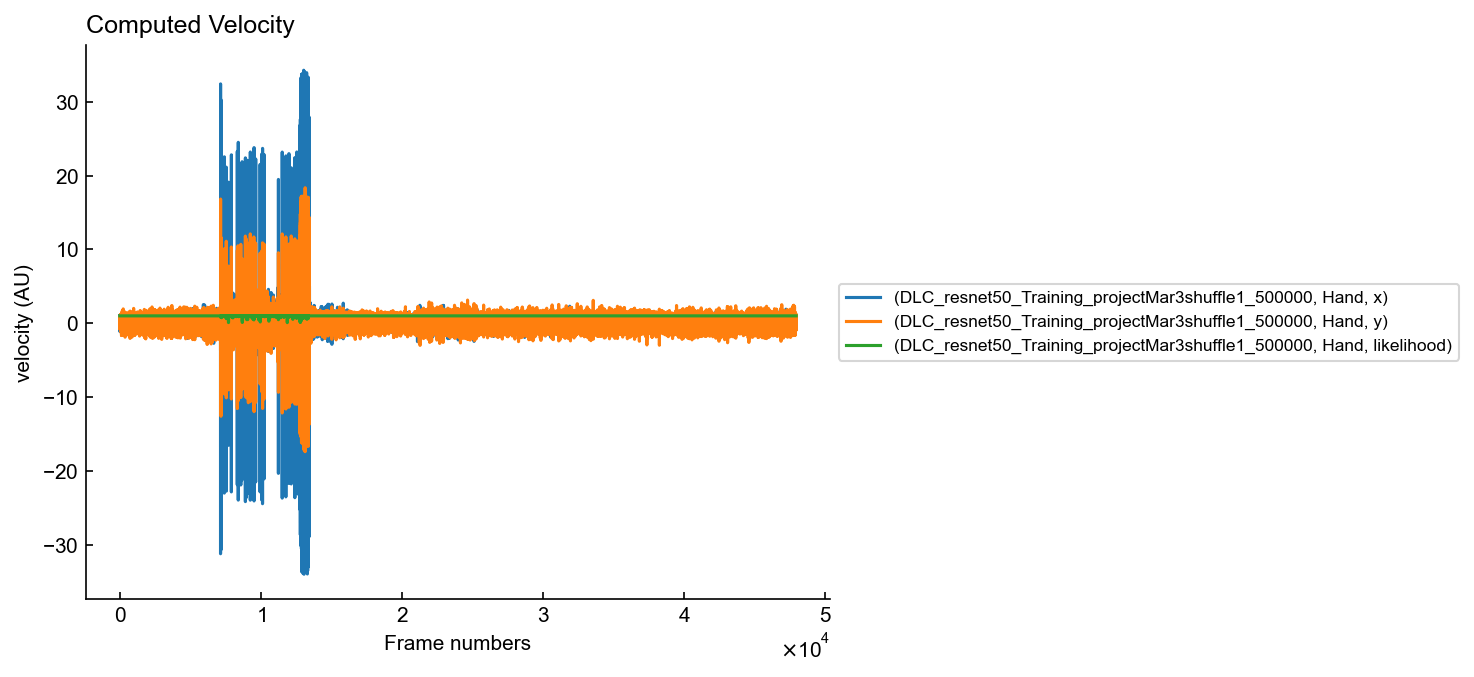

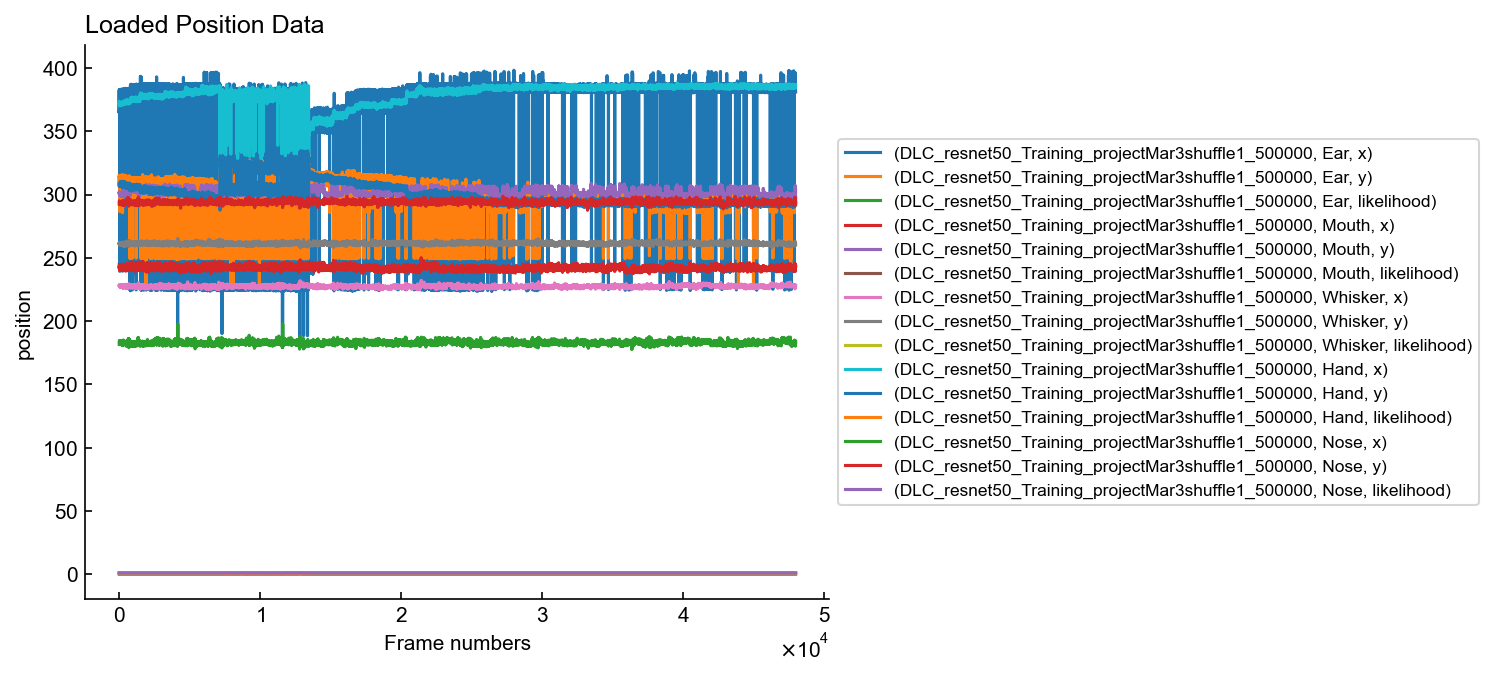

In [10]:
df_vel_hand = dlc2kinematics.compute_velocity(df3,bodyparts=['Hand'])
%matplotlib inline
dlc2kinematics.plot_velocity(df3, df_vel_hand)

In [11]:
df_speed_Mouth3

scorer    DLC_resnet50_Training_projectMar3shuffle1_500000           
bodyparts                                            Mouth           
coords                                               speed likelihood
0                                                 1.552724        1.0
1                                                 1.552724        1.0
2                                                 0.720941        1.0
3                                                 0.517819        1.0
4                                                 0.354592        1.0
...                                                    ...        ...
47950                                             0.748266        1.0
47951                                             0.569151        1.0
47952                                             0.614564        1.0
47953                                             1.046604        1.0
47954                                             1.046604        1.0

[47955 rows x 2 columns]

In [12]:
df_speed_Hand3.iloc[:,0]

0        1.240683
1        1.240683
2        0.755329
3        0.517928
4        0.528903
           ...   
47950    0.527930
47951    1.368930
47952    0.180016
47953    0.428340
47954    0.428340
Name: (DLC_resnet50_Training_projectMar3shuffle1_500000, Hand, speed), Length: 47955, dtype: float64

In [13]:
#Create speed numpy array for each body part
speed_Hand3 = df_speed_Hand3.iloc[:,0].to_numpy()
print(np.median(speed_Hand3))
speed_Mouth3 = df_speed_Mouth3.iloc[:,0].to_numpy()
print(np.median(speed_Mouth3))
speed_Nose3 = df_speed_Nose3.iloc[:,0].to_numpy()
print(np.median(speed_Nose3))
speed_Whisker3 = df_speed_Whisker3.iloc[:,0].to_numpy()
print(np.median(speed_Whisker3))

0.6955070936552264
0.6168661511264609
0.5223573709051211
0.3832671791582503


In [14]:
#Create arrays for camera recording 3002(NOT USED in this analysis)
timefile2=np.load('C:\\Users\insan\\Desktop\\IR Camera Videos\\Day 9\\AE_231_2\TIMESTAMPS_CogRig_AE_231_2023-02-14_2.npy')
dataname2 = 'C:\\Users\insan\\Desktop\\IR Camera Videos\\Day 9\\AE_231_2\\CogRig_AE_231_2023-02-14_2DLC_resnet50_Training_projectMar3shuffle1_500000.h5'
dataframe2 = pd.read_hdf(os.path.join(dataname2))
df_Hand2 = dataframe2.iloc[:,9:11]
df2, bodyparts, scorer = dlc2kinematics.load_data(dataname2)
df_speed_Hand2 = dlc2kinematics.compute_speed(df2,bodyparts=['Hand'])
hand2_x = df_Hand2.iloc[:,0].to_numpy()
hand2_y = df_Hand2.iloc[:,1].to_numpy()
speed_Hand2 = df_speed_Hand2.iloc[:,0].to_numpy()

In [15]:
#about 1s = 100 frames,25s = 2500frames

In [16]:
#Create time array for timefile3
timefile3=np.load('C:\\Users\insan\\Desktop\\IR Camera Videos\\Day 9\\AE_231_3\\TIMESTAMPS_CogRig_AE_231_2023-02-14_3.npy')
timefile3_arr = np.array(timefile3)

import datetime
video_timestamp3 = []
for unix_time in timefile3:
    time = datetime.datetime.fromtimestamp(unix_time).strftime('%Y-%m-%d %H:%M:%S')
    video_timestamp3.append(time)

#test
print(timefile3[0])
print(video_timestamp3[0])


1676410762.3275287
2023-02-14 16:39:22


In [17]:

#Create important time point variables for AE_231_02_14_23_3001,3002,3003

#first neural session start time:2023	2	2	14	21	21	42	100 = 1676409702.100
#second neural session start time:2023	2	2	14	21	30	41	94 = 1676410241.094
#third neural session start time: 2023	2	2	14	21	39	23	380 = 1676410763.380
neural_s1_start_date = 1676409702.100
neural_s2_start_date = 1676410241.094
neural_s3_start_date = 1676410763.380

neural_s1_duration = 527.3762
neural_s2_duration = 511.0905

neural_s1_end_date = neural_s1_start_date + neural_s1_duration
neural_s2_end_date = neural_s2_start_date + neural_s2_duration

s1_s2_between_duration = neural_s2_start_date - neural_s1_end_date
s2_s3_between_duration = neural_s3_start_date - neural_s2_end_date


In [18]:
s3_start_second = neural_s3_start_date - s1_s2_between_duration -s2_s3_between_duration - neural_s1_start_date

In [19]:
s3_start_second

1038.4667000770569

In [20]:
s3_start_samples = s3_start_second*30000

In [21]:
trials_start = sessionfile_D9.trials.starts
trials_end = sessionfile_D9.trials.ends

trial_window = np.zeros((len(trials_start),2))

for idx in range(len(trial_window)):
    trial_window[idx][0] = trials_start[idx]
    trial_window[idx][1] = trials_end[idx]
    
trial_window_3003 = trial_window[-100:]
trial_start_3003 = trials_start[-100:]

response_time = sessionfile_D9.trials.response
reward_time = sessionfile_D9.behavior.reward_times

In [22]:
print(neural_s3_start_date)
print(timefile3[105])
print(timefile3[106])

print(timefile3[105]-neural_s3_start_date)
print(timefile3[106]-neural_s3_start_date)

video3003_start_frame = 105

1676410763.38
1676410763.3777246
1676410763.387698
-0.0022754669189453125
0.0076978206634521484


In [23]:
#Mouth  

In [24]:
move_3003_start_date = timefile3 - s1_s2_between_duration - s2_s3_between_duration
move_3003_start_seconds = move_3003_start_date - neural_s1_start_date
move_3003_start_samples = move_3003_start_seconds*30000

In [25]:
#window is set to be 100 frames
mouth_speed_diff_3003_arr = []
for frame_idx,speed in enumerate(speed_Mouth3):
    if frame_idx>video3003_start_frame-1:
        speed_diff = np.mean(speed_Mouth3[frame_idx:frame_idx+100])-np.mean(speed_Mouth3[frame_idx-100:frame_idx])
        mouth_speed_diff_3003_arr.append(speed_diff)
        
mouth_speed_diff_3003_arr = np.array(mouth_speed_diff_3003_arr)
print(len(mouth_speed_diff_3003_arr))

47850


In [26]:
mouth_speed_3003_std = np.std(mouth_speed_diff_3003_arr)
mouth_speed_3003_mean = np.mean(mouth_speed_diff_3003_arr)
mouth_interval1 = mouth_speed_3003_mean+mouth_speed_3003_std*2
mouth_interval2 = mouth_speed_3003_mean+mouth_speed_3003_std*2*-1
print(mouth_interval1)

0.2177981998988202


In [27]:
mouth_major_speed = []
for speed in mouth_speed_diff_3003_arr:
    if speed<mouth_interval1 and speed>mouth_interval2:
        mouth_major_speed.append(speed)
        
print(len(mouth_major_speed))
print(45290/47855)

45285
0.9464005851008254


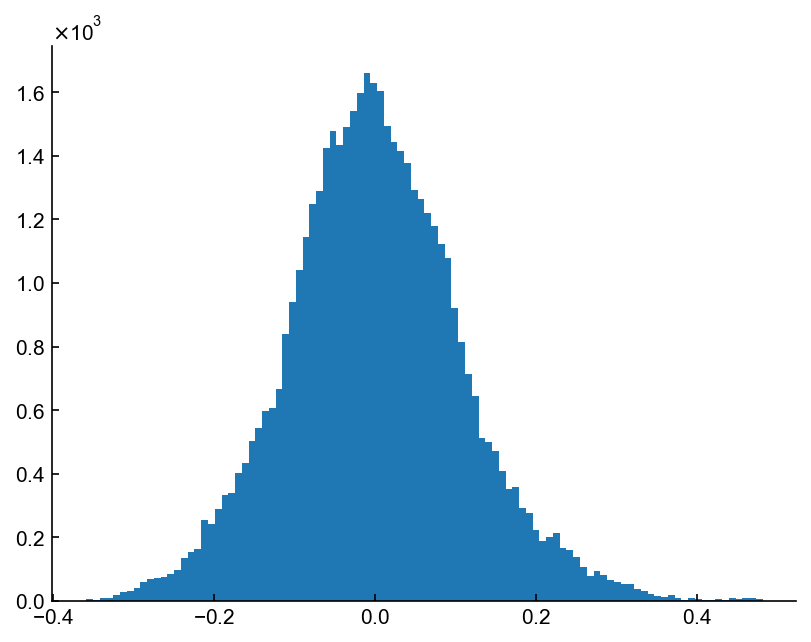

In [28]:
plt.hist(mouth_speed_diff_3003_arr,bins=100)
plt.show()

In [29]:
mouth_fast_3003 = []
for frame_idx,speed in enumerate(speed_Mouth3):
    if frame_idx>video3003_start_frame-1:
        if np.mean(speed_Mouth3[frame_idx:frame_idx+100])-np.mean(speed_Mouth3[frame_idx-100:frame_idx])>mouth_interval1:
            mouth_fast_3003.append(frame_idx)
            
mouth_fast_3003 = np.array(mouth_fast_3003)           
 
print(len(mouth_fast_3003))     
print(mouth_fast_3003)

1549
[  381   382   383 ... 47952 47953 47954]


In [30]:
mouth_fast_3003[100:300]

array([ 4578,  4579,  4580,  4581,  4582,  4583,  4584,  4585,  4587,
        4588,  4589,  4590,  4591,  4592,  4593,  4594,  4597,  4598,
        4599,  4600,  4601,  4602,  4603,  4604,  4605,  4606,  4607,
        4608,  4609,  4610,  4611,  4612,  4613,  4614,  4615,  4616,
        4617,  4618,  4619,  4620,  4621,  4622,  4623,  4624,  4625,
        4626,  4627,  4628,  4629,  4630,  4631,  4632,  4633,  4634,
        4635,  4636,  4637,  4638,  4639,  4640,  4641,  4642,  4643,
        4644,  4645,  4646,  4647,  4648,  4649,  4650,  4651,  4652,
        4653,  4654,  4655,  4656,  4657,  4658,  4659,  4660,  4661,
        4662,  4663,  4664,  4665,  4666,  4667,  4668,  4669,  5790,
        5791,  5792,  5793,  5794,  5795,  5796,  5797,  5798,  5799,
        5800,  5801,  5802,  5803,  5804,  5805,  5806,  5807,  5808,
        5809,  5810,  5811,  5812,  5813,  5814,  5815,  5816,  5817,
        5818,  5820,  5821,  5822,  5823,  5824,  5825,  5826,  5827,
        5828,  5829,

In [31]:
threshold = 100
diff_mouth_fast_3003 = np.abs(np.diff(mouth_fast_3003))
mask_mouth_fast_3003 = np.concatenate(([True],(diff_mouth_fast_3003>100)|(diff_mouth_fast_3003==0),[True]))
new_mouth_fast_3003 = mouth_fast_3003[mask_mouth_fast_3003[:-1]]
new_mouth_fast_3003 = new_mouth_fast_3003[:-1]
print(len(new_mouth_fast_3003))
print(new_mouth_fast_3003)

41
[  381  3015  4261  4576  5790  7578  7910  9182 12125 12681 14105 15154
 15839 19271 21241 21852 22071 23899 24122 24651 25888 26366 26585 27152
 27407 28079 28696 29407 29937 30283 31373 35437 36297 37003 37534 38108
 38665 40385 42240 43965 46720]


In [32]:
mouth_3003_movement_onset_samples_arr = []
for frames in new_mouth_fast_3003:
    mouth_3003_movement_onset_samples = move_3003_start_samples[frames]
    mouth_3003_movement_onset_samples_arr.append(mouth_3003_movement_onset_samples)

mouth_3003_movement_onset_samples_arr = np.array(mouth_3003_movement_onset_samples_arr)

print(len(mouth_3003_movement_onset_samples_arr))



41


In [33]:
mouth_3003_movement_onset = np.array(new_mouth_fast_3003)
mouth_3003_window1_start = mouth_3003_movement_onset - 200
mouth_3003_window2_start = mouth_3003_movement_onset - 100
mouth_3003_movement_offset = mouth_3003_movement_onset + 100
mouth_3003_movement_offset2 = mouth_3003_movement_onset + 200

mouth_3003_window_arr = np.zeros((len(mouth_3003_movement_onset),5))
for idx in range(len(mouth_3003_movement_onset)):
    mouth_3003_window_arr[idx][0] = mouth_3003_window1_start[idx]
    mouth_3003_window_arr[idx][1] = mouth_3003_window2_start[idx]
    mouth_3003_window_arr[idx][2] = mouth_3003_movement_onset[idx]
    mouth_3003_window_arr[idx][3] = mouth_3003_movement_offset[idx]
    mouth_3003_window_arr[idx][4] = mouth_3003_movement_offset2[idx]

In [34]:
print(mouth_3003_movement_onset) #units = frames

[  381  3015  4261  4576  5790  7578  7910  9182 12125 12681 14105 15154
 15839 19271 21241 21852 22071 23899 24122 24651 25888 26366 26585 27152
 27407 28079 28696 29407 29937 30283 31373 35437 36297 37003 37534 38108
 38665 40385 42240 43965 46720]


In [35]:
speed_Mouth3[381]

0.7342575270095827

In [36]:
###important function for all body part
def calculate_delta_speed(speed_arr,window1_start,window2_start,movement_onset,movement_offset,movement_offset2):
    speed_mean = np.mean(speed_arr[window1_start:window2_start])
                                   
    delta_speed_arr = []
    for speed in speed_arr[window1_start:movement_offset2]:
        delta_speed = speed #- speed_mean
        delta_speed_arr.append(delta_speed)
        
    delta_speed_arr = np.array(delta_speed_arr)
    #print(delta_speed_arr[200])
    return delta_speed_arr

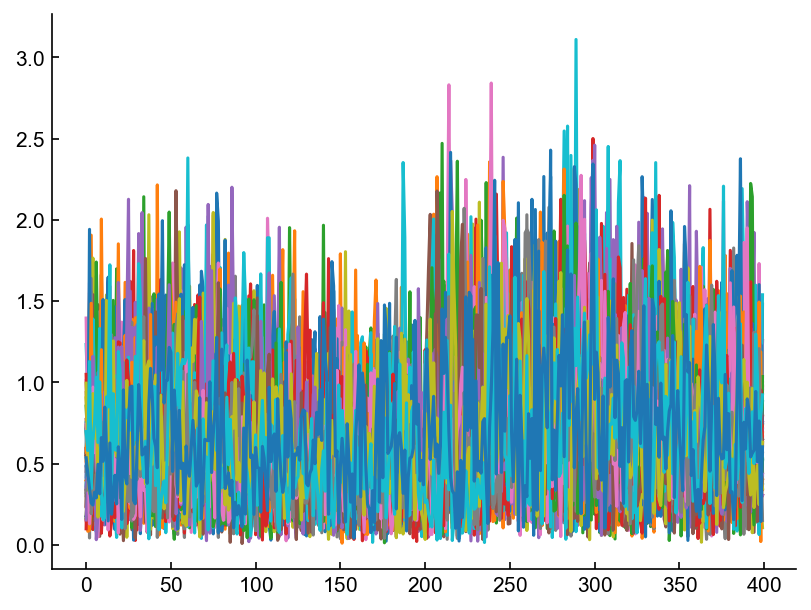

In [37]:
mouth_3003_delta_speed_arr = []
for idx in range(len(mouth_3003_window_arr)):
    delta_speed = calculate_delta_speed(speed_Mouth3,int(mouth_3003_window_arr[idx][0]),int(mouth_3003_window_arr[idx][1]),int(mouth_3003_window_arr[idx][2]),int(mouth_3003_window_arr[idx][3]),int(mouth_3003_window_arr[idx][4]))
    plt.plot(delta_speed)
    mouth_3003_delta_speed_arr.append(delta_speed)



In [38]:
print(len( mouth_3003_delta_speed_arr[0]))
print(len( mouth_3003_delta_speed_arr))

400
41


In [39]:
avg_mouth_3003_speed = np.array(mouth_3003_delta_speed_arr)
sem_mouth_3003_speed = sem(mouth_3003_delta_speed_arr,axis = 0)
#print(sem_mouth_3003_speed)

C:\Users\insan\AppData\Local\Temp\ipykernel_14348\1817317620.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['-200','-150','-100','-50','0','50','100','150','200'])


Text(240, 0.4, 'fast')

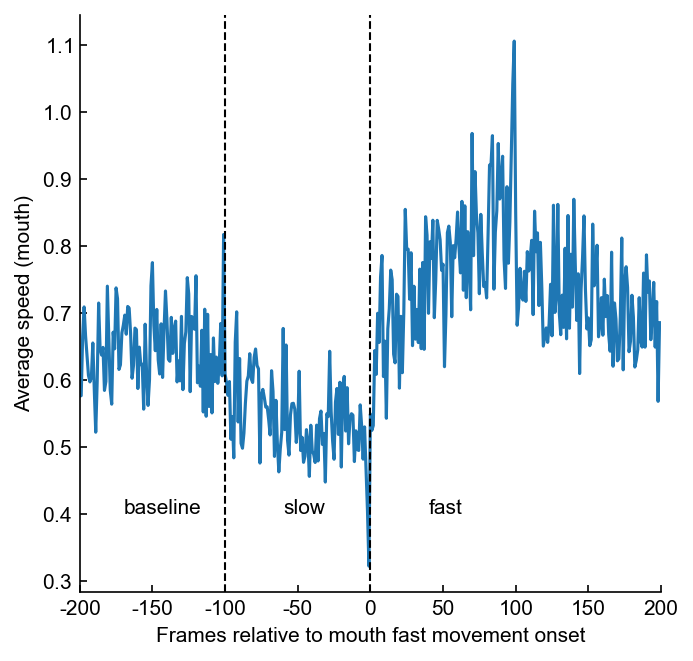

In [40]:
avg_mouth_3003_speed = np.mean(avg_mouth_3003_speed,axis = 0)

size=5

fig,ax = plt.subplots(figsize=(5,5))
ax.plot(avg_mouth_3003_speed)
ax.set_xlim([0,400])
ax.set_xticklabels(['-200','-150','-100','-50','0','50','100','150','200'])
ax.set_ylabel('Average speed (mouth)')
ax.set_xlabel('Frames relative to mouth fast movement onset')
ax.axvline(100,color='black',linestyle='--',zorder=10,lw=1)
ax.axvline(200,color='black',linestyle='--',zorder=10,lw=1)
ax.text(30,0.4,'baseline')
ax.text(140,0.4,'slow')
ax.text(240,0.4,'fast')
#fig.savefig(os.path.join('C:\\Users\insan\\Desktop\\Movement figures\\Mouth_Movement_3003.png'),transparent=False,facecolor="white")
   

In [41]:
mouth_avg_slow_speed_arr = []
mouth_avg_fast_speed_arr = []
for frame_idx in mouth_3003_movement_onset:
    mouth_avg_slow_speed = np.mean(speed_Mouth3[frame_idx-100:frame_idx])
    mouth_avg_slow_speed_arr.append(mouth_avg_slow_speed)
    mouth_avg_fast_speed = np.mean(speed_Mouth3[frame_idx:frame_idx+100])
    mouth_avg_fast_speed_arr.append(mouth_avg_fast_speed)

mouth_move_speed_period = np.zeros((len(mouth_avg_fast_speed_arr),2))

for idx in range(len(mouth_avg_fast_speed_arr)):
    mouth_move_speed_period[idx][0] = mouth_avg_slow_speed_arr[idx]
    mouth_move_speed_period[idx][1] = mouth_avg_fast_speed_arr[idx]
    
mouth_move_speed_period

array([[0.53814199, 0.75604159],
       [0.59988547, 0.81951117],
       [0.67570082, 0.89954652],
       [0.58018329, 0.80388414],
       [0.63477441, 0.85875271],
       [0.5812129 , 0.81646775],
       [0.56018862, 0.78913722],
       [0.53334468, 0.75398953],
       [0.62179746, 0.84088553],
       [0.6540223 , 0.87938573],
       [0.63154285, 0.86092333],
       [0.65678423, 0.88529406],
       [0.57959933, 0.8184195 ],
       [0.4956931 , 0.71493868],
       [0.53498889, 0.76172883],
       [0.5413558 , 0.76491211],
       [0.60095621, 0.8215851 ],
       [0.49169006, 0.7165866 ],
       [0.45490089, 0.67521868],
       [0.43186581, 0.65192433],
       [0.56488971, 0.787728  ],
       [0.48513598, 0.70772272],
       [0.54321103, 0.76397972],
       [0.47945956, 0.70338211],
       [0.46307374, 0.68547422],
       [0.40016381, 0.62633967],
       [0.53626657, 0.7589382 ],
       [0.55779716, 0.77877664],
       [0.56671857, 0.79327002],
       [0.59923284, 0.82881084],
       [0.

In [42]:
#Whisker

In [43]:
whisker_speed_diff_3003_arr = []
for frame_idx,speed in enumerate(speed_Whisker3):
    if frame_idx>video3003_start_frame-1:
        speed_diff = np.mean(speed_Whisker3[frame_idx:frame_idx+100])-np.mean(speed_Whisker3[frame_idx-100:frame_idx])
        whisker_speed_diff_3003_arr.append(speed_diff)
        
whisker_speed_diff_3003_arr = np.array(whisker_speed_diff_3003_arr)
print(len(whisker_speed_diff_3003_arr))

47850


In [44]:
whisker_speed_3003_std = np.std(whisker_speed_diff_3003_arr)
whisker_speed_3003_mean = np.mean(whisker_speed_diff_3003_arr)
whisker_interval1 = whisker_speed_3003_mean+whisker_speed_3003_std*2
whisker_interval2 = whisker_speed_3003_mean+whisker_speed_3003_std*-2
print(whisker_speed_3003_mean)
print(whisker_interval1)
print(whisker_interval2)

6.087510376365284e-05
0.10794087851800999
-0.10781912831048268


In [45]:
whisker_major_speed = []
for speed in whisker_speed_diff_3003_arr:
    if speed<whisker_interval1 and speed>whisker_interval2:
        whisker_major_speed.append(speed)
        
print(len(whisker_major_speed))
print(45454/47855)

45449
0.9498276042210845


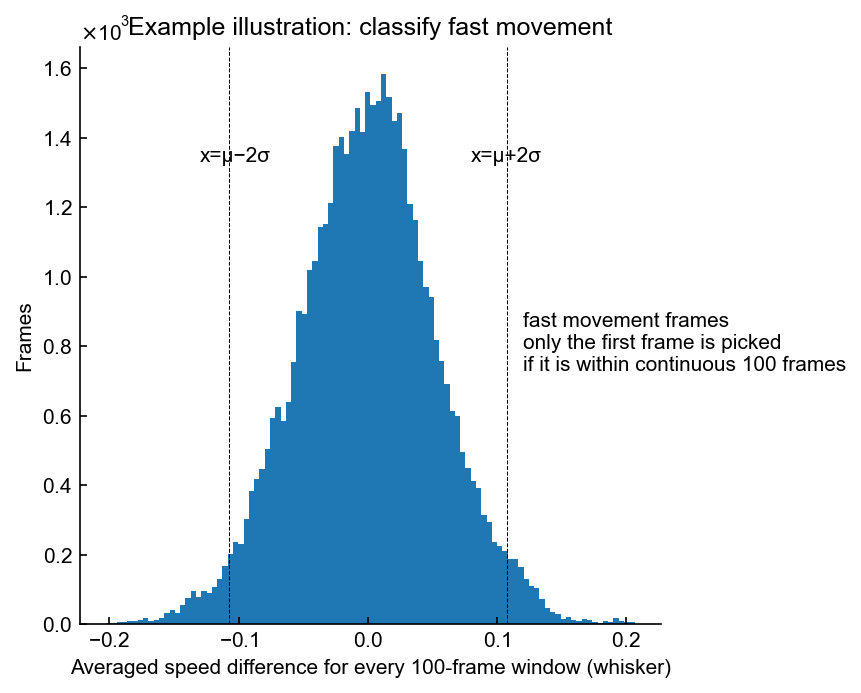

In [46]:

size=5

fig,ax = plt.subplots(figsize=(5,5))
plt.title('Example illustration: classify fast movement')
plt.hist(whisker_speed_diff_3003_arr,bins=100)
plt.xlabel('Averaged speed difference for every 100-frame window (whisker)')
plt.ylabel('Frames')
plt.axvline(whisker_interval2,color='black',linestyle='--',zorder=10,lw=0.5)
plt.axvline(whisker_interval1,color='black',linestyle='--',zorder=10,lw=0.5)
plt.text(-0.13,11**3,'x=μ−2σ')
plt.text(0.08,11**3,'x=μ+2σ')
plt.text(0.12,9**3,'fast movement frames'+'\n'+'only the first frame is picked'+'\n'+'if it is within continuous 100 frames')
plt.show()
#fig.savefig(os.path.join('C:\\Users\insan\\Desktop\\Movement figures\\classify movement example.png'),transparent=False,facecolor="white")

1254
[  417  1475  1476 ... 47899 47900 47901]
48
[  417  1475  3243  4071  4549  5036  5257  6845  7044  7569  7918  9806
 11526 12455 12665 12994 13886 15015 17038 17227 17918 18642 19950 20632
 21246 21505 22834 23100 23509 23902 25554 26338 27145 27831 28653 33359
 34194 35475 35701 36253 37042 38043 39119 39393 39762 40423 42492 43065]
48
[  417  1475  3243  4071  4549  5036  5257  6845  7044  7569  7918  9806
 11526 12455 12665 12994 13886 15015 17038 17227 17918 18642 19950 20632
 21246 21505 22834 23100 23509 23902 25554 26338 27145 27831 28653 33359
 34194 35475 35701 36253 37042 38043 39119 39393 39762 40423 42492 43065]


C:\Users\insan\AppData\Local\Temp\ipykernel_14348\1555747794.py:62: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['-200','-150','-100','-50','0','50','100','150','200'])


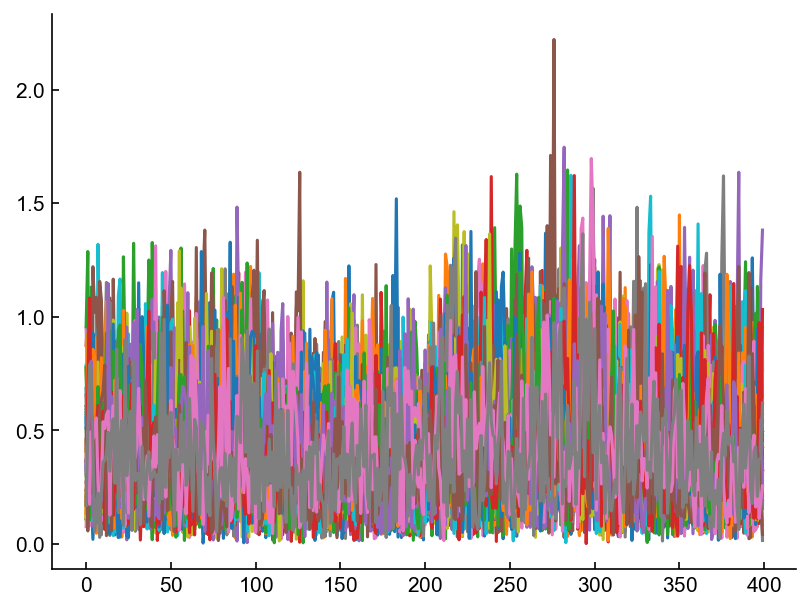

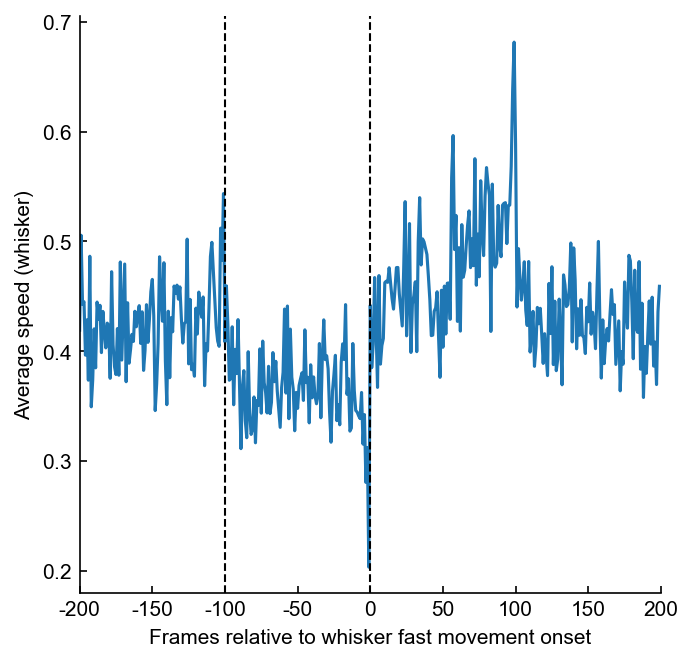

In [47]:
whisker_fast_3003 = []
for frame_idx,speed in enumerate(speed_Whisker3):
    if frame_idx>video3003_start_frame-1:
        if np.mean(speed_Whisker3[frame_idx:frame_idx+100])-np.mean(speed_Whisker3[frame_idx-100:frame_idx])>whisker_interval1:
            whisker_fast_3003.append(frame_idx)
            
whisker_fast_3003 = np.array(whisker_fast_3003)           
 
print(len(whisker_fast_3003))     
print(whisker_fast_3003)

threshold = 100
diff_whisker_fast_3003 = np.abs(np.diff(whisker_fast_3003))
mask_whisker_fast_3003 = np.concatenate(([True],(diff_whisker_fast_3003>100)|(diff_whisker_fast_3003==0),[True]))
new_whisker_fast_3003 = whisker_fast_3003[mask_whisker_fast_3003[:-1]]
new_whisker_fast_3003 = new_whisker_fast_3003[:-1]
print(len(new_whisker_fast_3003))
print(new_whisker_fast_3003)

whisker_3003_movement_onset_samples_arr = []
for frames in new_whisker_fast_3003:
    whisker_3003_movement_onset_samples = move_3003_start_samples[frames]
    whisker_3003_movement_onset_samples_arr.append(whisker_3003_movement_onset_samples)

whisker_3003_movement_onset_samples_arr = np.array(whisker_3003_movement_onset_samples_arr)

print(len(whisker_3003_movement_onset_samples_arr))


whisker_3003_movement_onset = np.array(new_whisker_fast_3003)
whisker_3003_window1_start = whisker_3003_movement_onset - 200
whisker_3003_window2_start = whisker_3003_movement_onset - 100
whisker_3003_movement_offset = whisker_3003_movement_onset + 100
whisker_3003_movement_offset2 = whisker_3003_movement_onset + 200

whisker_3003_window_arr = np.zeros((len(whisker_3003_movement_onset),5))
for idx in range(len(whisker_3003_movement_onset)):
    whisker_3003_window_arr[idx][0] = whisker_3003_window1_start[idx]
    whisker_3003_window_arr[idx][1] = whisker_3003_window2_start[idx]
    whisker_3003_window_arr[idx][2] = whisker_3003_movement_onset[idx]
    whisker_3003_window_arr[idx][3] = whisker_3003_movement_offset[idx]
    whisker_3003_window_arr[idx][4] = whisker_3003_movement_offset2[idx]
    
print(whisker_3003_movement_onset) #units = frames

whisker_3003_delta_speed_arr = []
for idx in range(len(whisker_3003_window_arr)):
    delta_speed = calculate_delta_speed(speed_Whisker3,int(whisker_3003_window_arr[idx][0]),int(whisker_3003_window_arr[idx][1]),int(whisker_3003_window_arr[idx][2]),int(whisker_3003_window_arr[idx][3]),int(whisker_3003_window_arr[idx][4]))
    plt.plot(delta_speed)
    whisker_3003_delta_speed_arr.append(delta_speed)


avg_whisker_3003_speed = np.array(whisker_3003_delta_speed_arr)
sem_whisker_3003_speed = sem(whisker_3003_delta_speed_arr,axis = 0)
avg_whisker_3003_speed = np.mean(avg_whisker_3003_speed,axis = 0)

size=5

fig,ax = plt.subplots(figsize=(5,5))
ax.plot(avg_whisker_3003_speed)
ax.set_xlim([0,400])
ax.set_xticklabels(['-200','-150','-100','-50','0','50','100','150','200'])
ax.set_ylabel('Average speed (whisker)')
ax.set_xlabel('Frames relative to whisker fast movement onset')
ax.axvline(100,color='black',linestyle='--',zorder=10,lw=1)
ax.axvline(200,color='black',linestyle='--',zorder=10,lw=1)
# ax.text(140,0.6,'slow')
# ax.text(240,0.6,'fast')
#fig.savefig(os.path.join('C:\\Users\insan\\Desktop\\Movement figures\\Whisker_Movement_3003.png'),transparent=False,facecolor="white")

In [48]:
#Nose

In [49]:
nose_speed_diff_3003_arr = []
for frame_idx,speed in enumerate(speed_Nose3):
    if frame_idx>video3003_start_frame-1:
        speed_diff = np.mean(speed_Nose3[frame_idx:frame_idx+100])-np.mean(speed_Nose3[frame_idx-100:frame_idx])
        nose_speed_diff_3003_arr.append(speed_diff)
        
nose_speed_diff_3003_arr = np.array(nose_speed_diff_3003_arr)
print(len(nose_speed_diff_3003_arr))

47850


In [50]:
nose_speed_3003_std = np.std(nose_speed_diff_3003_arr)
nose_speed_3003_mean = np.mean(nose_speed_diff_3003_arr)
nose_interval1 = nose_speed_3003_mean+nose_speed_3003_std*2
nose_interval2 = nose_speed_3003_mean+nose_speed_3003_std*2*-1
print(nose_speed_3003_mean)
print(nose_interval1)

0.0002534339015318363
0.1387815545739254


In [51]:
nose_major_speed = []
for speed in nose_speed_diff_3003_arr:
    if speed<nose_interval1 and speed>nose_interval2:
        nose_major_speed.append(speed)
        
print(len(nose_major_speed))
print(46245/47855)

46241
0.9663567025389197


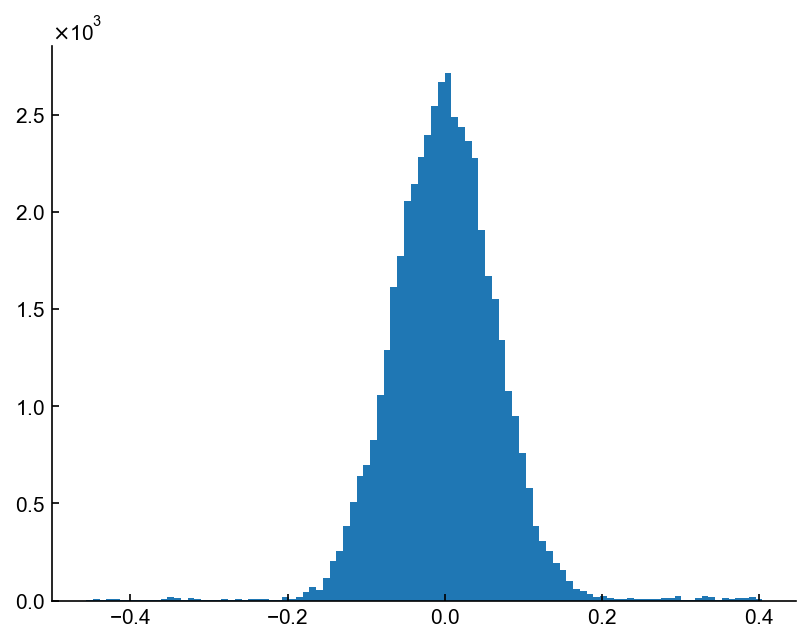

In [52]:
plt.hist(nose_speed_diff_3003_arr,bins=100)
plt.show()

891
[ 4053  4054  4055  4056  4057  4058  4059  4060  4061  4062  4063  4064
  4065  4066  4067  4068  4069  4070  4071  4072  4073  4074  4075  4076
  4077  4078  4079  4080  4081  4082  4083  4084  4085  4086  4087  4088
  4089  4090  4091  4092  4093  4094  4095  4096  4097  4098  4099  4100
  4101  4102  4103  4104  4105  4106  4107  4108  4109  4110  4111  4112
  4113  4114  4115  4116  4117  4118  4119  4120  4121  4122  4123  4124
  4125  4126  4127  4128  4129  4130  4131  4132  4133  4134  4135  4136
  4137  4138  4139  4140  4141  4142  4143  4144  4145  4146  4147  4148
  4149  4150  4151  4152  4759  4760  4763  4766  4767  4768  4769  4770
  4772  6287  6288  6299  6300  6301  6302  6303  6817  6818  6819  6820
  6821  6822  6823  6824  6825  6826  6827  6828  6829  6830  6831  6832
  6833  6834  6835  6836  6837  6839  6840  6842  6843  6844  6845  6846
  6847  6848  6849  6850  6851  6852  6853  6854  6855  6856  6857  6858
  6859  6860  6861  6862  8898  8919  8920  892

C:\Users\insan\AppData\Local\Temp\ipykernel_14348\3653374138.py:62: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['-200','-150','-100','-50','0','50','100','150','200'])


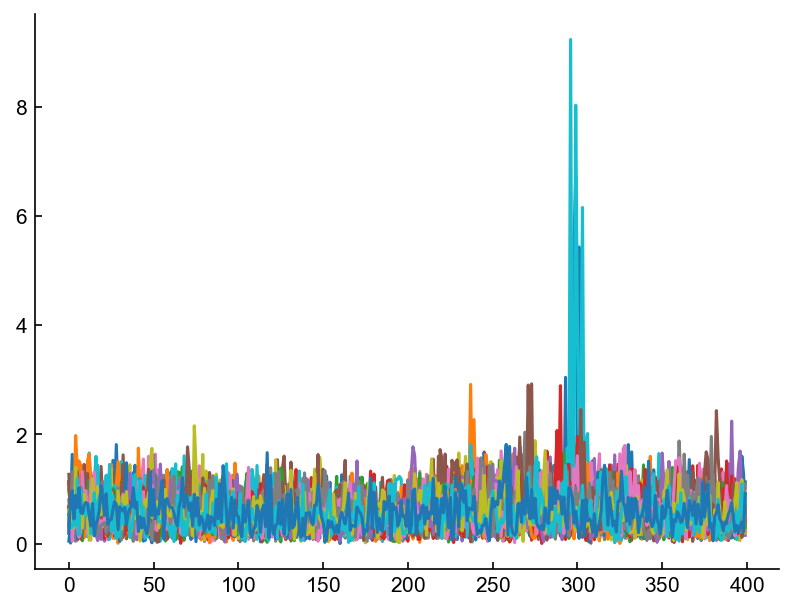

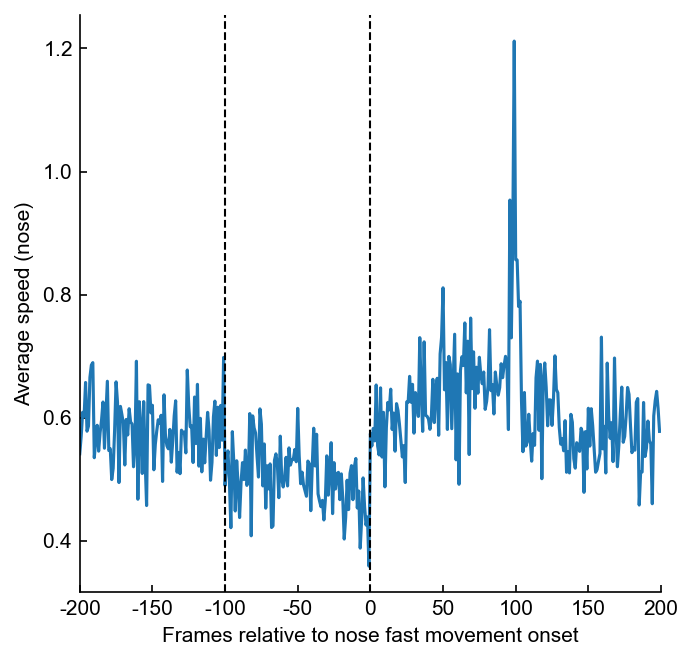

In [53]:
nose_fast_3003 = []
for frame_idx,speed in enumerate(speed_Nose3):
    if frame_idx>video3003_start_frame-1:
        if np.mean(speed_Nose3[frame_idx:frame_idx+100])-np.mean(speed_Nose3[frame_idx-100:frame_idx])>nose_interval1:
            nose_fast_3003.append(frame_idx)
            
nose_fast_3003 = np.array(nose_fast_3003)           
 
print(len(nose_fast_3003))     
print(nose_fast_3003)

threshold = 100
diff_nose_fast_3003 = np.abs(np.diff(nose_fast_3003))
mask_nose_fast_3003 = np.concatenate(([True],(diff_nose_fast_3003>100)|(diff_nose_fast_3003==0),[True]))
new_nose_fast_3003 = nose_fast_3003[mask_nose_fast_3003[:-1]]
new_nose_fast_3003 = new_nose_fast_3003[:-1]
print(len(new_nose_fast_3003))
print(new_nose_fast_3003)

nose_3003_movement_onset_samples_arr = []
for frames in new_nose_fast_3003:
    nose_3003_movement_onset_samples = move_3003_start_samples[frames]
    nose_3003_movement_onset_samples_arr.append(nose_3003_movement_onset_samples)

nose_3003_movement_onset_samples_arr = np.array(nose_3003_movement_onset_samples_arr)

print(len(nose_3003_movement_onset_samples_arr))


nose_3003_movement_onset = np.array(new_nose_fast_3003)
nose_3003_window1_start = nose_3003_movement_onset - 200
nose_3003_window2_start = nose_3003_movement_onset - 100
nose_3003_movement_offset = nose_3003_movement_onset + 100
nose_3003_movement_offset2 = nose_3003_movement_onset + 200

nose_3003_window_arr = np.zeros((len(nose_3003_movement_onset),5))
for idx in range(len(nose_3003_movement_onset)):
    nose_3003_window_arr[idx][0] = nose_3003_window1_start[idx]
    nose_3003_window_arr[idx][1] = nose_3003_window2_start[idx]
    nose_3003_window_arr[idx][2] = nose_3003_movement_onset[idx]
    nose_3003_window_arr[idx][3] = nose_3003_movement_offset[idx]
    nose_3003_window_arr[idx][4] = nose_3003_movement_offset2[idx]
    
print(nose_3003_movement_onset) #units = frames

nose_3003_delta_speed_arr = []
for idx in range(len(nose_3003_window_arr)):
    delta_speed = calculate_delta_speed(speed_Nose3,int(nose_3003_window_arr[idx][0]),int(nose_3003_window_arr[idx][1]),int(nose_3003_window_arr[idx][2]),int(nose_3003_window_arr[idx][3]),int(nose_3003_window_arr[idx][4]))
    plt.plot(delta_speed)
    nose_3003_delta_speed_arr.append(delta_speed)


avg_nose_3003_speed = np.array(nose_3003_delta_speed_arr)
sem_nose_3003_speed = sem(nose_3003_delta_speed_arr,axis = 0)
avg_nose_3003_speed = np.mean(avg_nose_3003_speed,axis = 0)

size=5

fig,ax = plt.subplots(figsize=(5,5))
ax.plot(avg_nose_3003_speed)
ax.set_xlim([0,400])
ax.set_xticklabels(['-200','-150','-100','-50','0','50','100','150','200'])
ax.set_ylabel('Average speed (nose)')
ax.set_xlabel('Frames relative to nose fast movement onset')
ax.axvline(100,color='black',linestyle='--',zorder=10,lw=1)
ax.axvline(200,color='black',linestyle='--',zorder=10,lw=1)
#fig.savefig(os.path.join('C:\\Users\insan\\Desktop\\Movement figures\\Nose_3003.png'),transparent=False,facecolor="white")

In [54]:
print(len(nose_3003_movement_onset_samples_arr))
print(len(whisker_3003_movement_onset_samples_arr))
print(len(mouth_3003_movement_onset_samples_arr))

integrate_3003_movement_onset_samples_arr = np.concatenate((mouth_3003_movement_onset_samples_arr,whisker_3003_movement_onset_samples_arr,nose_3003_movement_onset_samples_arr))
len(integrate_3003_movement_onset_samples_arr)

31
48
41


120

In [55]:
#FINAL DON'T DELETE
s3_start_samples

31154001.002311707

In [56]:
move_3003_start_samples

array([31122426.86033249, 31122755.98526001, 31123055.17673492, ...,
       45508674.00884628, 45508973.2003212 , 45509272.377491  ])

In [57]:
sessionfile_D9.meta.files

['February 14 2023 AC Tuning AE_231_3001',
 'February 14 2023 AC Tuning AE_231_3002',
 'February 14 2023 AC Tuning AE_231_3003',
 'February 14 2023 AC Tuning AE_231_3004']

In [58]:
Trial_time_samples = 2.5*30000

In [59]:
np.set_printoptions(suppress=True)

In [60]:
mouth_avg_slow_speed_arr = []
mouth_avg_fast_speed_arr = []
for frame_idx in new_mouth_fast_3003:
    mouth_avg_slow_speed = np.mean(speed_Mouth3[frame_idx-100:frame_idx])
    mouth_avg_slow_speed_arr.append(mouth_avg_slow_speed)
    mouth_avg_fast_speed = np.mean(speed_Mouth3[frame_idx:frame_idx+100])
    mouth_avg_fast_speed_arr.append(mouth_avg_fast_speed)

print(np.mean(speed_Mouth3))
print(np.mean(mouth_avg_slow_speed_arr))
print(np.mean(mouth_avg_fast_speed_arr))

mouth_move_speed_period = np.zeros((len(mouth_avg_fast_speed_arr),2))

for idx in range(len(mouth_avg_fast_speed_arr)):
    mouth_move_speed_period[idx][0] = mouth_avg_slow_speed_arr[idx]
    mouth_move_speed_period[idx][1] = mouth_avg_fast_speed_arr[idx]
    
mouth_move_speed_period

0.6813435210525973
0.542766291117966
0.7666048878008547


array([[0.53814199, 0.75604159],
       [0.59988547, 0.81951117],
       [0.67570082, 0.89954652],
       [0.58018329, 0.80388414],
       [0.63477441, 0.85875271],
       [0.5812129 , 0.81646775],
       [0.56018862, 0.78913722],
       [0.53334468, 0.75398953],
       [0.62179746, 0.84088553],
       [0.6540223 , 0.87938573],
       [0.63154285, 0.86092333],
       [0.65678423, 0.88529406],
       [0.57959933, 0.8184195 ],
       [0.4956931 , 0.71493868],
       [0.53498889, 0.76172883],
       [0.5413558 , 0.76491211],
       [0.60095621, 0.8215851 ],
       [0.49169006, 0.7165866 ],
       [0.45490089, 0.67521868],
       [0.43186581, 0.65192433],
       [0.56488971, 0.787728  ],
       [0.48513598, 0.70772272],
       [0.54321103, 0.76397972],
       [0.47945956, 0.70338211],
       [0.46307374, 0.68547422],
       [0.40016381, 0.62633967],
       [0.53626657, 0.7589382 ],
       [0.55779716, 0.77877664],
       [0.56671857, 0.79327002],
       [0.59923284, 0.82881084],
       [0.

In [61]:
nose_avg_slow_speed_arr = []
nose_avg_fast_speed_arr = []
for frame_idx in new_nose_fast_3003:
    nose_avg_slow_speed = np.mean(speed_Nose3[frame_idx-100:frame_idx])
    nose_avg_slow_speed_arr.append(nose_avg_slow_speed)
    nose_avg_fast_speed = np.mean(speed_Nose3[frame_idx:frame_idx+100])
    nose_avg_fast_speed_arr.append(nose_avg_fast_speed)

print(np.mean(speed_Nose3))
print(np.mean(nose_avg_slow_speed_arr))
print(np.mean(nose_avg_fast_speed_arr))

nose_move_speed_period = np.zeros((len(nose_avg_fast_speed_arr),2))

for idx in range(len(nose_avg_fast_speed_arr)):
    nose_move_speed_period[idx][0] = nose_avg_slow_speed_arr[idx]
    nose_move_speed_period[idx][1] = nose_avg_fast_speed_arr[idx]
    
nose_move_speed_period

0.5661642779926623
0.5018170492706018
0.645585667097199


array([[0.55692696, 0.70569267],
       [0.51431372, 0.66472678],
       [0.48182448, 0.62662955],
       [0.50073361, 0.64286194],
       [0.45052581, 0.58947516],
       [0.47903872, 0.62295471],
       [0.47007314, 0.61065295],
       [0.45979687, 0.60089385],
       [0.51182747, 0.65206112],
       [0.61565783, 0.79732397],
       [0.47671865, 0.61919415],
       [0.50301759, 0.64961994],
       [0.52050107, 0.66148503],
       [0.49337123, 0.63640816],
       [0.50497374, 0.64571152],
       [0.51899872, 0.66449715],
       [0.47902018, 0.62330259],
       [0.46784912, 0.6079893 ],
       [0.59590921, 0.73631355],
       [0.51828103, 0.65789086],
       [0.4331375 , 0.57869921],
       [0.45608277, 0.59501409],
       [0.49992168, 0.63999789],
       [0.48066193, 0.62080681],
       [0.48700402, 0.62932607],
       [0.60458106, 0.74703104],
       [0.49063846, 0.63818625],
       [0.56392655, 0.70402048],
       [0.49017196, 0.63184274],
       [0.44113149, 0.58119709],
       [0.

In [62]:
whisker_avg_slow_speed_arr = []
whisker_avg_fast_speed_arr = []
for frame_idx in new_whisker_fast_3003:
    whisker_avg_slow_speed = np.mean(speed_Whisker3[frame_idx-100:frame_idx])
    whisker_avg_slow_speed_arr.append(whisker_avg_slow_speed)
    whisker_avg_fast_speed = np.mean(speed_Whisker3[frame_idx:frame_idx+100])
    whisker_avg_fast_speed_arr.append(whisker_avg_fast_speed)
    
print(np.mean(speed_Whisker3))
print(np.mean(whisker_avg_slow_speed_arr))
print(np.mean(whisker_avg_fast_speed_arr))
whisker_move_speed_period = np.zeros((len(whisker_avg_fast_speed_arr),2))

for idx in range(len(whisker_avg_fast_speed_arr)):
    whisker_move_speed_period[idx][0] = whisker_avg_slow_speed_arr[idx]
    whisker_move_speed_period[idx][1] = whisker_avg_fast_speed_arr[idx]
    
whisker_move_speed_period

0.41810891296088165
0.3666217155660025
0.47802033996540866


array([[0.38240609, 0.49093359],
       [0.42191343, 0.53190881],
       [0.37245508, 0.48345912],
       [0.36684037, 0.48136463],
       [0.32468744, 0.43339463],
       [0.38034287, 0.48885758],
       [0.37531757, 0.49280672],
       [0.41777214, 0.53479516],
       [0.46400091, 0.57340406],
       [0.38238307, 0.49189685],
       [0.34870157, 0.46048724],
       [0.36257978, 0.47246398],
       [0.41029988, 0.52409773],
       [0.3629769 , 0.47707156],
       [0.41690424, 0.52536987],
       [0.4441154 , 0.55501671],
       [0.41240456, 0.52579657],
       [0.33159937, 0.44636741],
       [0.35652338, 0.4670317 ],
       [0.39282781, 0.5035672 ],
       [0.34005086, 0.44853684],
       [0.36797261, 0.47672435],
       [0.36216322, 0.47241204],
       [0.35945399, 0.46980474],
       [0.38268233, 0.49608482],
       [0.39088361, 0.50434126],
       [0.37340986, 0.48143123],
       [0.31080771, 0.41891154],
       [0.31018578, 0.4195761 ],
       [0.32636348, 0.43811881],
       [0.

In [63]:
#Investigate modulation(tone and reward) on CR
tone_time = sessionfile_D9.trials.starts

mouth_tone_stimulus = []
for movementonset in mouth_3003_movement_onset_samples_arr:
    stimulus_check_window_start = movementonset - 30000
    stimulus_check_window_end = movementonset + 30000

    for stimulus_time in tone_time:
        if stimulus_time <=stimulus_check_window_end and stimulus_time >=stimulus_check_window_start:
            mouth_tone_stimulus.append(stimulus_time)

mouth_tone_stimulus = np.array(mouth_tone_stimulus)

In [64]:
mouth_tone_stimulus

array([32887098., 33414881., 33516897., 34951827., 35377432., 35896116.,
       36879055., 37676474., 37768910., 38314542., 40126563., 40227557.,
       40560305., 41780692., 41982221., 42253133., 42353999., 42574803.,
       43816681., 44340877., 45148553.])

In [65]:
def getStimulusTime(movementonset_samples,stimulus_arr):
    stimulus_to_draw_arr = []
    for movementonset in movementonset_samples:
        stimulus_check_window_start = movementonset - 30000
        stimulus_check_window_end = movementonset + 30000
     
        for stimulus_time in stimulus_arr:
            if stimulus_time <=stimulus_check_window_end and stimulus_time >=stimulus_check_window_start:
                stimulus = stimulus_time - movementonset
                stimulus_to_draw_arr.append(stimulus)
                
    stimulus_to_draw_arr = np.array(stimulus_to_draw_arr)
    
    return stimulus_to_draw_arr

In [66]:
mouth_tone = getStimulusTime(mouth_3003_movement_onset_samples_arr,tone_time)
nose_tone = getStimulusTime(nose_3003_movement_onset_samples_arr,tone_time)
whisker_tone = getStimulusTime(whisker_3003_movement_onset_samples_arr,tone_time)

In [67]:
mouth_tone

array([ 27095.97821045,  18466.92987061,  20895.88515472,  24533.17246628,
        22935.09658051,  21401.70413589, -25233.41590881,  -2111.15262604,
        24618.63723755,  21844.99472809,  22472.65032578,  19657.37946701,
        25403.37388992,  26594.61220932, -29873.38800812,  29239.46486282,
       -29181.45854568,  19397.72894669,  21688.9202652 ,  28388.95430756,
         9550.70069122])

In [68]:
mouth_reward = getStimulusTime(mouth_3003_movement_onset_samples_arr,reward_time)
nose_reward = getStimulusTime(nose_3003_movement_onset_samples_arr,reward_time)
whisker_reward = getStimulusTime(whisker_3003_movement_onset_samples_arr,reward_time)

In [69]:
mouth_reward

array([24684.92987061, 29217.09658051, 27653.70413589, 27967.99472809,
       28796.65032578, 25748.37946701, 25518.72894669, 27802.9202652 ,
       15853.70069122])

In [70]:
print(len(mouth_reward))

9


In [71]:
CR_D9

[3, 13, 15, 19, 31, 50, 77, 87, 88, 90, 91]

In [72]:
CR_D9 = [3, 15, 19, 31, 50, 77, 87, 88, 90, 91]

In [73]:
NCR_D9

[8, 33, 43, 44, 59, 92, 96]

In [74]:
stdfont = 14
stdyfrac = 0.06


In [109]:
 def CalculateforRasterPSTHAcrossCells(movementsToPlots):
    
    def CalculateClustFR(clust):
        moveSpikes = []
        for movement in movementsToPlots:
            this_move_spike = ilep.getSpikeTimes(sessionfile_D9,clust=clust,starttime=movement-33000, endtime=movement+33000)
            moveSpikes.append(this_move_spike-movement)
        moveSpikes = np.array(moveSpikes,dtype='object') 
        
        bw_scott_factor = 3
        starttime = -30000 #samples
        endtime = starttime+60000 #samples
        xrange = np.linspace(starttime,endtime,num=1000)
        FR = np.full((10,len(xrange)),np.nan) 
        kf = KFold(n_splits=10)
    
        for idx,(move_index,_) in enumerate(kf.split(moveSpikes)):
            PSTHspikes = np.concatenate(moveSpikes[move_index])
            bw = len(PSTHspikes)**(-1./5) / bw_scott_factor
            KDE = gaussian_kde(PSTHspikes,bw_method=bw)
            FR[idx,:] = KDE.evaluate(xrange)
            FR[idx,:] = FR[idx,:] * len(PSTHspikes) / len(move_index) *30000 #convert unit to seconds from samples
        
        avg_FR = np.mean(FR,axis=0) 
    
        return avg_FR 
    
    ###############  
    NCR_avg_FR = []
    for clust in NCR_D9:
        avg_FR = CalculateClustFR(clust)
        NCR_avg_FR.append(avg_FR)
    NCR_avg_FR = np.array(NCR_avg_FR)
     
    NCR_avg = np.mean(NCR_avg_FR,axis=0)
    NCR_sem = sem(NCR_avg_FR,axis=0)
    #print(NCR_avg_FR[0])
    
    max_FR_value = np.max(NCR_avg+NCR_sem) * 1.1
    sequence_of_possible_axis_limits = np.array([1,2,4,6,8,10,12,16,20,30,40,50,60,80,100,120,140,150,160,180,200])
    idx_of_okay_limits = np.greater_equal(sequence_of_possible_axis_limits,max_FR_value)
    valid_limits = sequence_of_possible_axis_limits[idx_of_okay_limits]
    limit = np.min(valid_limits)
    ###
    CR_avg_FR = []
    for clust in CR_D9:
        avg_FR = CalculateClustFR(clust)
        CR_avg_FR.append(avg_FR)
    CR_avg_FR = np.array(CR_avg_FR)
     
    CR_avg = np.mean(CR_avg_FR,axis=0)
    CR_sem = sem(CR_avg_FR,axis=0)
    
    CR_max_FR_value = np.max(CR_avg+CR_sem) * 1.1
    CR_idx_of_okay_limits = np.greater_equal(sequence_of_possible_axis_limits,CR_max_FR_value)
    CR_valid_limits = sequence_of_possible_axis_limits[CR_idx_of_okay_limits]
    CR_limit = np.min(CR_valid_limits)
        
    return NCR_avg, NCR_sem, limit, CR_avg, CR_sem,CR_limit

In [110]:
#Non-normal
movementsToPlots = [integrate_3003_movement_onset_samples_arr,mouth_3003_movement_onset_samples_arr,
                    nose_3003_movement_onset_samples_arr,whisker_3003_movement_onset_samples_arr]


meta NOT subset; don't know how to subset; dropped


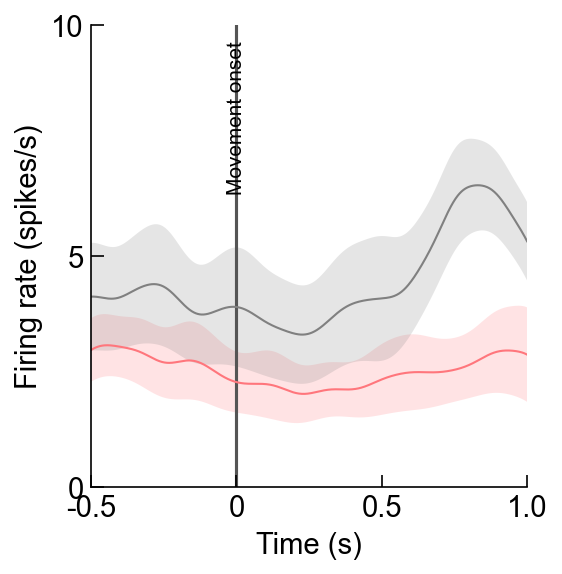

In [111]:
fig, ax = plt.subplots(figsize=(3.75,4))
    
#PSTH
starttime = -30000 #samples, -1s
endtime = starttime+60000 #samples,1s
xrange = np.linspace(starttime,endtime,num=1000)

NCR_avg_FR_Mouth = CalculateforRasterPSTHAcrossCells(movementsToPlots[1])[0]
NCR_sem_FR_Mouth = CalculateforRasterPSTHAcrossCells(movementsToPlots[1])[1]
ax.plot(xrange,NCR_avg_FR_Mouth, lw=1,color=NCR_COLOR)
ax.fill_between(xrange,NCR_avg_FR_Mouth-NCR_sem_FR_Mouth,NCR_avg_FR_Mouth+NCR_sem_FR_Mouth,color=NCR_COLOR,alpha=0.2,zorder=-10,lw=0)
CR_avg_FR_Mouth = CalculateforRasterPSTHAcrossCells(movementsToPlots[1])[3]
CR_sem_FR_Mouth = CalculateforRasterPSTHAcrossCells(movementsToPlots[1])[4]
ax.plot(xrange,CR_avg_FR_Mouth, lw=1,color=CR_COLOR)
ax.fill_between(xrange,CR_avg_FR_Mouth-CR_sem_FR_Mouth,CR_avg_FR_Mouth+CR_sem_FR_Mouth,color=CR_COLOR,alpha=0.2,zorder=-10,lw=0)
ax.set_xlabel('Time (s)')

# highest_limit = 15
# ax.set_ylim([0,highest_limit])
# ax.set_yticks([0,5,10,15])
# ax.set_yticklabels(['0','5','10','15']) #real

highest_limit = 10
ax.set_ylim([0,highest_limit])
ax.set_yticks([0,5,10])
ax.set_yticklabels(['0','5','10']) #real

ax.set_ylabel('Firing rate (spikes/s)')
ax.set_xlim([-15000,30000])
ax.set_xticks([-15000,0,15000,30000])

ax.set_xticklabels(['-0.5','0','0.5','1.0'])#real


for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
    ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(stdfont)
    
ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)
ax.tick_params(length=6)
ax.set_axisbelow(False)


ax.text(-0.2,8,'Movement onset',color='black',horizontalalignment='center',verticalalignment='center',rotation=90,fontsize=10)
ax.axvline(0,0,highest_limit,color='#555555',zorder=-1)

fig.savefig(os.path.join('C:\\Users\insan\\Desktop\\Motion new\\non-normalized fr mouth3.pdf'),transparent=False,facecolor="white",bbox_inches = 'tight')

meta NOT subset; don't know how to subset; dropped


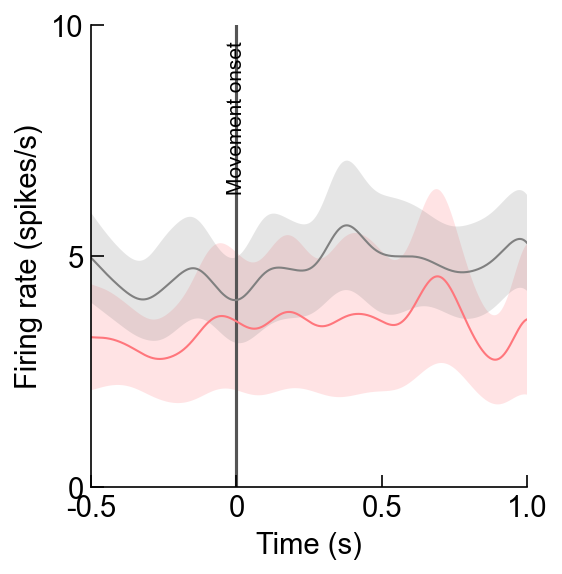

In [112]:
fig, ax = plt.subplots(figsize=(3.75,4))
    
#PSTH
starttime = -30000 #samples
endtime = starttime+60000 #samples
xrange = np.linspace(starttime,endtime,num=1000)

NCR_avg_FR_Nose = CalculateforRasterPSTHAcrossCells(movementsToPlots[2])[0]
NCR_sem_FR_Nose = CalculateforRasterPSTHAcrossCells(movementsToPlots[2])[1]
ax.plot(xrange,NCR_avg_FR_Nose, lw=1,color=NCR_COLOR,label = 'NCR')
ax.fill_between(xrange,NCR_avg_FR_Nose-NCR_sem_FR_Nose,NCR_avg_FR_Nose+NCR_sem_FR_Nose,color=NCR_COLOR,alpha=0.2,zorder=-10,lw=0)
CR_avg_FR_Nose = CalculateforRasterPSTHAcrossCells(movementsToPlots[2])[3]
CR_sem_FR_Nose = CalculateforRasterPSTHAcrossCells(movementsToPlots[2])[4]
ax.plot(xrange,CR_avg_FR_Nose, lw=1,color=CR_COLOR,label = 'CR')
ax.fill_between(xrange,CR_avg_FR_Nose-CR_sem_FR_Nose,CR_avg_FR_Nose+CR_sem_FR_Nose,color=CR_COLOR,alpha=0.2,zorder=-10,lw=0)
ax.set_xlabel('Time (s)')

highest_limit = 10
ax.set_ylim([0,highest_limit])
ax.set_yticks([0,5,10])
ax.set_yticklabels(['0','5','10']) #real

# highest_limit = 15
# ax.set_ylim([0,highest_limit])
# ax.set_yticks([0,5,10,15])
# ax.set_yticklabels(['0','5','10','15']) #real

ax.set_ylabel('Firing rate (spikes/s)')
ax.set_xlim([-15000,30000])
ax.set_xticks([-15000,0,15000,30000])
ax.set_xticklabels(['-0.5','0','0.5','1.0'])#real



for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
    ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(stdfont)
    
ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)
ax.tick_params(length=6)
ax.set_axisbelow(False)

ax.text(-0.2,8,'Movement onset',color='black',horizontalalignment='center',verticalalignment='center',rotation=90,fontsize=10)
ax.axvline(0,0,highest_limit,color='#555555',zorder=-1)

fig.savefig(os.path.join('C:\\Users\insan\\Desktop\\Motion new\\non-normalized fr nose3.pdf'),transparent=False,facecolor="white",bbox_inches = 'tight')

meta NOT subset; don't know how to subset; dropped


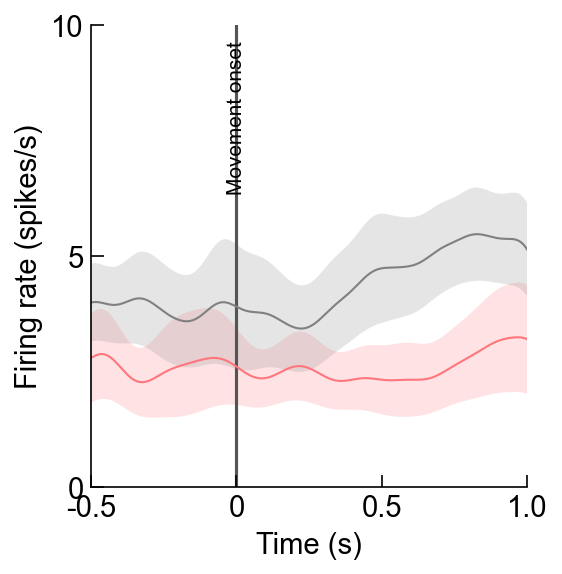

In [113]:
fig, ax = plt.subplots(figsize=(3.75,4))
    
#PSTH
starttime = -30000 #samples
endtime = starttime+60000 #samples
xrange = np.linspace(starttime,endtime,num=1000)

NCR_avg_FR_Whisker = CalculateforRasterPSTHAcrossCells(movementsToPlots[3])[0]
NCR_sem_FR_Whisker = CalculateforRasterPSTHAcrossCells(movementsToPlots[3])[1]
ax.plot(xrange,NCR_avg_FR_Whisker, lw=1,color=NCR_COLOR)
ax.fill_between(xrange,NCR_avg_FR_Whisker-NCR_sem_FR_Whisker,NCR_avg_FR_Whisker+NCR_sem_FR_Whisker,color=NCR_COLOR,alpha=0.2,zorder=-10,lw=0)
CR_avg_FR_Whisker = CalculateforRasterPSTHAcrossCells(movementsToPlots[3])[3]
CR_sem_FR_Whisker = CalculateforRasterPSTHAcrossCells(movementsToPlots[3])[4]
ax.plot(xrange,CR_avg_FR_Whisker, lw=1,color=CR_COLOR)
ax.fill_between(xrange,CR_avg_FR_Whisker-CR_sem_FR_Whisker,CR_avg_FR_Whisker+CR_sem_FR_Whisker,color=CR_COLOR,alpha=0.2,zorder=-10,lw=0)
ax.set_xlabel('Time (s)')

highest_limit = 10
ax.set_ylim([0,highest_limit])
ax.set_yticks([0,5,10])
ax.set_yticklabels(['0','5','10']) #real

# highest_limit = 15
# ax.set_ylim([0,highest_limit])
# ax.set_yticks([0,5,10,15])
# ax.set_yticklabels(['0','5','10','15']) #real

ax.set_ylabel('Firing rate (spikes/s)')
ax.set_xlim([-15000,30000])
ax.set_xticks([-15000,0,15000,30000])

ax.set_xticklabels(['-0.5','0','0.5','1.0'])#real


for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
    ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(stdfont)
    
ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)
ax.tick_params(length=6)
ax.set_axisbelow(False)

ax.text(-0.2,8,'Movement onset',color='black',horizontalalignment='center',verticalalignment='center',rotation=90,fontsize=10)
ax.axvline(0,0,highest_limit,color='#555555',zorder=-1)

fig.savefig(os.path.join('C:\\Users\insan\\Desktop\\Motion new\\non-normalized fr whisker3.pdf'),transparent=False,facecolor="white",bbox_inches = 'tight')

meta NOT subset; don't know how to subset; dropped


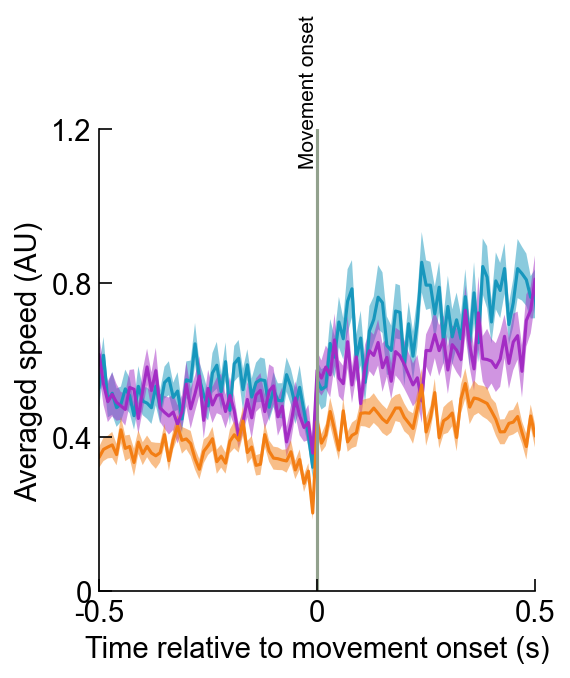

In [88]:
stdfont = 14
stdyfrac = 0.06

mouthcol = '#1797BD'
nosecol = '#A32CC4'
whiskercol = '#F37E14'

fig, ax = plt.subplots(figsize=(3.75,4))
#Mouth speed plot
#ax.axvspan(200, 250, ymin=0,color='#e8f4e4', lw=0,zorder=-11)
#ax.axvspan(150, 200, ymin=0,color='white', alpha=0.3, lw=0,label='slow',zorder=-11)
ax.plot(avg_mouth_3003_speed,color=mouthcol)
ax.fill_between(np.arange(0,400),avg_mouth_3003_speed-sem_mouth_3003_speed,avg_mouth_3003_speed+sem_mouth_3003_speed,color=mouthcol,alpha=0.5,zorder=-10,lw=0)

ax.plot(avg_nose_3003_speed,color=nosecol)
ax.fill_between(np.arange(0,400),avg_nose_3003_speed-sem_nose_3003_speed,avg_nose_3003_speed+sem_nose_3003_speed,color=nosecol,alpha=0.5,zorder=-10,lw=0)

ax.plot(avg_whisker_3003_speed,color=whiskercol)
ax.fill_between(np.arange(0,400),avg_whisker_3003_speed-sem_whisker_3003_speed,avg_whisker_3003_speed+sem_whisker_3003_speed,color=whiskercol,alpha=0.5,zorder=-10,lw=0)

ax.set_xlim([150,250])
ax.set_xticks([150,200,250])
ax.set_xticklabels(['-0.5','0','0.5'])
ax.set_ylabel('Averaged speed (AU)')
ax.set_xlabel('Time relative to movement onset (s)')

ax.set_ylim([0,1.2])
ax.set_yticks([0,0.4,0.8,1.2])
ax.set_yticklabels(['0','0.4','0.8','1.2'])


ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)
ax.tick_params(length=6)
ax.set_axisbelow(False)

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
    ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(stdfont)

ax.text(198,1.3,'Movement onset',color='black',horizontalalignment='center',verticalalignment='center',rotation=90,fontsize=10)
ax.axvline(200,0,1.6,color='#92a18d')

fig.savefig(os.path.join('C:\\Users\insan\\Desktop\\Motion new\\together.pdf'),transparent=False,facecolor="white", bbox_inches = 'tight')

### old functions Individual cell plots for both NCR and CR

In [ ]:
def CalculateforRasterPSTH(movementsToPlots):
    #Raster
    moveSpikes = []
    for movement in movementsToPlots:
        this_move_spike = ilep.getSpikeTimes(sessionfile,clust=clust,starttime=movement-33000, endtime=movement+33000)
        moveSpikes.append(this_move_spike-movement)
    moveSpikes = np.array(moveSpikes,dtype='object') 
    #PSTH
    bw_scott_factor = 3
    starttime = -30000 #samples
    endtime = starttime+60000 #samples
    xrange = np.linspace(starttime,endtime,num=1000)
    FR = np.full((10,len(xrange)),np.nan) 
    kf = KFold(n_splits=10)

    for idx,(move_index,_) in enumerate(kf.split(moveSpikes)):
        PSTHspikes = np.concatenate(moveSpikes[move_index])
        bw = len(PSTHspikes)**(-1./5) / bw_scott_factor
        KDE = gaussian_kde(PSTHspikes,bw_method=bw)
        FR[idx,:] = KDE.evaluate(xrange)
        FR[idx,:] = FR[idx,:] * len(PSTHspikes) / len(move_index) *30000 #convert unit to seconds from samples
    avg_FR = np.mean(FR,axis=0)
    sem_FR = np.std(FR,axis=0)

    max_FR_value = np.max(avg_FR+sem_FR) * 1.1
    sequence_of_possible_axis_limits = np.array([1,2,4,6,8,10,12,16,20,30,40,50,60,80,100,120,140,150,160,180,200])
    idx_of_okay_limits = np.greater_equal(sequence_of_possible_axis_limits,max_FR_value)
    valid_limits = sequence_of_possible_axis_limits[idx_of_okay_limits]
    limit = np.min(valid_limits)
    
    return avg_FR,sem_FR,xrange,limit,moveSpikes

def CalculateforRasterPSTHLimit(sessionfile_D9,clust,movementsToPlots):
    #Raster
    moveSpikes = []
    for movement in movementsToPlots:
        this_move_spike = ilep.getSpikeTimes(sessionfile,clust=clust,starttime=movement-33000, endtime=movement+33000)
        moveSpikes.append(this_move_spike-movement)
    moveSpikes = np.array(moveSpikes,dtype='object') 
    #PSTH
    bw_scott_factor = 3
    starttime = -30000 #samples
    endtime = starttime+60000 #samples
    xrange = np.linspace(starttime,endtime,num=1000)
    FR = np.full((10,len(xrange)),np.nan) 
    kf = KFold(n_splits=10)

    for idx,(move_index,_) in enumerate(kf.split(moveSpikes)):
        PSTHspikes = np.concatenate(moveSpikes[move_index])
        bw = len(PSTHspikes)**(-1./5) / bw_scott_factor
        KDE = gaussian_kde(PSTHspikes,bw_method=bw)
        FR[idx,:] = KDE.evaluate(xrange)
        FR[idx,:] = FR[idx,:] * len(PSTHspikes) / len(move_index) *30000 #convert unit to seconds from samples
    avg_FR = np.mean(FR,axis=0)
    sem_FR = np.std(FR,axis=0)

    max_FR_value = np.max(avg_FR+sem_FR) * 1.1
    sequence_of_possible_axis_limits = np.array([1,2,4,6,8,10,12,16,20,30,40,50,60,80,100,120,140,150,160,180,200])
    idx_of_okay_limits = np.greater_equal(sequence_of_possible_axis_limits,max_FR_value)
    valid_limits = sequence_of_possible_axis_limits[idx_of_okay_limits]
    limit = np.min(valid_limits)
    
    return limit

integrate_limit_arr = []
mouth_limit_arr = []
nose_limit_arr = []
whisker_limit_arr = []
for clust in NCR_D9:
    integrate_limit = CalculateforRasterPSTHLimit(sessionfile_D9,clust,integrate_3003_movement_onset_samples_arr)
    integrate_limit_arr.append(integrate_limit)
 
    mouth_limit = CalculateforRasterPSTHLimit(sessionfile_D9,clust, mouth_3003_movement_onset_samples_arr)
    mouth_limit_arr.append(mouth_limit)
    
    nose_limit = CalculateforRasterPSTHLimit(sessionfile_D9,clust, nose_3003_movement_onset_samples_arr)
    nose_limit_arr.append(nose_limit)
    
    whisker_limit = CalculateforRasterPSTHLimit(sessionfile_D9,clust,whisker_3003_movement_onset_samples_arr)
    whisker_limit_arr.append(whisker_limit)

integrate_limit_arr=np.array(integrate_limit_arr)
mouth_limit_arr = np.array(mouth_limit_arr)
nose_limit_arr = np.array(nose_limit_arr)
whisker_limit_arr = np.array(whisker_limit_arr)
limit_arr = np.concatenate((integrate_limit_arr,mouth_limit_arr,nose_limit_arr,whisker_limit_arr))

In [ ]:
def visualizeClusterMovement(sessionfile,clust,limit_arr,celltype):
    movementsToPlots = [integrate_3003_movement_onset_samples_arr,mouth_3003_movement_onset_samples_arr,
                   nose_3003_movement_onset_samples_arr,whisker_3003_movement_onset_samples_arr]

    FRmod = sessionfile.responsiveness[clust]['all_trials'].FRmodulation
    FRmod_color = NCR_CR_cmap( (FRmod-1)/5)
    #########################################################################################
    region = sessionfile.meta.region
    #########################################################################################

    fig = plt.figure(figsize=(15,5))
    fig.suptitle(celltype+' '+str(clust) +' '+ 'from AE_231_3_AC')
    
    gs = fig.add_gridspec(2,4,height_ratios=[0.6,0.4],hspace=0.1)
    
    #Integrate
    ax2 = plt.subplot(gs[1,0])#PSTH
    ax1 = plt.subplot(gs[0,0],sharex=ax2)#Raster
    
    #Mouth
    ax4 = plt.subplot(gs[1,1],sharey=ax2)#PSTH
    ax3 = plt.subplot(gs[0,1],sharex=ax4)#Raster
    
    #Nose
    ax6 = plt.subplot(gs[1,2],sharey=ax2)#PSTH
    ax5 = plt.subplot(gs[0,2],sharex=ax6)#Raster
    
    #Whisker
    ax8 = plt.subplot(gs[1,3],sharey=ax2)#PSTH
    ax7 = plt.subplot(gs[0,3],sharex=ax8)#Raster
    
    
    ax_Raster = [ax3,ax5,ax7]
    ax_PSTH = [ax4,ax6,ax8]
    ################    
    #Raster
    for ax in ax_Raster:
        ax.spines['bottom'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        ax.axvspan(-30000,0, ymin=0,color='white', alpha=0.3, lw=0,label='slow movement') 
        ax.axvspan(0, 30000, ymin=0,color='lightgray', alpha=0.3, lw=0,label='fast movement') 
    
    ax7.legend(frameon=True,loc=(1.05,0.8))
        
    moveSpikes_Integrate = CalculateforRasterPSTH(movementsToPlots[0])[4]
    for idx,move in enumerate(movementsToPlots[0]):
        ax1.scatter(moveSpikes_Integrate[idx],np.ones_like(moveSpikes_Integrate[idx])*idx,color=FRmod_color,s=1.5,marker='o',lw=0,alpha=0)
    #ax1.annotate('movements = '+str(len(moveSpikes_Integrate)), xy=(0, 1.02), xycoords='axes fraction', xytext=(0, 1.02),color='black')
    
    moveSpikes_Mouth = CalculateforRasterPSTH(movementsToPlots[1])[4]
    for idx,move in enumerate(movementsToPlots[1]):
        ax3.scatter(moveSpikes_Mouth[idx],np.ones_like(moveSpikes_Mouth[idx])*idx,color=FRmod_color,s=1.5,marker='o',lw=0)
    ax3.annotate('movements = '+str(len(moveSpikes_Mouth)), xy=(0, 1.02), xycoords='axes fraction', xytext=(0, 1.02),color='black')
    
    moveSpikes_Nose = CalculateforRasterPSTH(movementsToPlots[2])[4]
    for idx,move in enumerate(movementsToPlots[2]):
        ax5.scatter(moveSpikes_Nose[idx],np.ones_like(moveSpikes_Nose[idx])*idx,color=FRmod_color,s=1.5,marker='o',lw=0)
    ax5.annotate('movements = '+str(len(moveSpikes_Nose)), xy=(0, 1.02), xycoords='axes fraction', xytext=(0, 1.02),color='black')
    
    moveSpikes_Whisker = CalculateforRasterPSTH(movementsToPlots[3])[4]
    for idx,move in enumerate(movementsToPlots[3]):
        ax7.scatter(moveSpikes_Whisker[idx],np.ones_like(moveSpikes_Whisker[idx])*idx,color=FRmod_color,s=1.5,marker='o',lw=0)
    ax7.annotate('movements = '+str(len(moveSpikes_Whisker)), xy=(0, 1.02), xycoords='axes fraction', xytext=(0, 1.02),color='black')
    

    #PSTH
    avg_FR_Integrate = CalculateforRasterPSTH(movementsToPlots[0])[0]
    sem_FR_Integrate = CalculateforRasterPSTH(movementsToPlots[0])[1]
    xrange_Integrate = CalculateforRasterPSTH(movementsToPlots[0])[2]
    limit_Integrate = CalculateforRasterPSTH(movementsToPlots[0])[3]
    ax2.plot(xrange_Integrate,avg_FR_Integrate,lw=1,color=FRmod_color,alpha=0)
    #ax2.fill_between(xrange_Integrate,avg_FR_Integrate-sem_FR_Integrate,avg_FR_Integrate+sem_FR_Integrate,color=FRmod_color,alpha=0.5,zorder=-10,lw=0)
    ax2.set_xlabel('Time relative to all movement onset (s)')
    
    avg_FR_Mouth = CalculateforRasterPSTH(movementsToPlots[1])[0]
    sem_FR_Mouth = CalculateforRasterPSTH(movementsToPlots[1])[1]
    xrange_Mouth = CalculateforRasterPSTH(movementsToPlots[1])[2]
    limit_Mouth = CalculateforRasterPSTH(movementsToPlots[1])[3]
    ax4.plot(xrange_Mouth,avg_FR_Mouth,lw=1,color=FRmod_color)
    ax4.fill_between(xrange_Mouth,avg_FR_Mouth-sem_FR_Mouth,avg_FR_Mouth+sem_FR_Mouth,color=FRmod_color,alpha=0.5,zorder=-10,lw=0)
    ax4.set_xlabel('Time relative to mouth movement onset (s)')
    
    avg_FR_Nose = CalculateforRasterPSTH(movementsToPlots[2])[0]
    sem_FR_Nose = CalculateforRasterPSTH(movementsToPlots[2])[1]
    xrange_Nose = CalculateforRasterPSTH(movementsToPlots[2])[2]
    limit_Nose = CalculateforRasterPSTH(movementsToPlots[2])[3]
    ax6.plot(xrange_Nose,avg_FR_Nose,lw=1,color=FRmod_color)
    ax6.fill_between(xrange_Nose,avg_FR_Nose-sem_FR_Nose,avg_FR_Nose+sem_FR_Nose,color=FRmod_color,alpha=0.5,zorder=-10,lw=0)
    ax6.set_xlabel('Time relative to nose movement onset (s)')
    
    avg_FR_Whisker = CalculateforRasterPSTH(movementsToPlots[3])[0]
    sem_FR_Whisker = CalculateforRasterPSTH(movementsToPlots[3])[1]
    xrange_Whisker = CalculateforRasterPSTH(movementsToPlots[3])[2]
    limit_Whisker = CalculateforRasterPSTH(movementsToPlots[3])[3]
    ax8.plot(xrange_Whisker,avg_FR_Whisker,lw=1,color=FRmod_color)
    ax8.fill_between(xrange_Whisker,avg_FR_Whisker-sem_FR_Whisker,avg_FR_Whisker+sem_FR_Whisker,color=FRmod_color,alpha=0.5,zorder=-10,lw=0)
    ax8.set_xlabel('Time relative to whisker movement onset (s)')
    

    highest_limit = np.max(limit_arr)

    ax2.set_ylim([0,highest_limit])
    ax2.set_yticks([0,highest_limit/2,highest_limit])
    ax2.set_yticklabels(['0',str(int(highest_limit/2)),str(highest_limit)])
    
    
    for ax in ax_PSTH:
        ax.axvspan(0, 33000, ymin=0,color='lightgray', alpha=0.3, lw=0)
        ax.set_ylabel('Firing rate (spikes/s)')
        ax.set_xlim([-30000,30000])
        ax.set_xticks([-30000,-15000,0,15000, 30000])
        ax.set_xticklabels(['-1','-0.5','0','0.5','1'])
        
    ax1.spines['bottom'].set_visible(False)
    ax1.spines['left'].set_visible(False)
    ax1.get_xaxis().set_visible(False)
    ax1.get_yaxis().set_visible(False)
    ax2.spines['bottom'].set_visible(False)
    ax2.spines['left'].set_visible(False)
    ax2.get_xaxis().set_visible(False)
    ax2.get_yaxis().set_visible(False)
    
    
    return fig

meta NOT subset; don't know how to subset; dropped


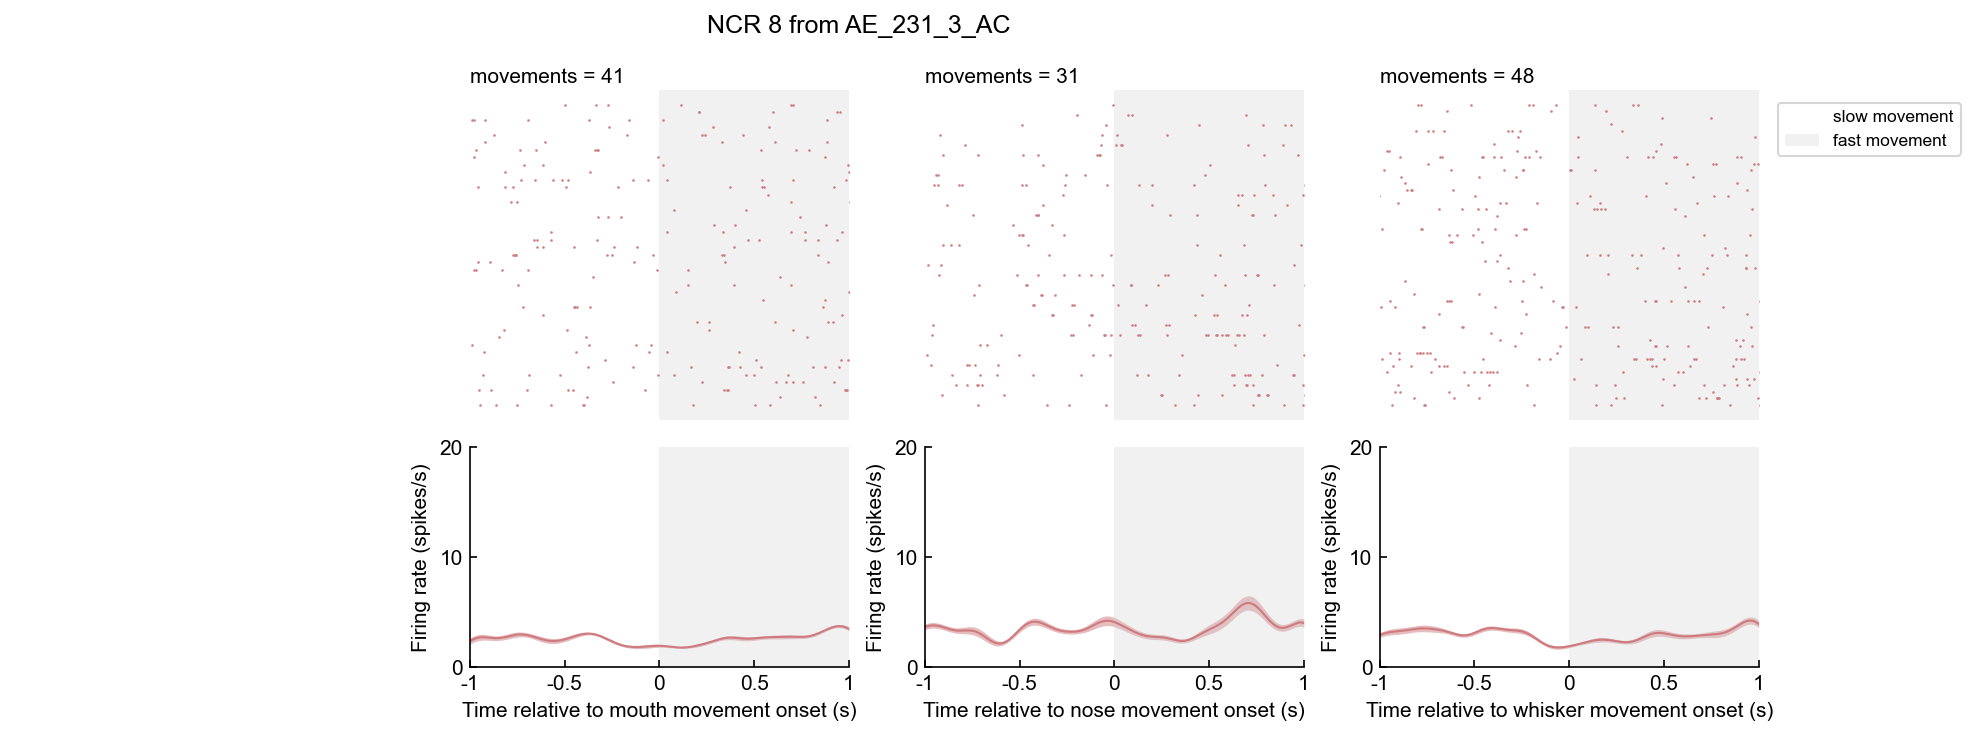

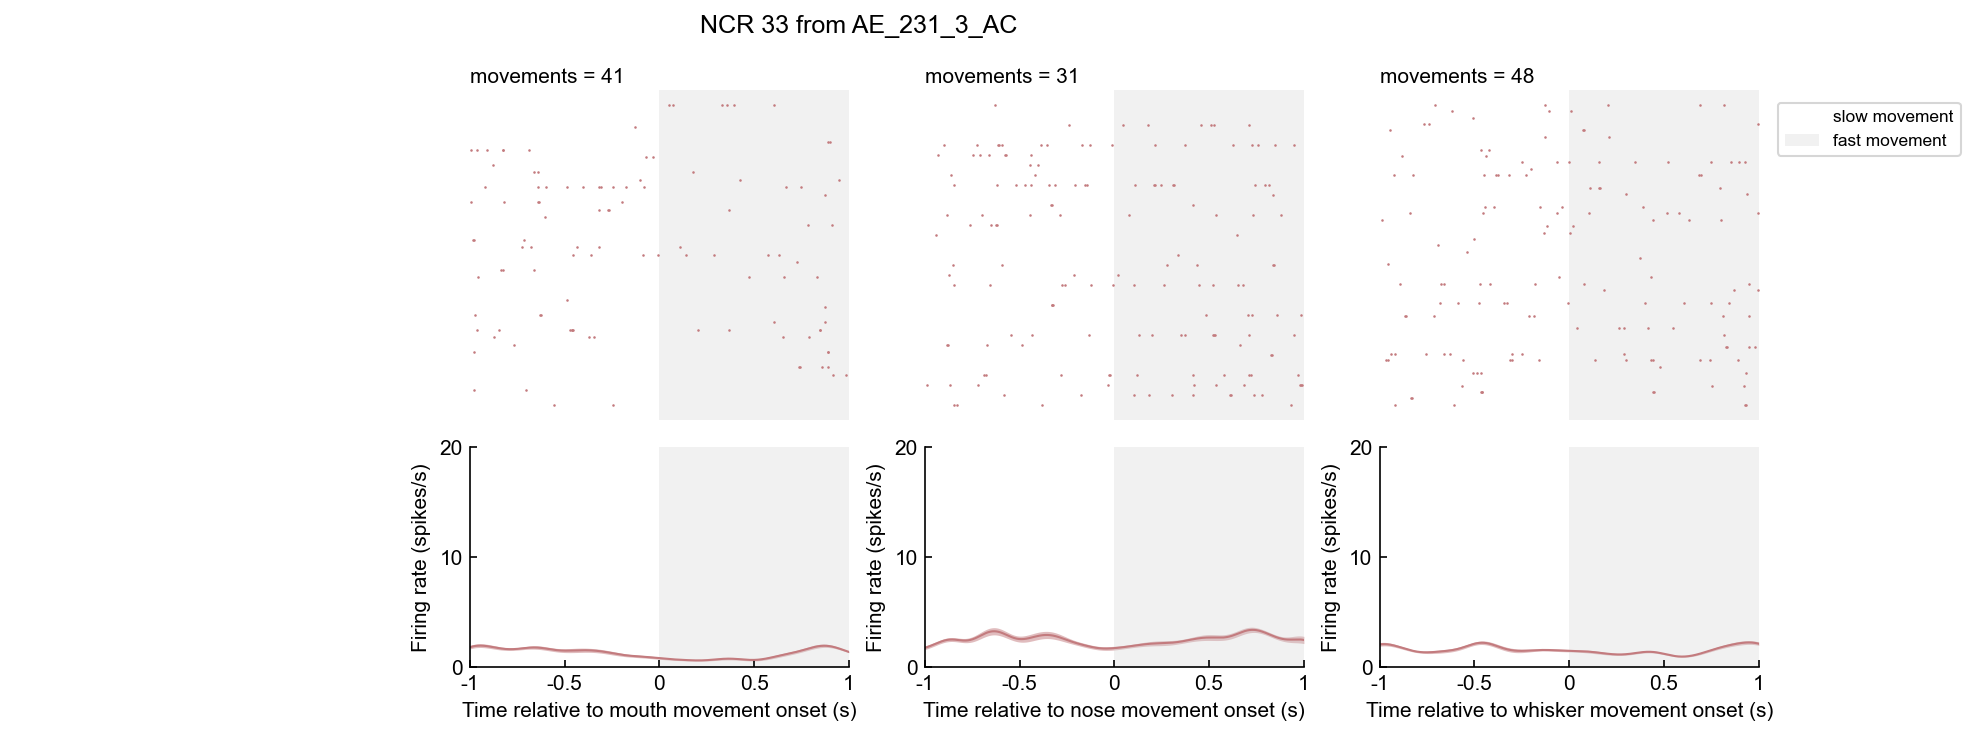

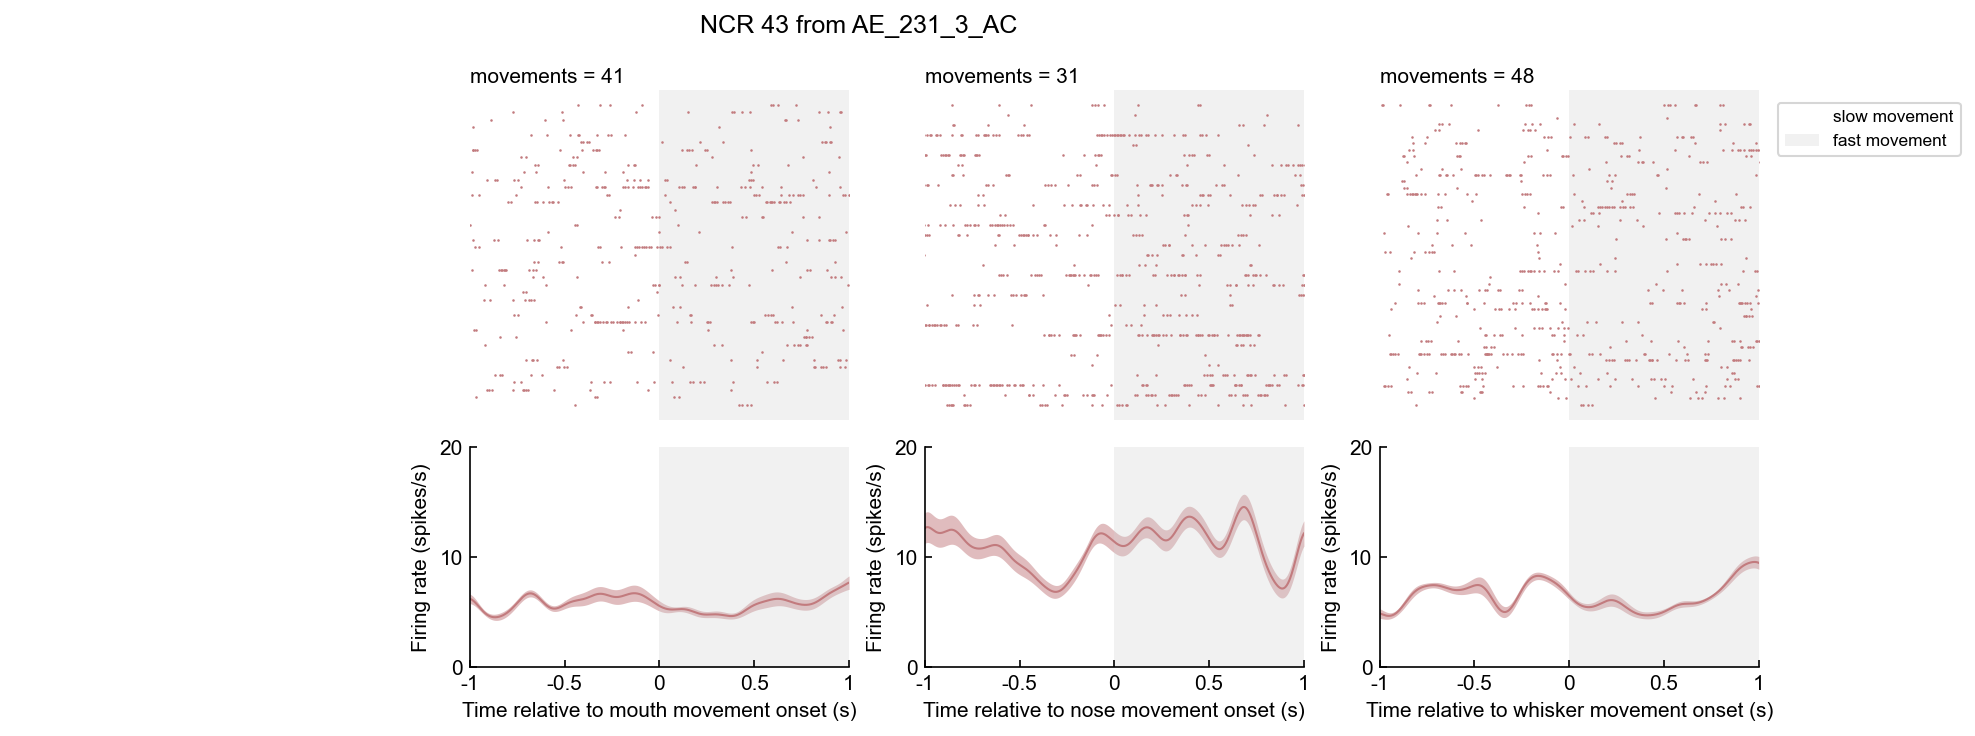

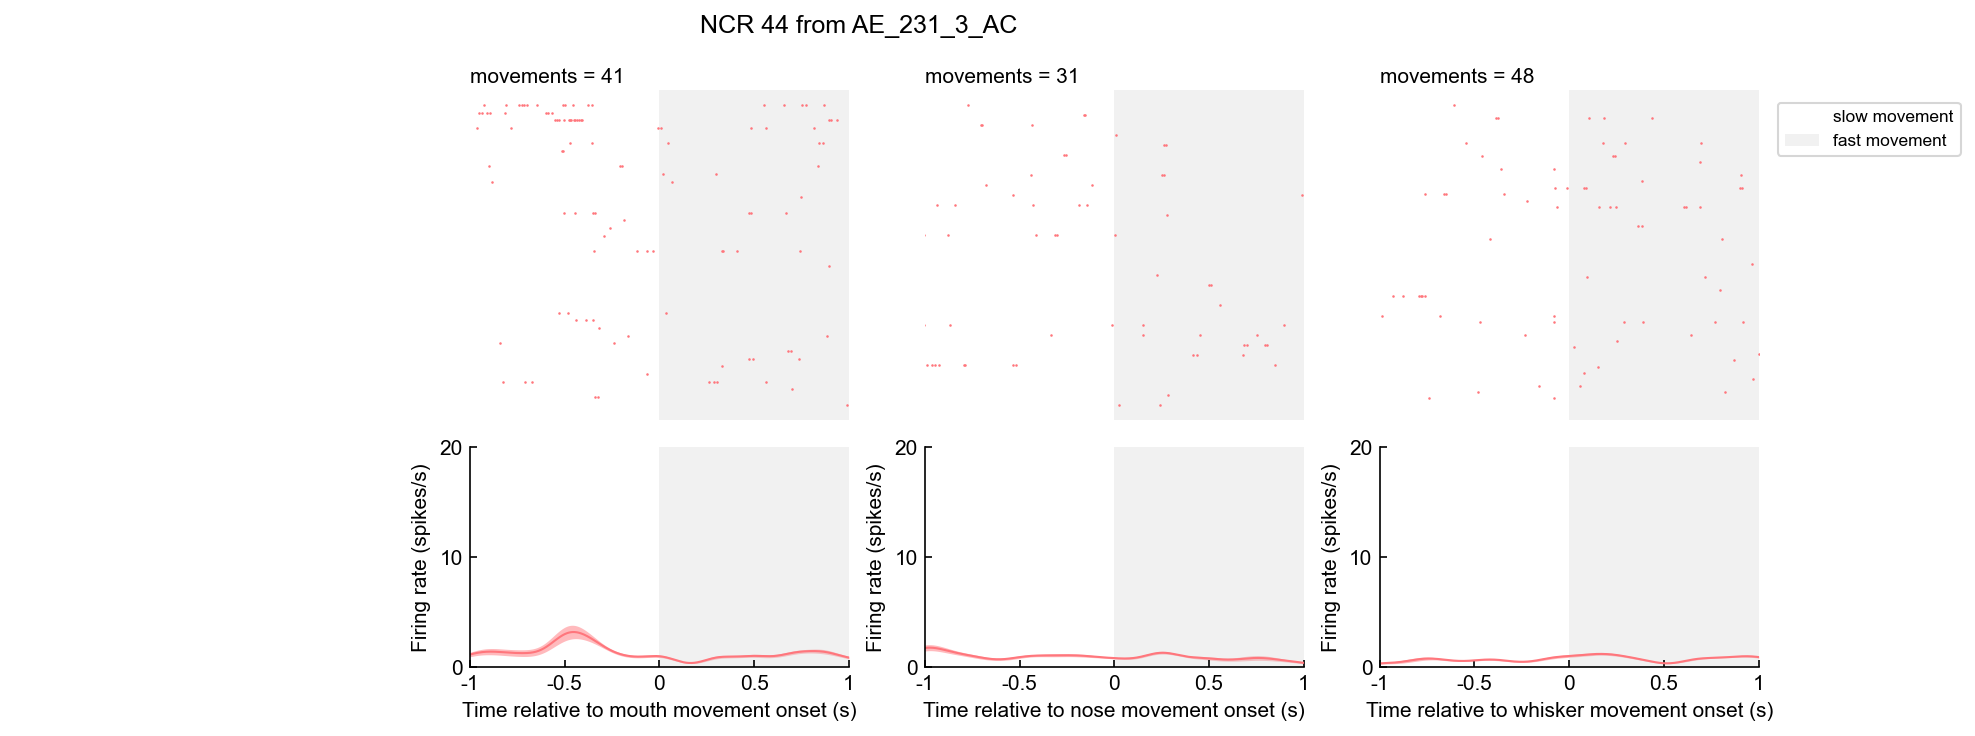

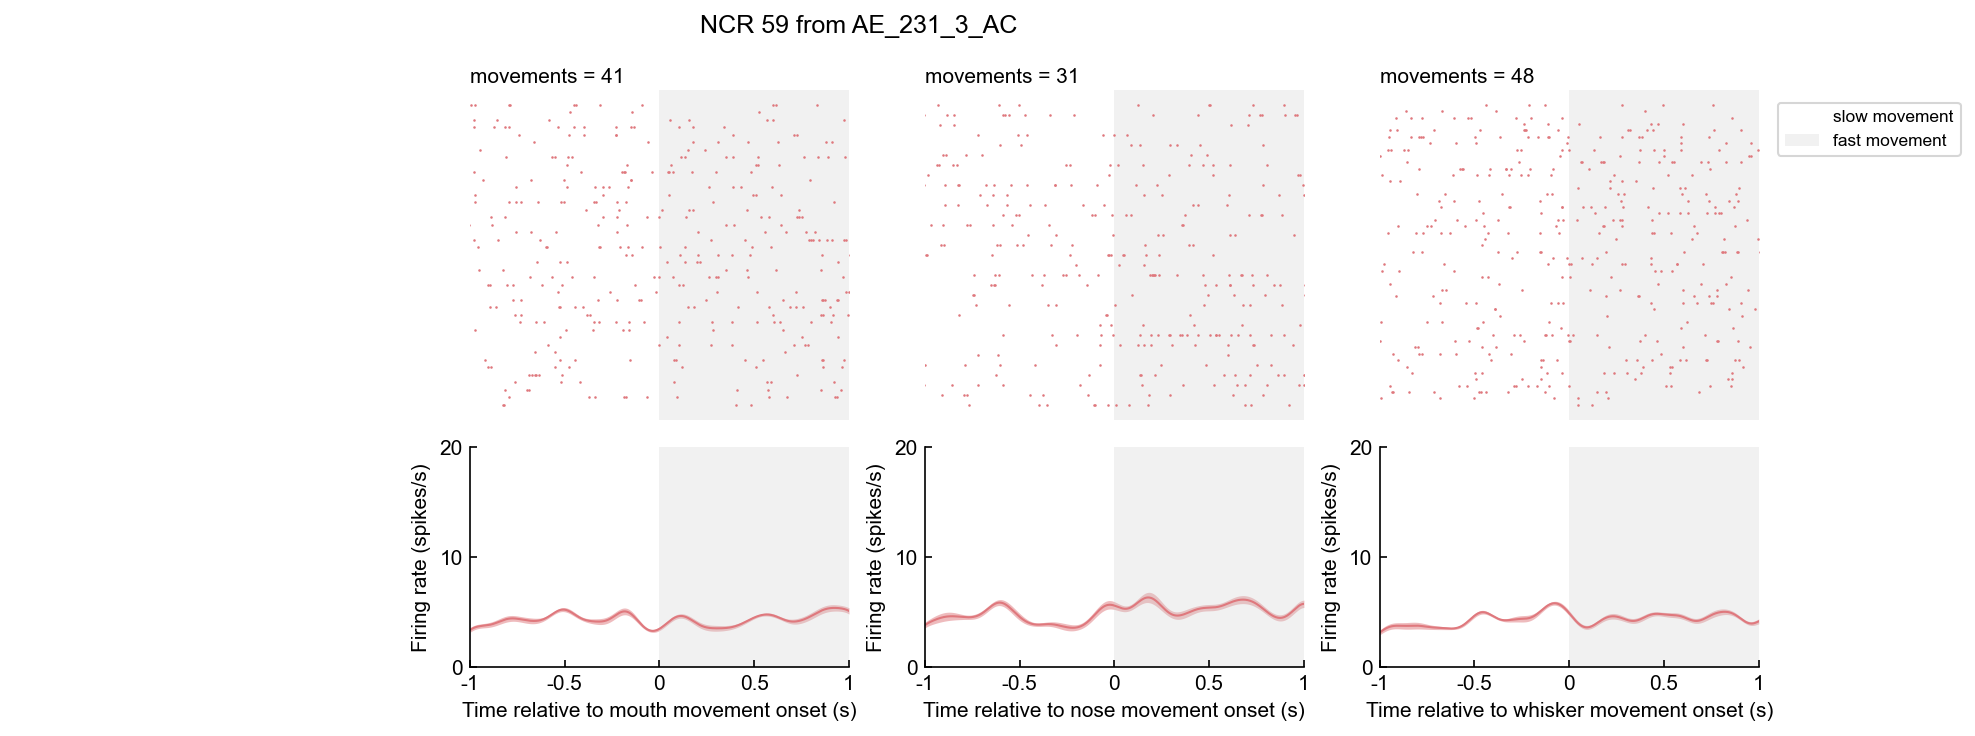

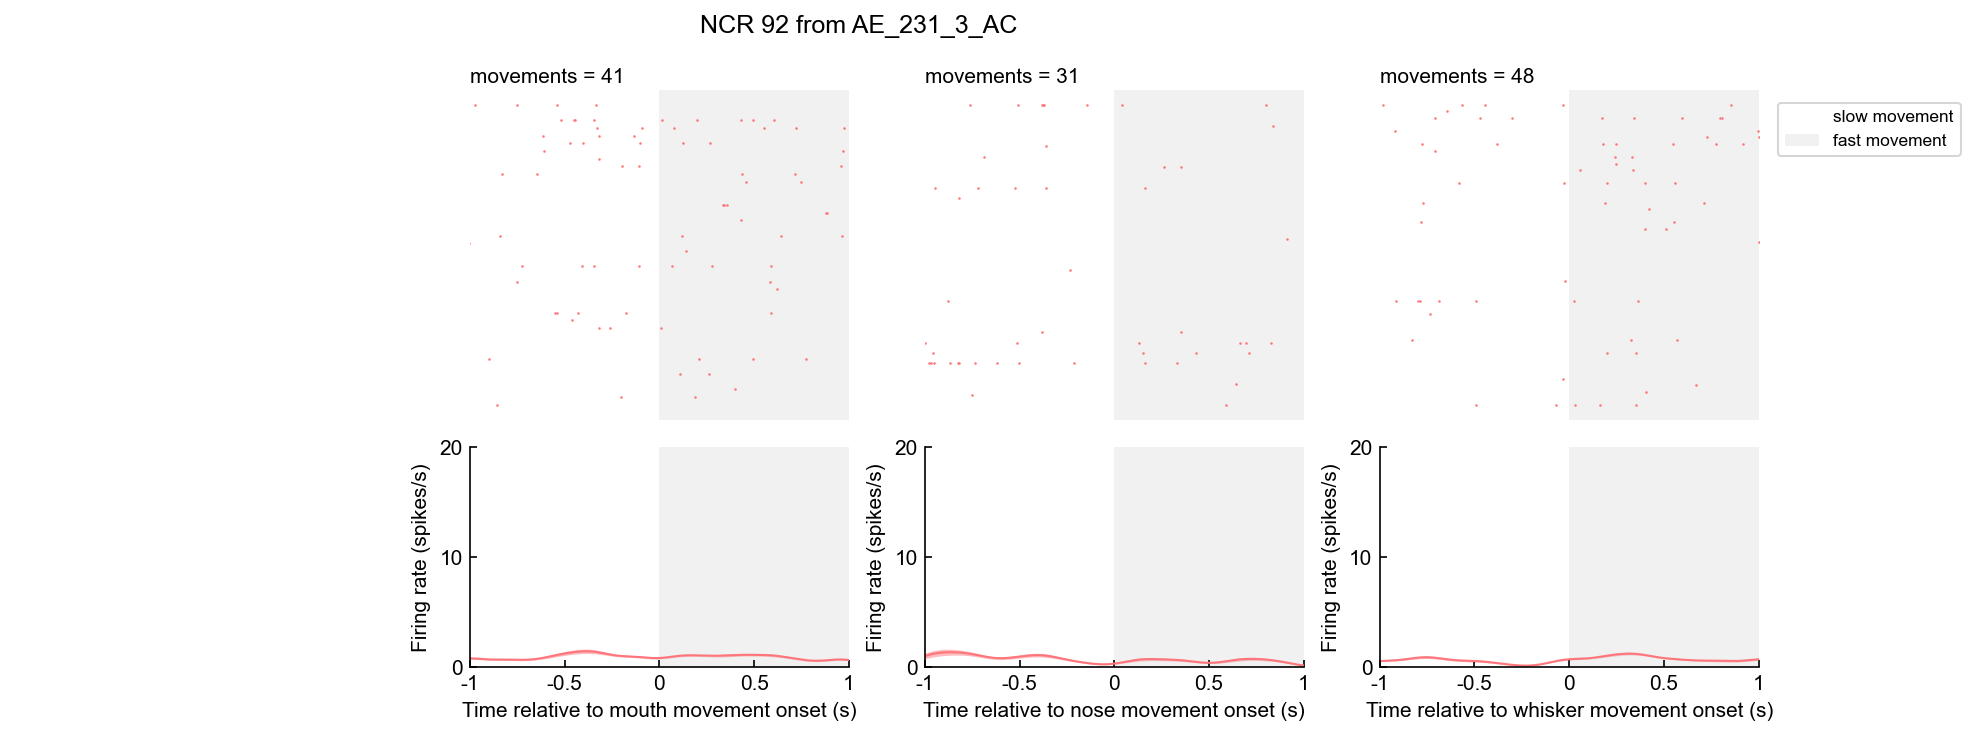

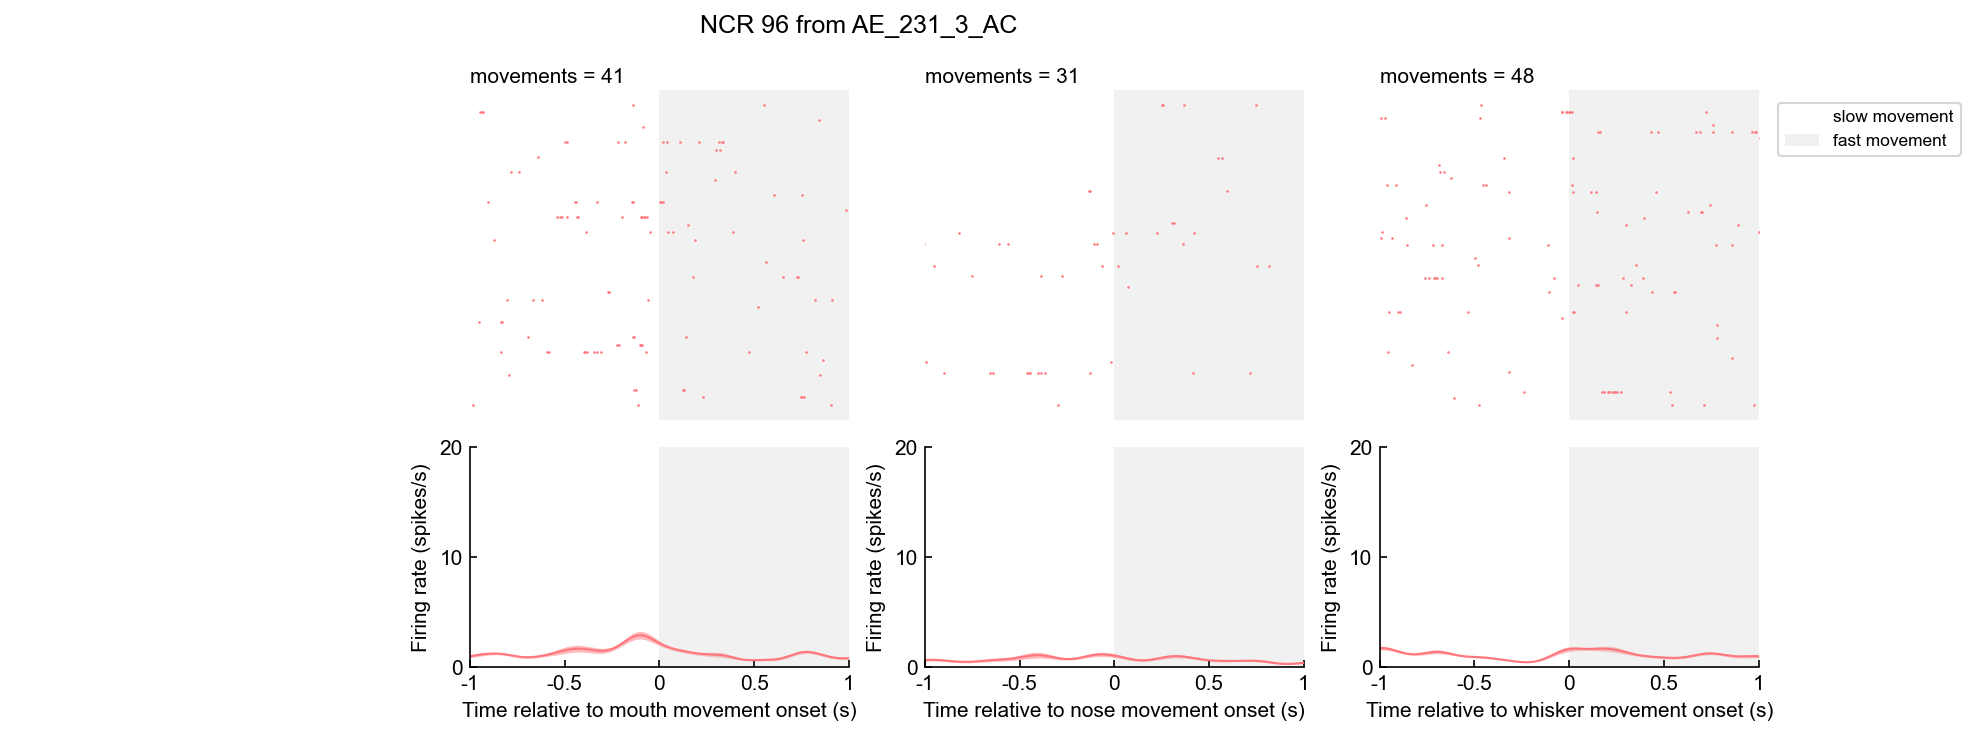

In [72]:
#Save all in PDF: Plots with same y-axis for across all NCR cells in PSTH
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib import pyplot as plt, patches

file_allmove = 'C:\\Users\\insan\\Desktop\\Motion final\\Raster and PSTH for individual NCR.pdf'
with PdfPages(file_allmove) as pdf:
    for clust in NCR_D9:
        fig = visualizeClusterMovement(sessionfile_D9,clust,limit_arr,'NCR') 
        pdf.savefig(fig)
        plt.close('all')

for clust in NCR_D9:
    fig = visualizeClusterMovement(sessionfile_D9,clust,limit_arr,'NCR') 
    fig.savefig(os.path.join('C:\\Users\insan\\Desktop\\Motion final\\png\\NCR',ilep.generateDateString(sessionfile_D9)+' '+str(clust)+'.png'),transparent=False,facecolor="white")


meta NOT subset; don't know how to subset; dropped


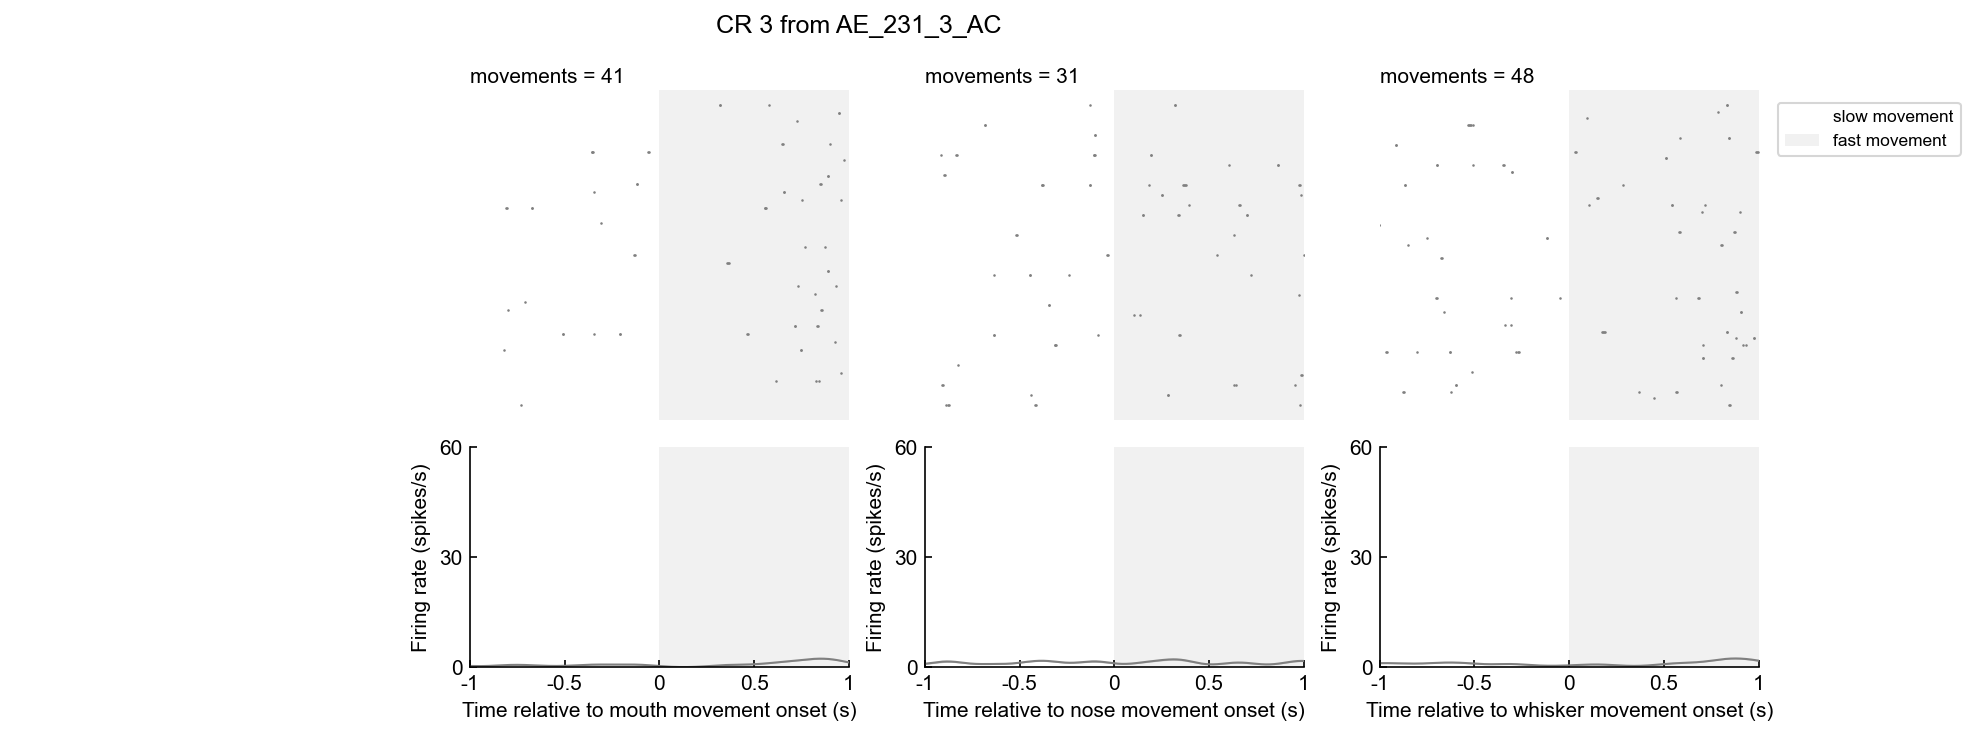

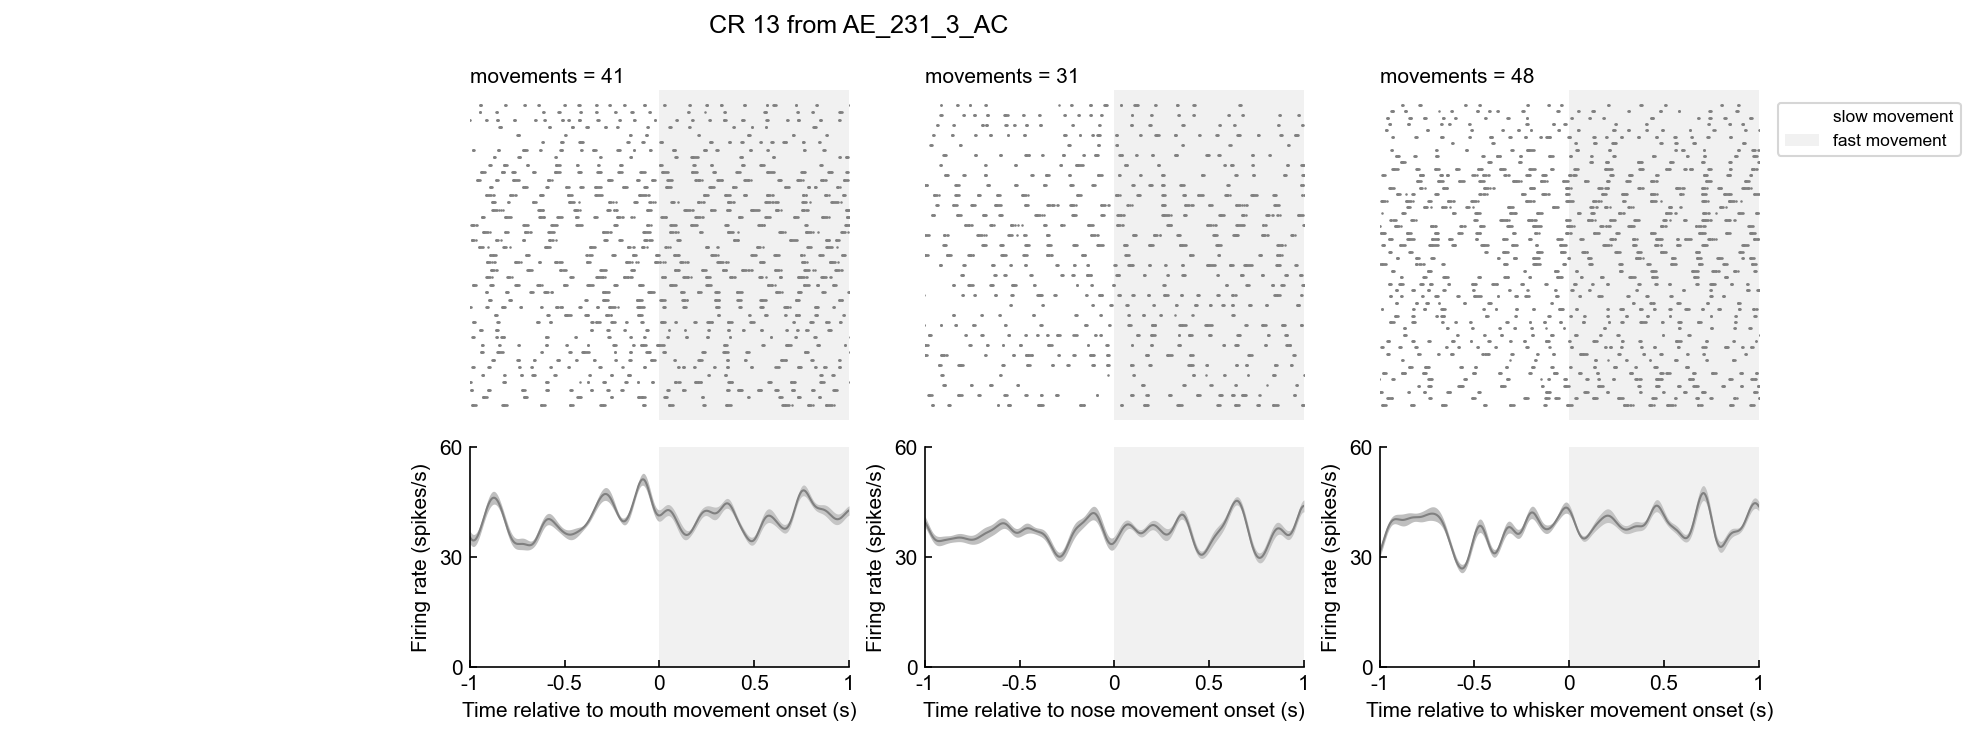

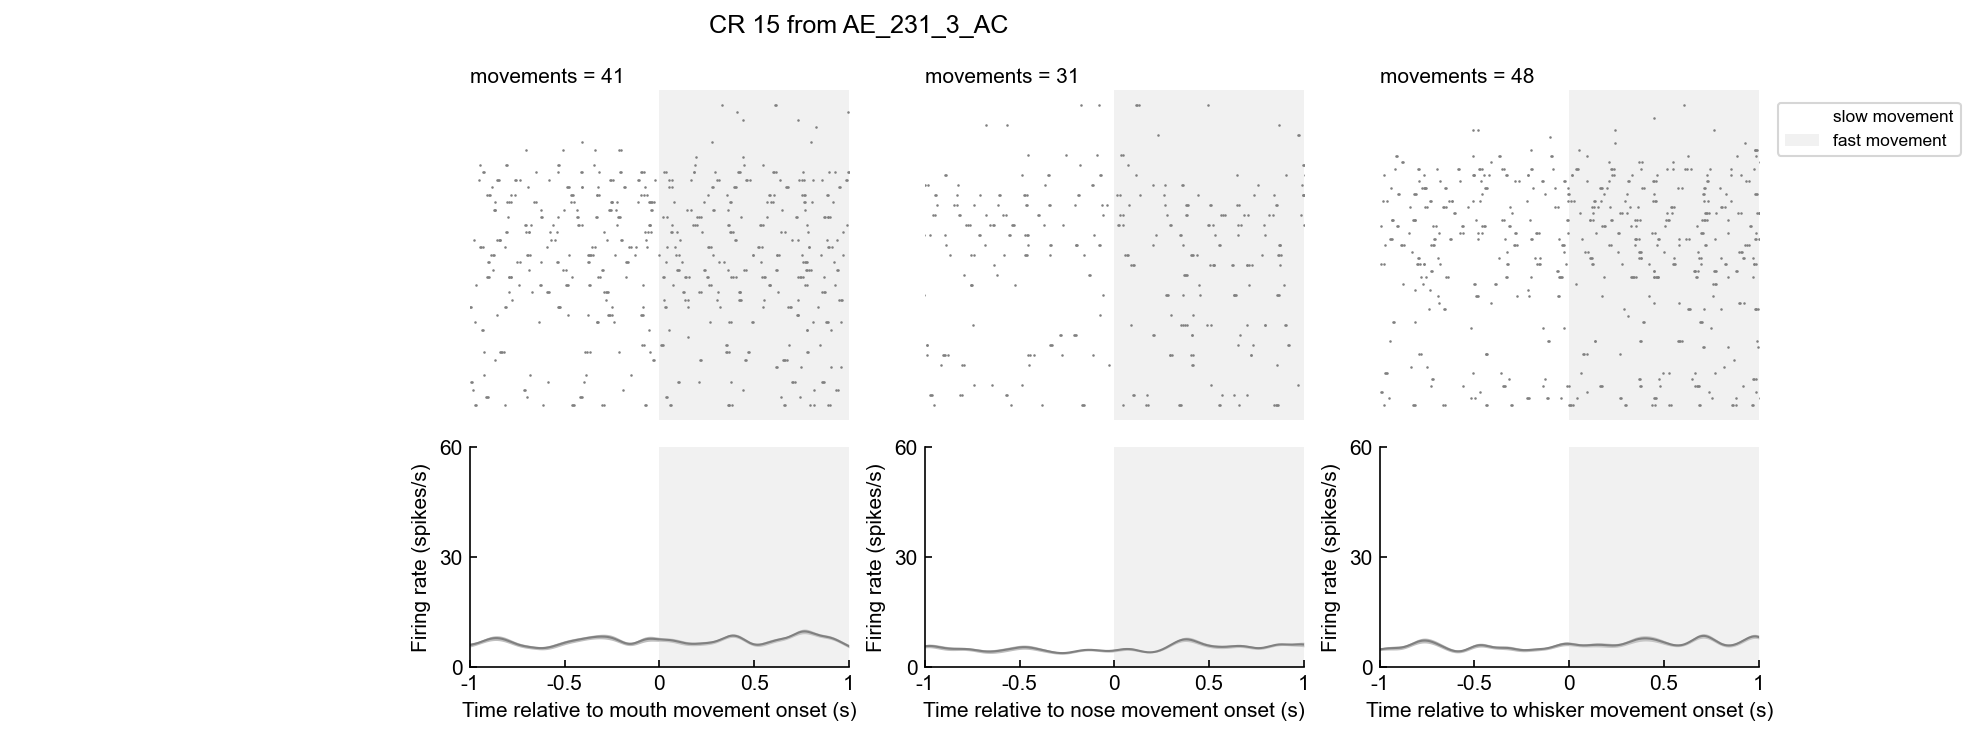

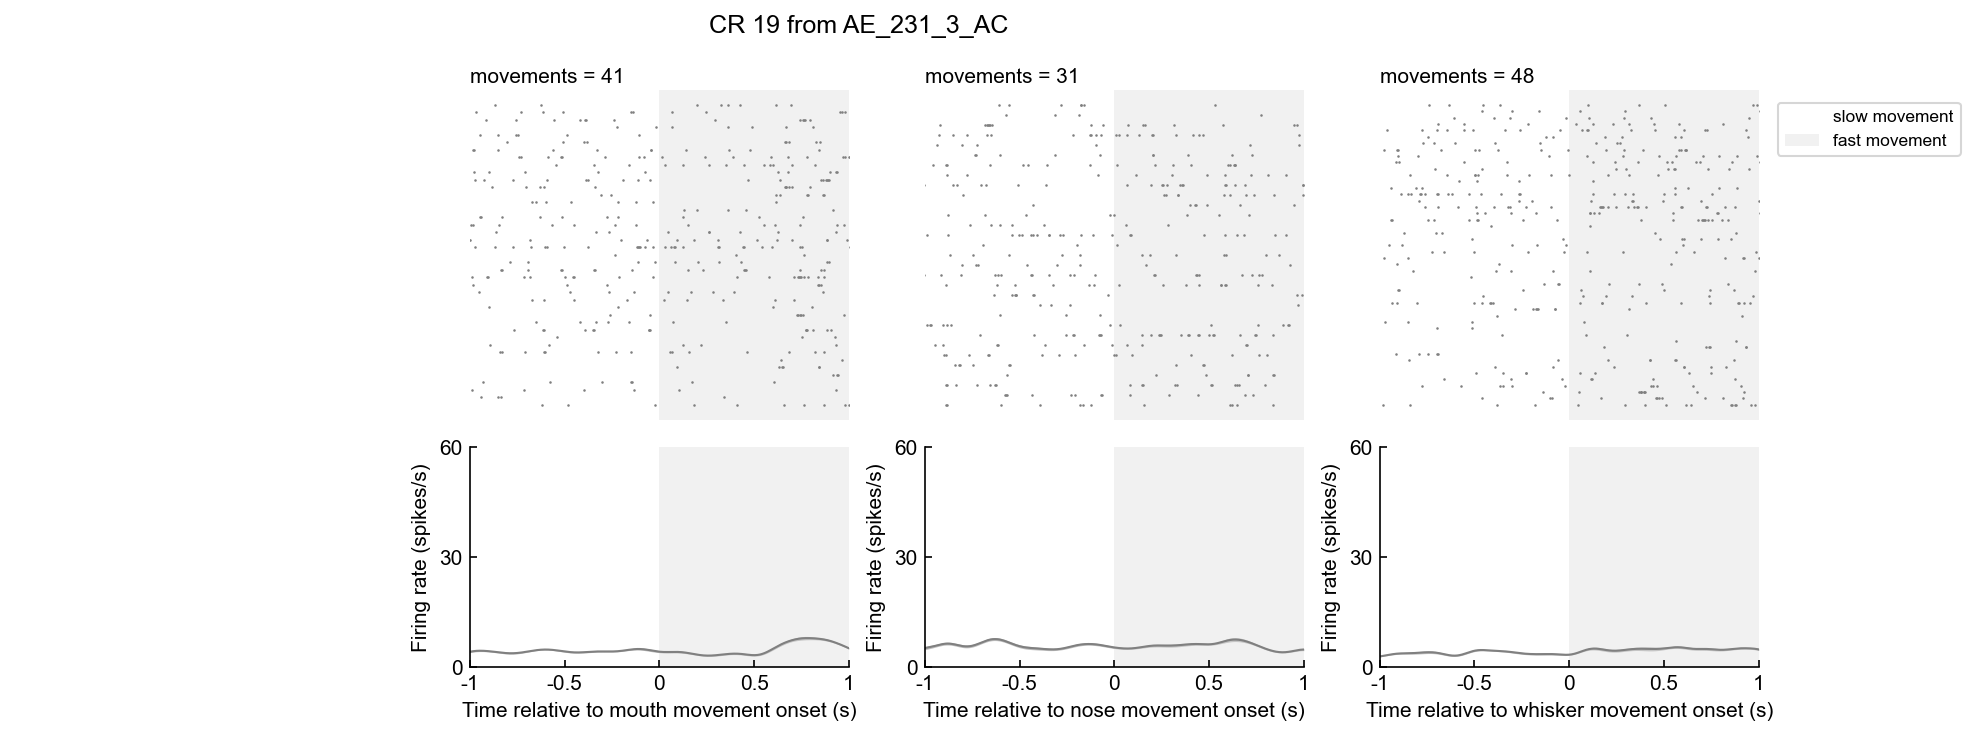

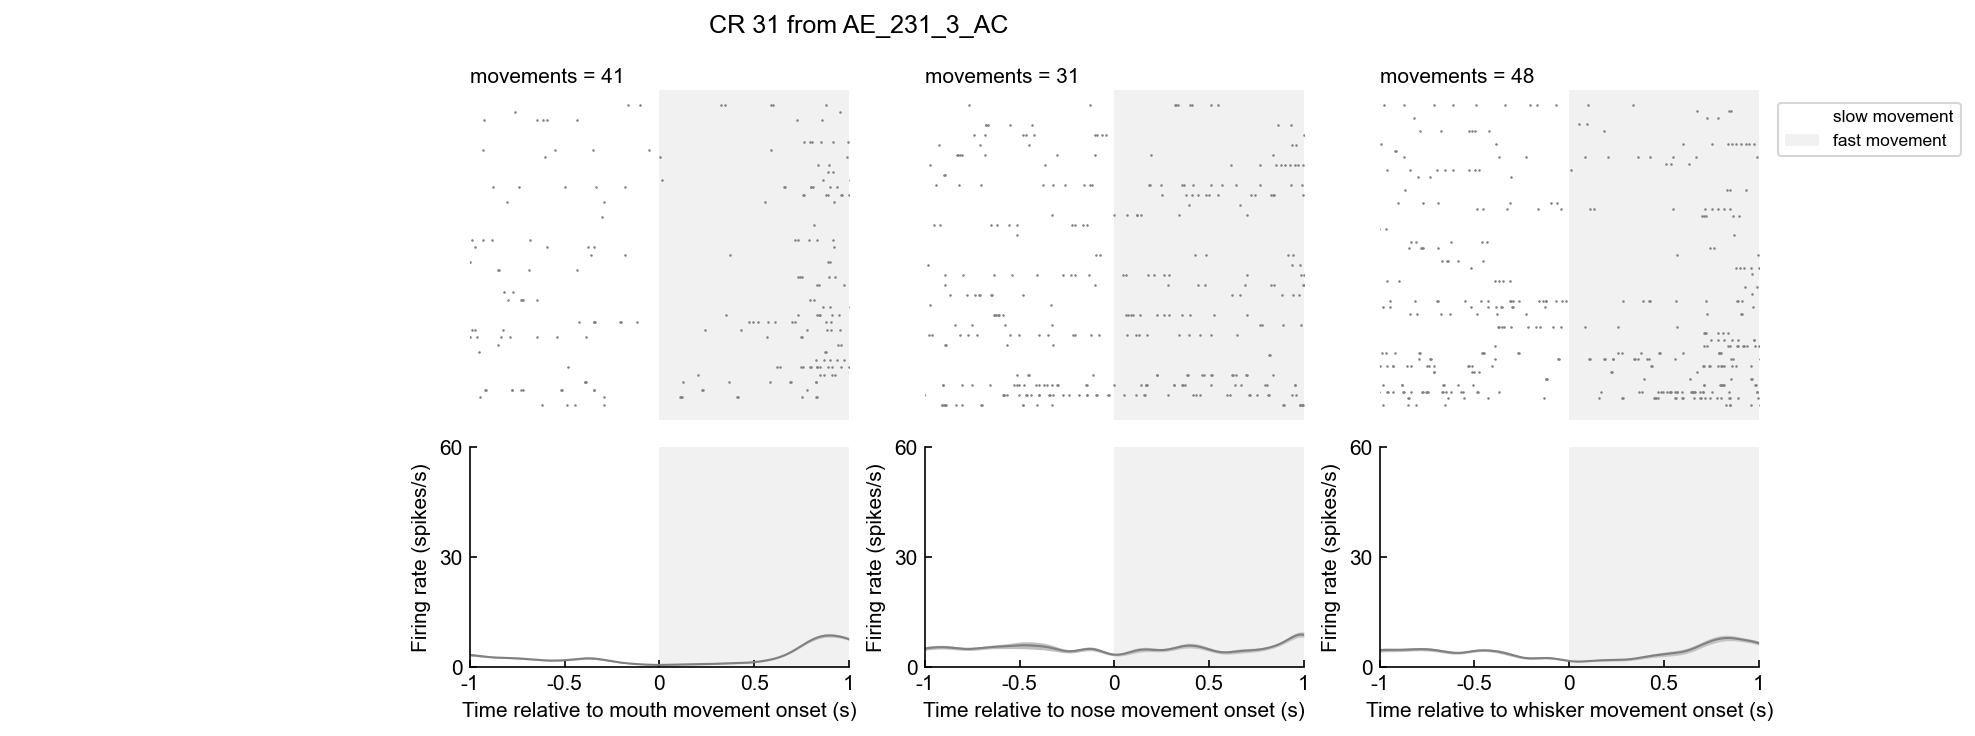

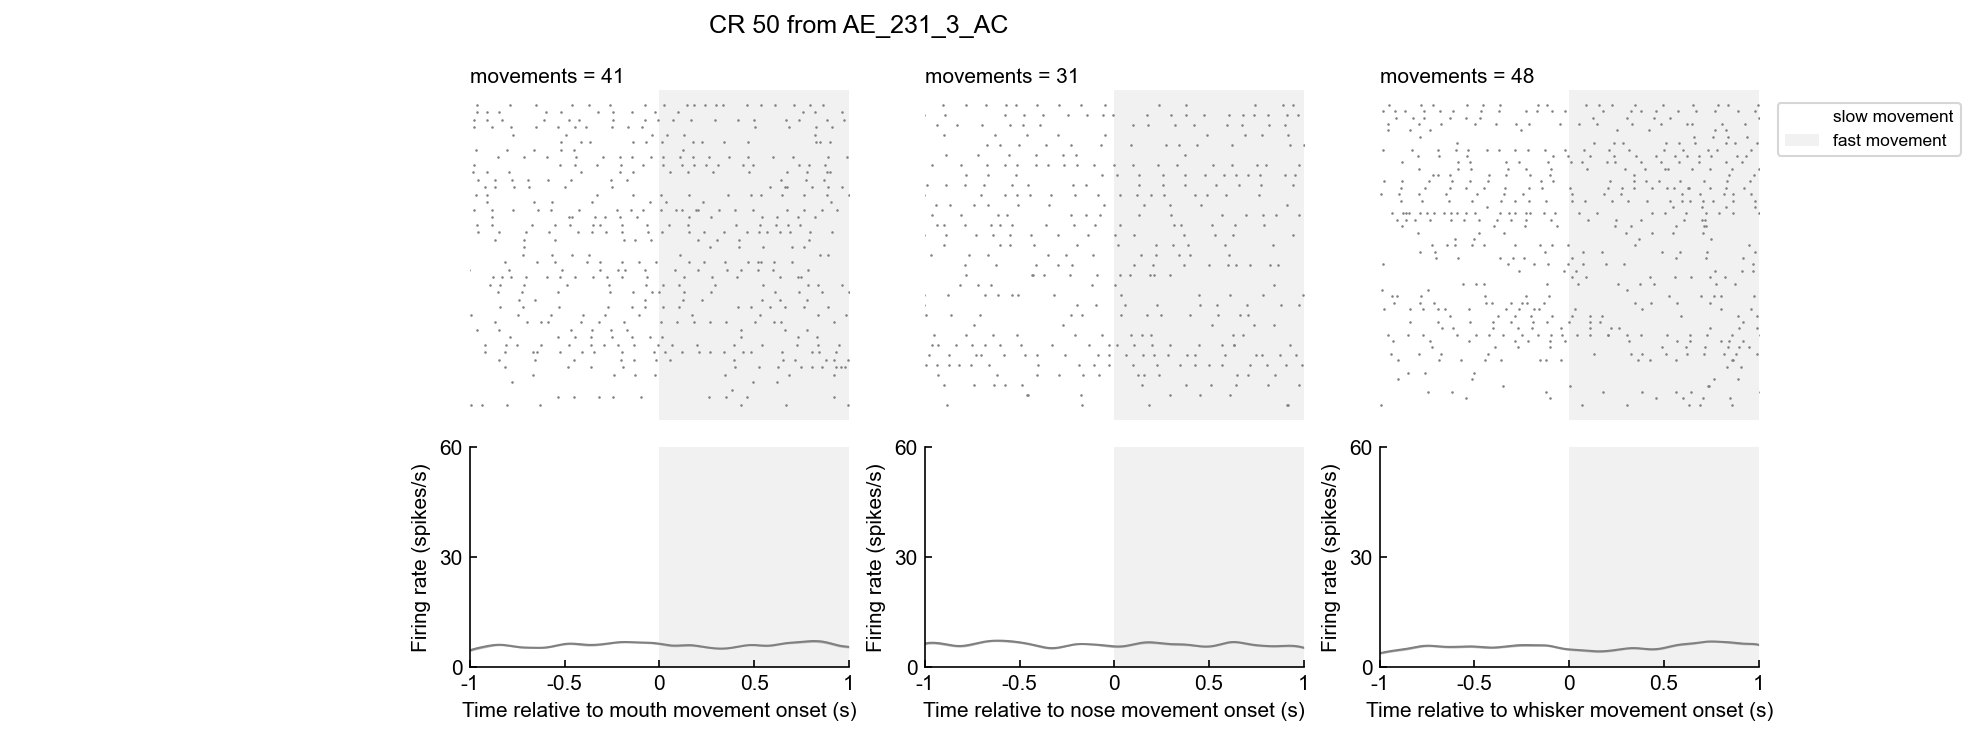

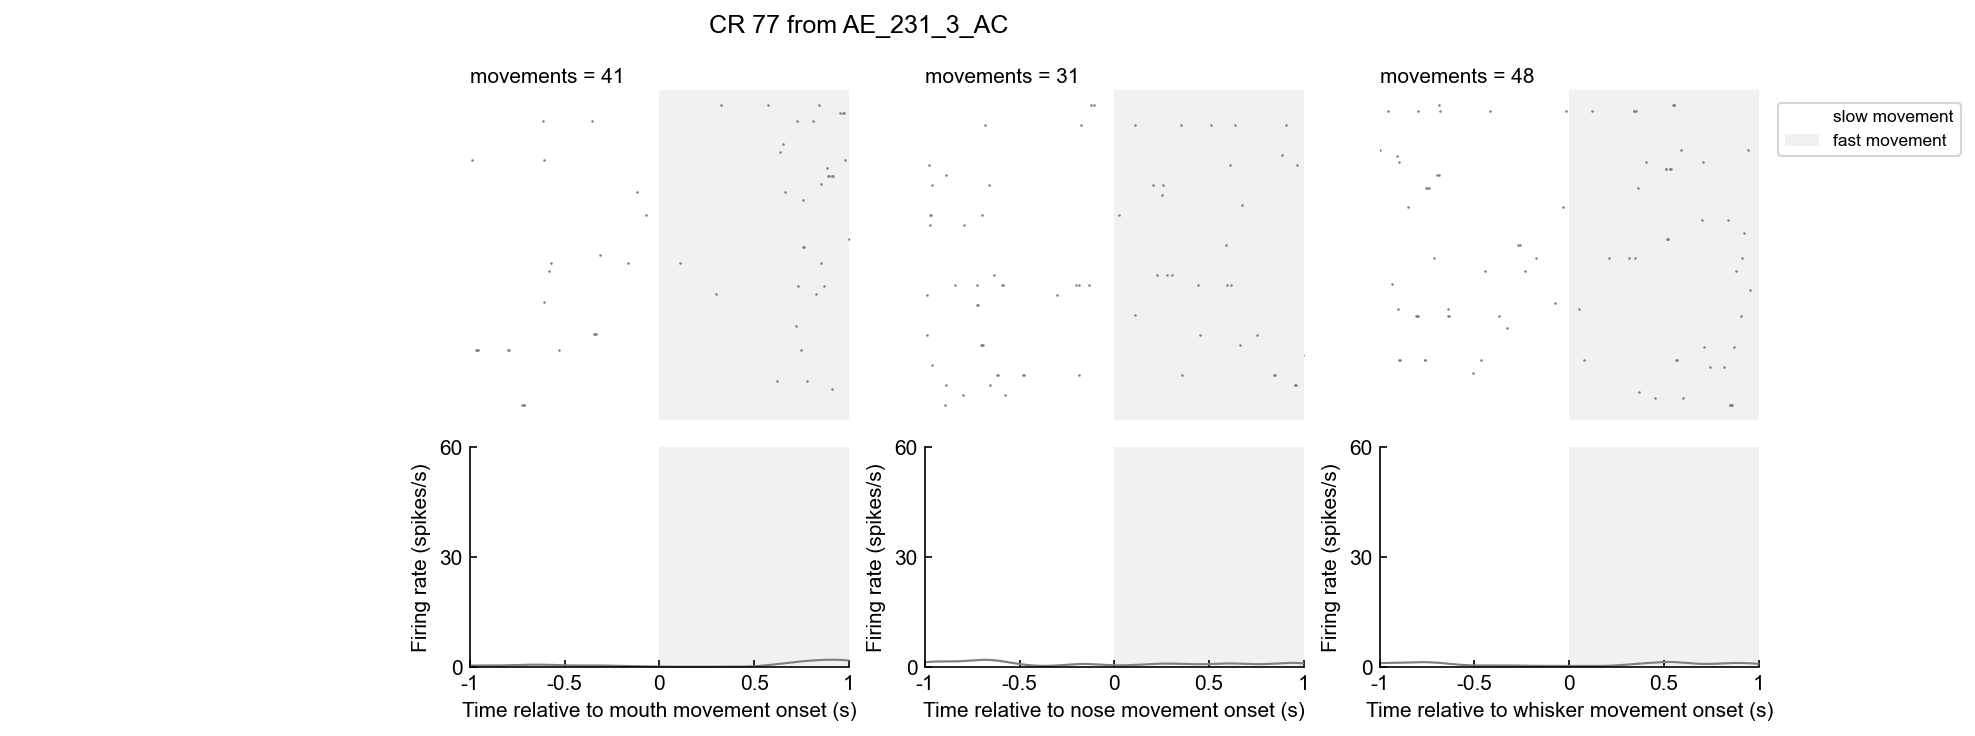

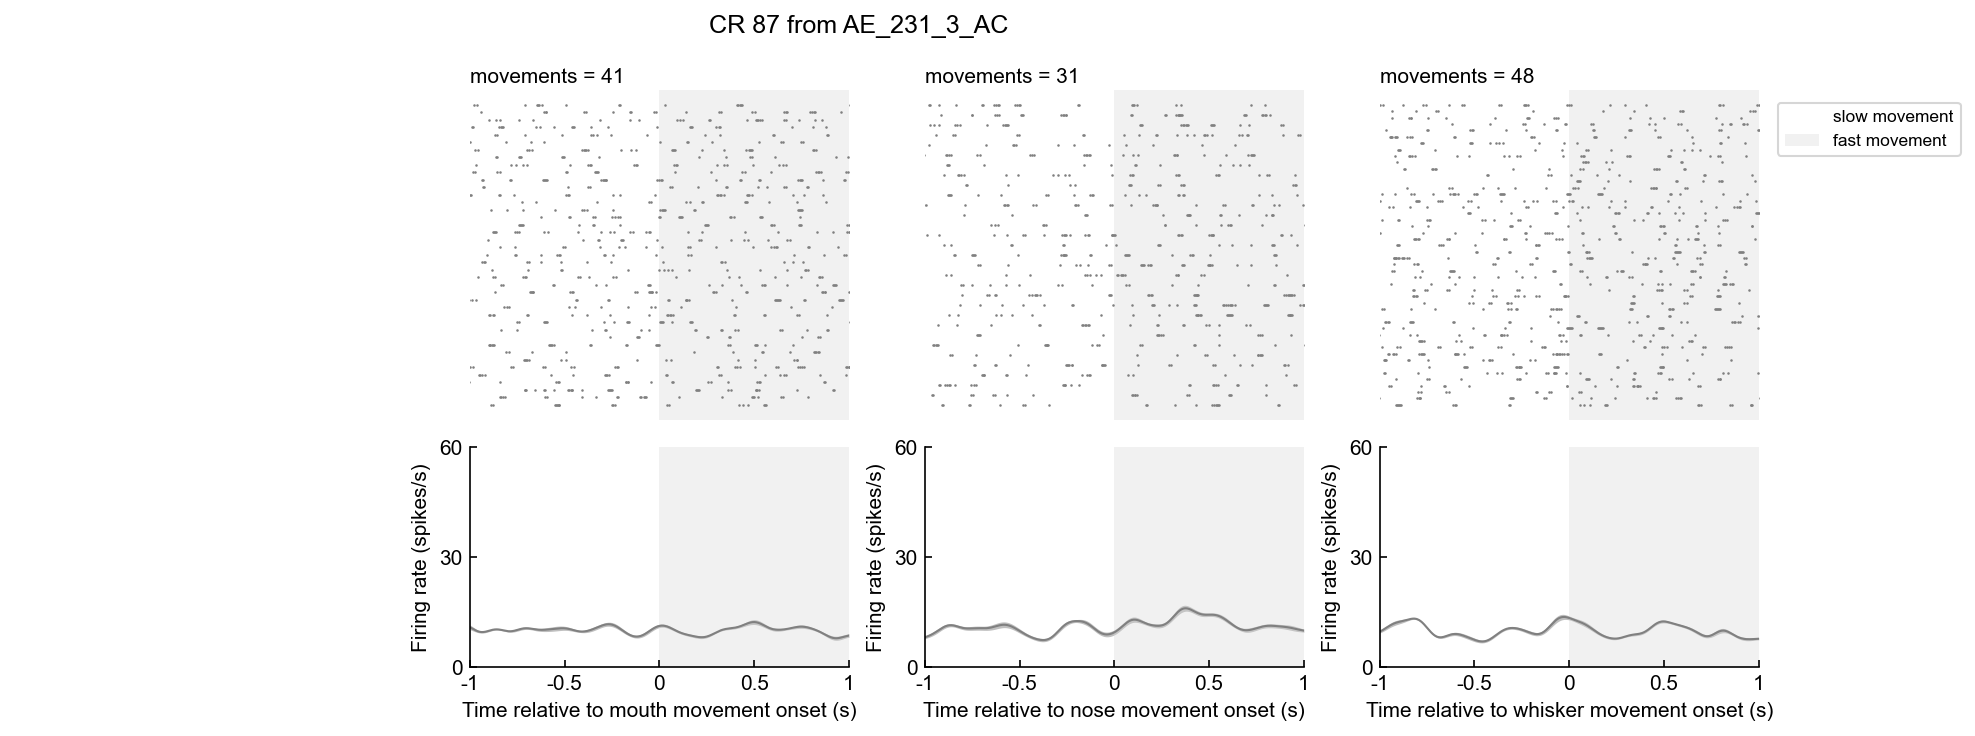

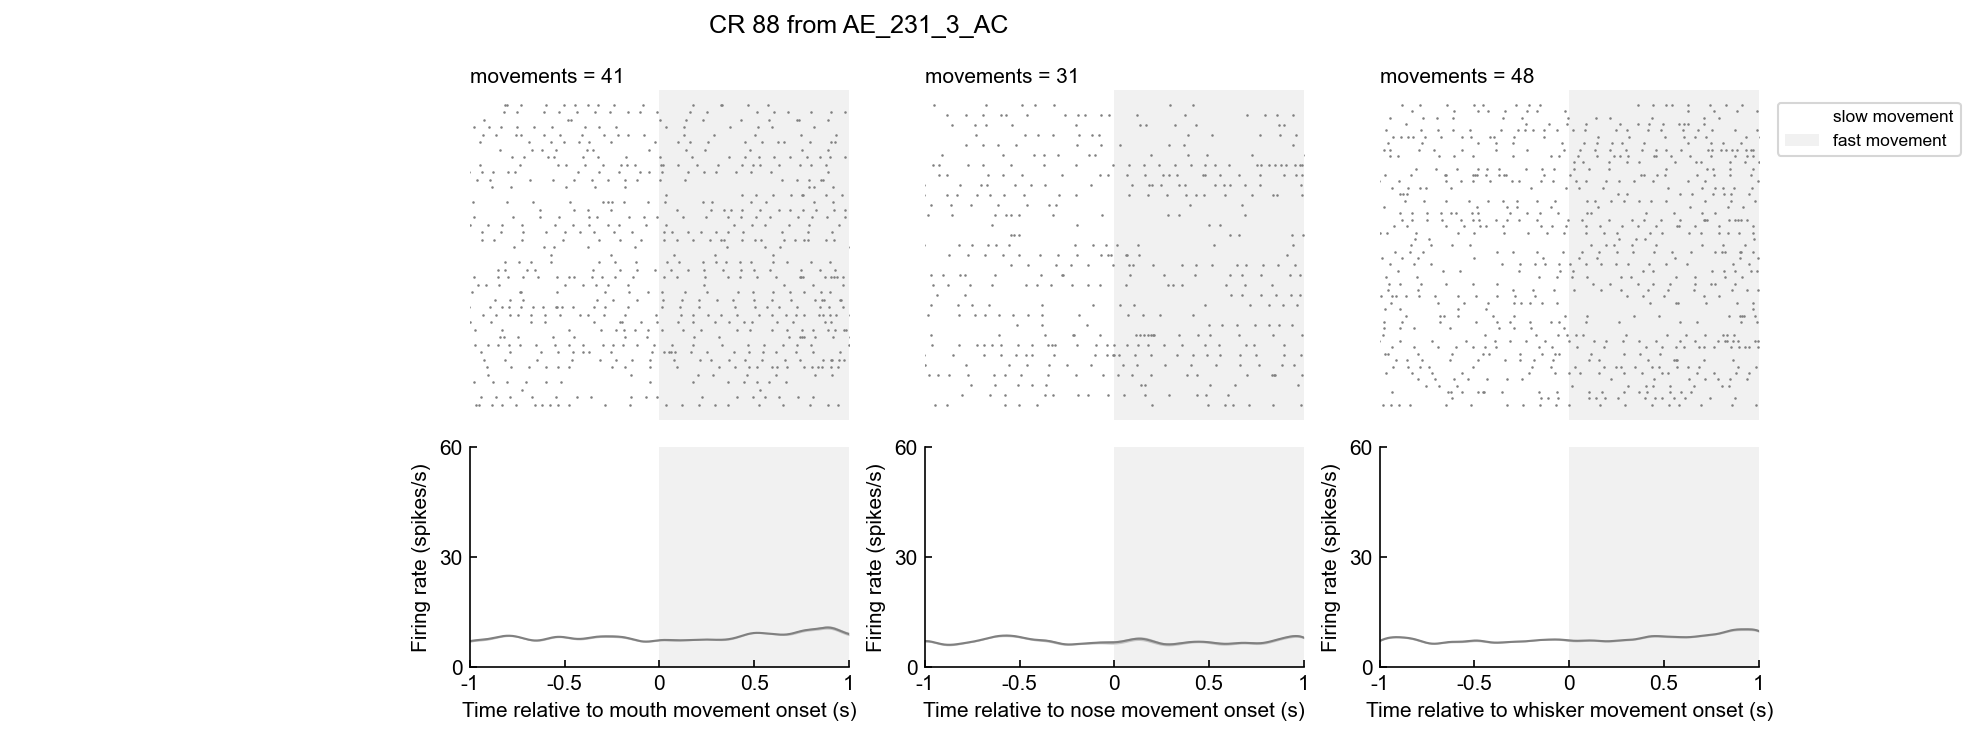

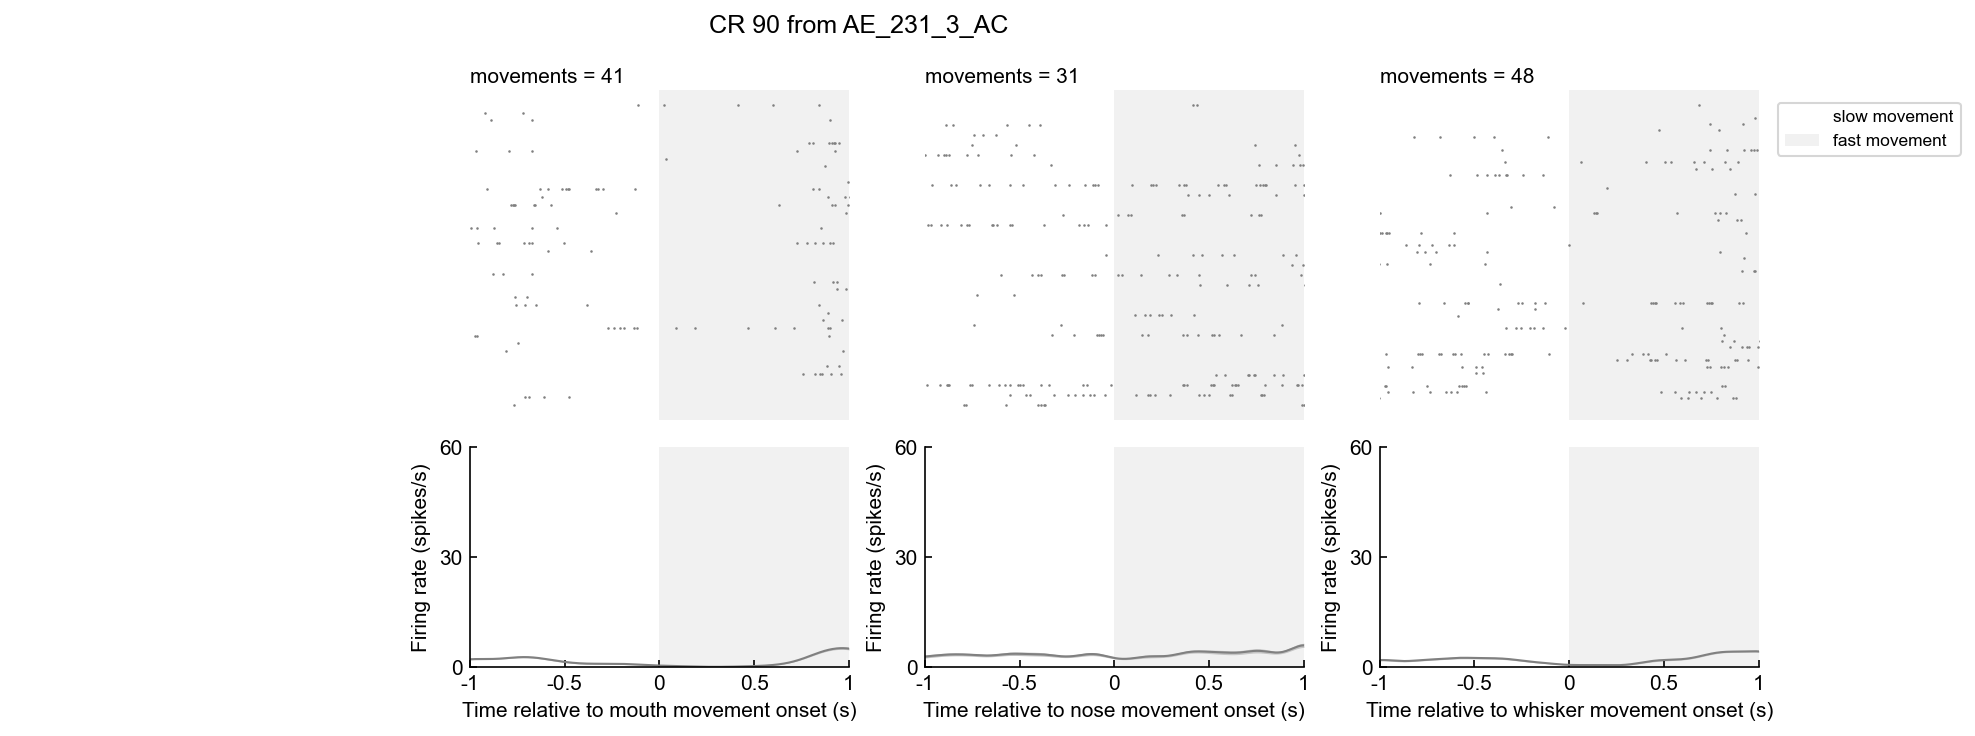

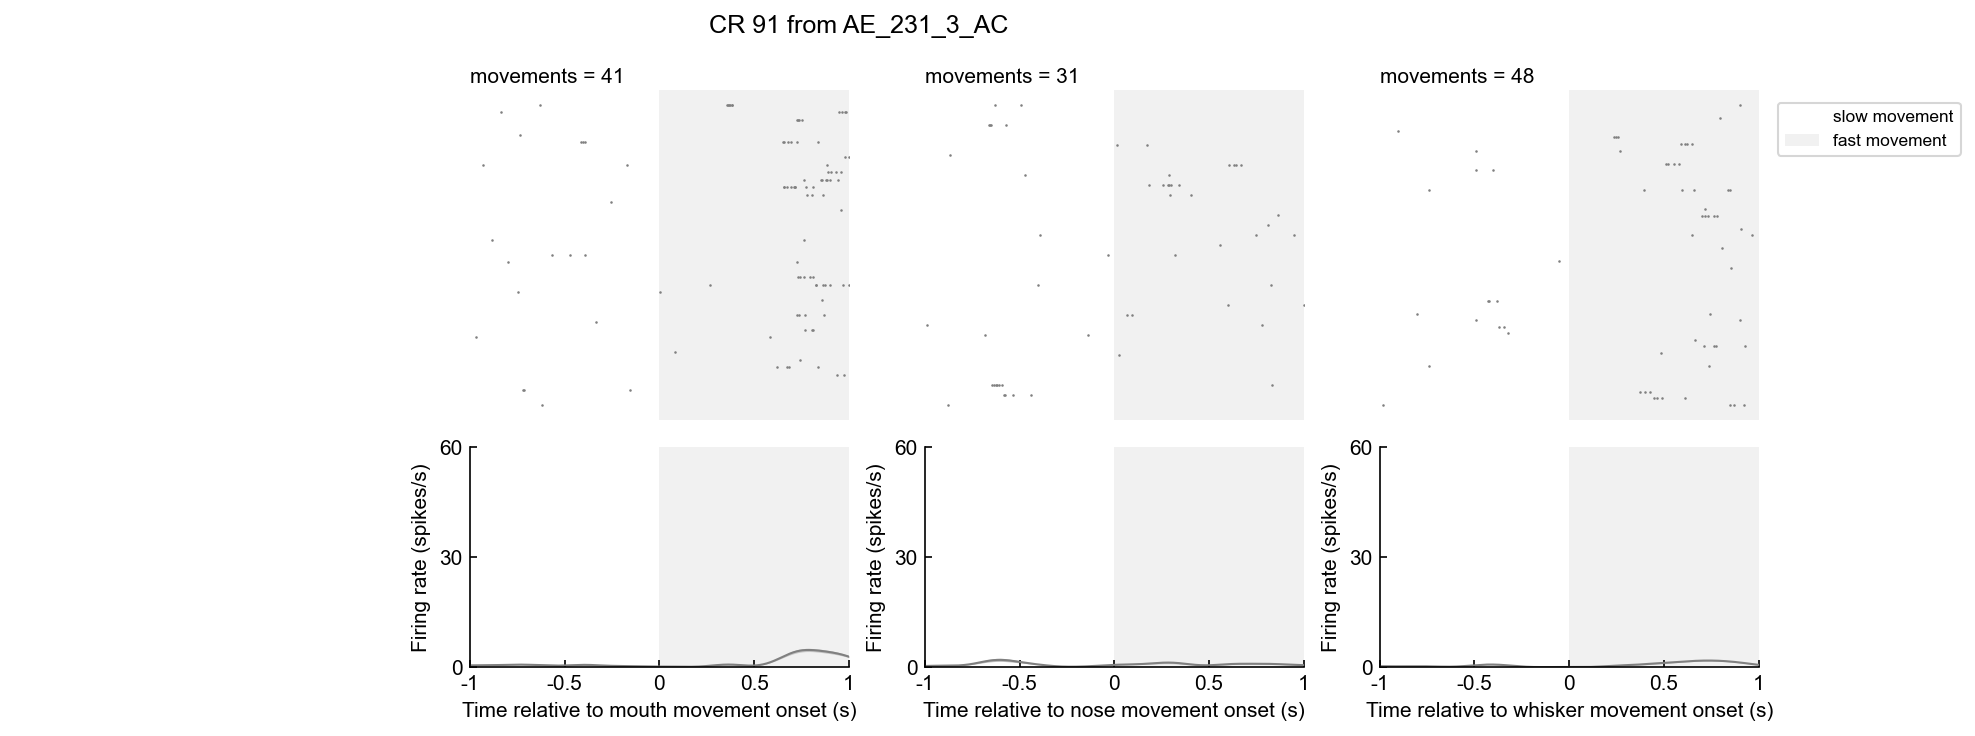

In [73]:
############same plot for CR
CR_integrate_limit_arr = []
CR_mouth_limit_arr = []
CR_nose_limit_arr = []
CR_whisker_limit_arr = []
for clust in CR_D9:
    CR_integrate_limit = CalculateforRasterPSTHLimit(sessionfile_D9,clust,integrate_3003_movement_onset_samples_arr)
    CR_integrate_limit_arr.append(CR_integrate_limit)
 
    CR_mouth_limit = CalculateforRasterPSTHLimit(sessionfile_D9,clust, mouth_3003_movement_onset_samples_arr)
    CR_mouth_limit_arr.append(CR_mouth_limit)
    
    CR_nose_limit = CalculateforRasterPSTHLimit(sessionfile_D9,clust, nose_3003_movement_onset_samples_arr)
    CR_nose_limit_arr.append(CR_nose_limit)
    
    CR_whisker_limit = CalculateforRasterPSTHLimit(sessionfile_D9,clust,whisker_3003_movement_onset_samples_arr)
    CR_whisker_limit_arr.append(CR_whisker_limit)

CR_integrate_limit_arr=np.array(CR_integrate_limit_arr)
CR_mouth_limit_arr = np.array(CR_mouth_limit_arr)
CR_nose_limit_arr = np.array(CR_nose_limit_arr)
CR_whisker_limit_arr = np.array(CR_whisker_limit_arr)
CR_limit_arr = np.concatenate((CR_integrate_limit_arr,CR_mouth_limit_arr,CR_nose_limit_arr,CR_whisker_limit_arr))

from matplotlib.backends.backend_pdf import PdfPages
from matplotlib import pyplot as plt, patches

file_allmove = 'C:\\Users\\insan\\Desktop\\Motion final\\Raster and PSTH for individual CR.pdf'
with PdfPages(file_allmove) as pdf:
    for clust in CR_D9:
        fig = visualizeClusterMovement(sessionfile_D9,clust,CR_limit_arr,'CR')
        pdf.savefig(fig)
        plt.close('all')

for clust in CR_D9:
    fig = visualizeClusterMovement(sessionfile_D9,clust,CR_limit_arr,'CR')
    fig.savefig(os.path.join('C:\\Users\insan\\Desktop\\Motion final\\png\\CR',ilep.generateDateString(sessionfile_D9)+' '+str(clust)+'.png'),transparent=False,facecolor="white")
    

In [73]:
#############Plot PSTH across all NCR and CR cells DONT DELETE

In [74]:
############# NORMALIZE FR

In [99]:
 def CalculateforRasterPSTHAcrossCellsNormalize(movementsToPlots):
    
    def CalculateClustFR(clust):
        moveSpikes = []
        for movement in movementsToPlots:
            this_move_spike = ilep.getSpikeTimes(sessionfile_D9,clust=clust,starttime=movement-33000, endtime=movement+33000)
            moveSpikes.append(this_move_spike-movement)
        moveSpikes = np.array(moveSpikes,dtype='object') 
        
        bw_scott_factor = 3
        starttime = -30000 #samples
        endtime = starttime+60000 #samples
        xrange = np.linspace(starttime,endtime,num=1000)
        FR = np.full((10,len(xrange)),np.nan) 
        kf = KFold(n_splits=10)

        for idx,(move_index,_) in enumerate(kf.split(moveSpikes)):
            PSTHspikes = np.concatenate(moveSpikes[move_index])
            bw = len(PSTHspikes)**(-1./5) / bw_scott_factor
            KDE = gaussian_kde(PSTHspikes,bw_method=bw)
            FR[idx,:] = KDE.evaluate(xrange)
            FR[idx,:] = FR[idx,:] * len(PSTHspikes) / len(move_index) *30000 #convert unit to seconds from samples
            
        avg_FR = np.mean(FR,axis=0) 
        base_FR = np.mean(avg_FR[:250]) 
        norm_FR = avg_FR/base_FR - 1
        #print(len(avg_FR))
        #print(len(norm_FR))

        return avg_FR, norm_FR 
    ###############  
    CR_norm_FR = []
    for clust in CR_D9:
        norm_FR = CalculateClustFR(clust)[1]
        CR_norm_FR.append(norm_FR)
    CR_norm_FR = np.array(CR_norm_FR)
    
    NCR_norm_FR = []
    for clust in NCR_D9:
        norm_FR = CalculateClustFR(clust)[1]
        NCR_norm_FR.append(norm_FR)
    NCR_norm_FR = np.array(NCR_norm_FR)
     
    CR_norm = np.mean(CR_norm_FR,axis=0)
    CR_sem = np.std(CR_norm_FR,axis=0)
    NCR_norm = np.mean(NCR_norm_FR,axis=0)
    NCR_sem = np.std(NCR_norm_FR,axis=0)
    return CR_norm, NCR_norm, CR_sem, NCR_sem

In [100]:
#CalculateforRasterPSTHAcrossCellsNormalize(mouth_3003_movement_onset_samples_arr)

In [117]:
CR_COLOR = '#808080'
NCR_COLOR = '#FF767C'

def visualizeClusterMovementAcrossCellsNormalize():
    movementsToPlots = [integrate_3003_movement_onset_samples_arr,mouth_3003_movement_onset_samples_arr,
                   nose_3003_movement_onset_samples_arr,whisker_3003_movement_onset_samples_arr]

    FRmod = sessionfile.responsiveness[clust]['all_trials'].FRmodulation
    FRmod_color = NCR_CR_cmap( (FRmod-1)/5)
    #########################################################################################
    region = sessionfile.meta.region
    #########################################################################################

    fig = plt.figure(figsize=(15,5))
    #fig.suptitle('Normalized PSTH for all cells and speed plots')
    
    gs = fig.add_gridspec(2,4,height_ratios=[0.4,0.4],hspace=0.5)
    #Mouth
    ax2 = plt.subplot(gs[0,1])#PSTH
    #Nose
    ax3 = plt.subplot(gs[0,2],sharey=ax2)#PSTH
    #Whisker
    ax4 = plt.subplot(gs[0,3],sharey=ax2)#PSTH
    #Integrate
    ax1 = plt.subplot(gs[0,0],sharey=ax2)#PSTH 
    
    ax_PSTH = [ax2,ax3,ax4]
    
    ax5 = plt.subplot(gs[1,0],sharex=ax2)
    #Speed plot
    ax6 = plt.subplot(gs[1,1])
    ax7 = plt.subplot(gs[1,2],sharex=ax6)
    ax8 = plt.subplot(gs[1,3],sharex=ax6)
  

    ax5.spines['bottom'].set_visible(False)
    ax5.spines['left'].set_visible(False)
    ax5.get_xaxis().set_visible(False)
    ax5.get_yaxis().set_visible(False)
    ax5.scatter(np.random.rand(20),np.random.rand(20),color='r',alpha=0,s=1.5,marker='o',lw=0)
    
    ax1.spines['bottom'].set_visible(False)
    ax1.spines['left'].set_visible(False)
    ax1.get_xaxis().set_visible(False)
    ax1.get_yaxis().set_visible(False)
    
    #PSTH
    starttime = -30000 #samples
    endtime = starttime+60000 #samples
    xrange = np.linspace(starttime,endtime,num=1000)
    #Not show(integrate movement)
    NCR_noravg_FR_Integrate = CalculateforRasterPSTHAcrossCellsNormalize(movementsToPlots[0])[1]
    NCR_norsem_FR_Integrate =  CalculateforRasterPSTHAcrossCellsNormalize(movementsToPlots[0])[3]
    CR_noravg_FR_Integrate = CalculateforRasterPSTHAcrossCellsNormalize(movementsToPlots[0])[0]
    CR_norsem_FR_Integrate =  CalculateforRasterPSTHAcrossCellsNormalize(movementsToPlots[0])[2]
    ax1.plot(xrange,NCR_noravg_FR_Integrate, lw=1,color=NCR_COLOR,label = 'NCR n=7',alpha=0)
    #ax1.fill_between(xrange,NCR_noravg_FR_Integrate-NCR_norsem_FR_Integrate,NCR_noravg_FR_Integrate+NCR_norsem_FR_Integrate,color=NCR_COLOR,alpha=0,zorder=-10,lw=0)
    ax1.set_xlabel('Time relative to all movement onset (s)')
    
    #Show
    NCR_noravg_FR_Mouth = CalculateforRasterPSTHAcrossCellsNormalize(movementsToPlots[1])[1]
    NCR_norsem_FR_Mouth = CalculateforRasterPSTHAcrossCellsNormalize(movementsToPlots[1])[3]
    CR_noravg_FR_Mouth = CalculateforRasterPSTHAcrossCellsNormalize(movementsToPlots[1])[0]
    CR_norsem_FR_Mouth =  CalculateforRasterPSTHAcrossCellsNormalize(movementsToPlots[1])[2]
    ax2.plot(xrange,NCR_noravg_FR_Mouth, lw=1,color=NCR_COLOR,label = 'NCR')
    ax2.plot(xrange,CR_noravg_FR_Mouth,lw=1,color=CR_COLOR,label = 'CR')
    ax2.fill_between(xrange,NCR_noravg_FR_Mouth-NCR_norsem_FR_Mouth,NCR_noravg_FR_Mouth+NCR_norsem_FR_Mouth,color=NCR_COLOR,alpha=0.2,zorder=-10,lw=0)
    ax2.fill_between(xrange,CR_noravg_FR_Mouth-CR_norsem_FR_Mouth,CR_noravg_FR_Mouth+CR_norsem_FR_Mouth,color=CR_COLOR,alpha=0.2,zorder=-10,lw=0)
    ax2.set_xlabel('Time relative to mouth movement onset (s)')
        
    NCR_noravg_FR_Nose = CalculateforRasterPSTHAcrossCellsNormalize(movementsToPlots[2])[1]
    NCR_norsem_FR_Nose = CalculateforRasterPSTHAcrossCellsNormalize(movementsToPlots[2])[3]
    CR_noravg_FR_Nose = CalculateforRasterPSTHAcrossCellsNormalize(movementsToPlots[2])[0]
    CR_norsem_FR_Nose = CalculateforRasterPSTHAcrossCellsNormalize(movementsToPlots[2])[2]
    ax3.plot(xrange,NCR_noravg_FR_Nose, lw=1,color=NCR_COLOR,label = 'NCR')
    ax3.plot(xrange,CR_noravg_FR_Nose,lw=1,color=CR_COLOR,label = 'CR')
    ax3.fill_between(xrange,NCR_noravg_FR_Nose-NCR_norsem_FR_Nose,NCR_noravg_FR_Nose+NCR_norsem_FR_Nose,color=NCR_COLOR,alpha=0.2,zorder=-10,lw=0)
    ax3.fill_between(xrange,CR_noravg_FR_Nose-CR_norsem_FR_Nose,CR_noravg_FR_Nose+CR_norsem_FR_Nose,color=CR_COLOR,alpha=0.2,zorder=-10,lw=0)
    ax3.set_xlabel('Time relative to nose movement onset (s)')
    
    NCR_noravg_FR_Whisker = CalculateforRasterPSTHAcrossCellsNormalize(movementsToPlots[3])[1]
    NCR_norsem_FR_Whisker = CalculateforRasterPSTHAcrossCellsNormalize(movementsToPlots[3])[3]
    CR_noravg_FR_Whisker = CalculateforRasterPSTHAcrossCellsNormalize(movementsToPlots[3])[0]
    CR_norsem_FR_Whisker = CalculateforRasterPSTHAcrossCellsNormalize(movementsToPlots[3])[2]
    ax4.plot(xrange,NCR_noravg_FR_Whisker, lw=1,color=NCR_COLOR)
    ax4.plot(xrange,CR_noravg_FR_Whisker,lw=1,color=CR_COLOR)
    ax4.fill_between(xrange,NCR_noravg_FR_Whisker-NCR_norsem_FR_Whisker,NCR_noravg_FR_Whisker+NCR_norsem_FR_Whisker,color=NCR_COLOR,alpha=0.2,zorder=-10,lw=0)
    ax4.fill_between(xrange,CR_noravg_FR_Whisker-CR_norsem_FR_Whisker,CR_noravg_FR_Whisker+CR_norsem_FR_Whisker,color=CR_COLOR,alpha=0.2,zorder=-10,lw=0)
    ax4.set_xlabel('Time relative to whisker movement onset (s)')
    
    ax1.set_ylim([-1,4])
    ax1.set_yticks([-1,0,1,2,3,4]) 
    #ax1.set_yticklabels(['0.2','0.6','1.0']) #plot purposes
 
    

    for ax in ax_PSTH:
        ax.axvspan(-30000,0, ymin=0,color='white', alpha=0.3, lw=0,label='slow movement') 
        ax.axvspan(0, 30000, ymin=0,color='lightgray', alpha=0.3, lw=0, label = 'fast movement')
        ax.set_ylabel('Normalized change in firing rate')
        ax.set_xlim([-30000,30000])
        ax.set_xticks([-30000,-15000,0,15000, 30000])
        #ax.set_xticklabels(['-100','-0.5','0','0.5','1']) #for plot purposes
        ax.set_xticklabels(['-1','-0.5','0','0.5','1']) #real
        #ax.text(18000,1.5,'NCR n=7',color=NCR_COLOR)
        #ax.text(18000,1.5+0.25,'CR n=11',color=CR_COLOR)
    
    ax4.legend(frameon=True,loc=(1.05,0.7))

    #Speed plot
    #Mouth speed plot
    ax6.plot(avg_mouth_3003_speed,color='#969696')
    ax6.set_xlim([100,300])
    #ax6.set_xticklabels(['-100','-50','0','50','100'])
    ax6.set_ylabel('Averaged speed (mouth)')
    ax6.set_xlabel('Time relative to mouth movement onset \n(frames)')
    #ax6.axvline(200,color='black',linestyle='--',zorder=10,lw=1)
    ax6.set_ylim([0.2,1])
    ax6.set_yticks([0.2,0.6,1.0])
    ax6.axvspan(200, 300, ymin=0,color='lightgray', alpha=0.3, lw=0)
    
    #Nose speed plot
    ax7.plot(avg_nose_3003_speed,color='#969696')
    ax7.set_xlim([100,300])
    ax7.set_xticklabels(['-100','-50','0','50','100'])
    ax7.set_ylabel('Averaged speed (nose)')
    ax7.set_xlabel('Time relative to nose movement onset \n(frames)')
    #ax7.axvline(200,color='black',linestyle='--',zorder=10,lw=1)
    ax7.set_ylim([0.2,1])
    ax7.set_yticks([0.2,0.6,1.0])
    ax7.axvspan(200, 300, ymin=0,color='lightgray', alpha=0.3, lw=0)
    
    #Whisker speed plot
    ax8.plot(avg_whisker_3003_speed,color='#969696')
    ax8.set_xlim([100,300])
    ax8.set_xticklabels(['-100','-50','0','50','100'])
    ax8.set_ylabel('Averaged speed (whisker)')
    ax8.set_xlabel('Time relative to whisker movement onset \n(frames)')
    #ax8.axvline(200,color='black',linestyle='--',zorder=10,lw=1)
    ax8.set_ylim([0.2,1])
    ax8.set_yticks([0.2,0.6,1.0])
    ax8.axvspan(200, 300, ymin=0,color='lightgray', alpha=0.3, lw=0)
    
    plt.close()
    return fig
    

C:\Users\insan\AppData\Local\Temp\ipykernel_92468\3910351609.py:125: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax7.set_xticklabels(['-100','-50','0','50','100'])
C:\Users\insan\AppData\Local\Temp\ipykernel_92468\3910351609.py:136: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax8.set_xticklabels(['-100','-50','0','50','100'])


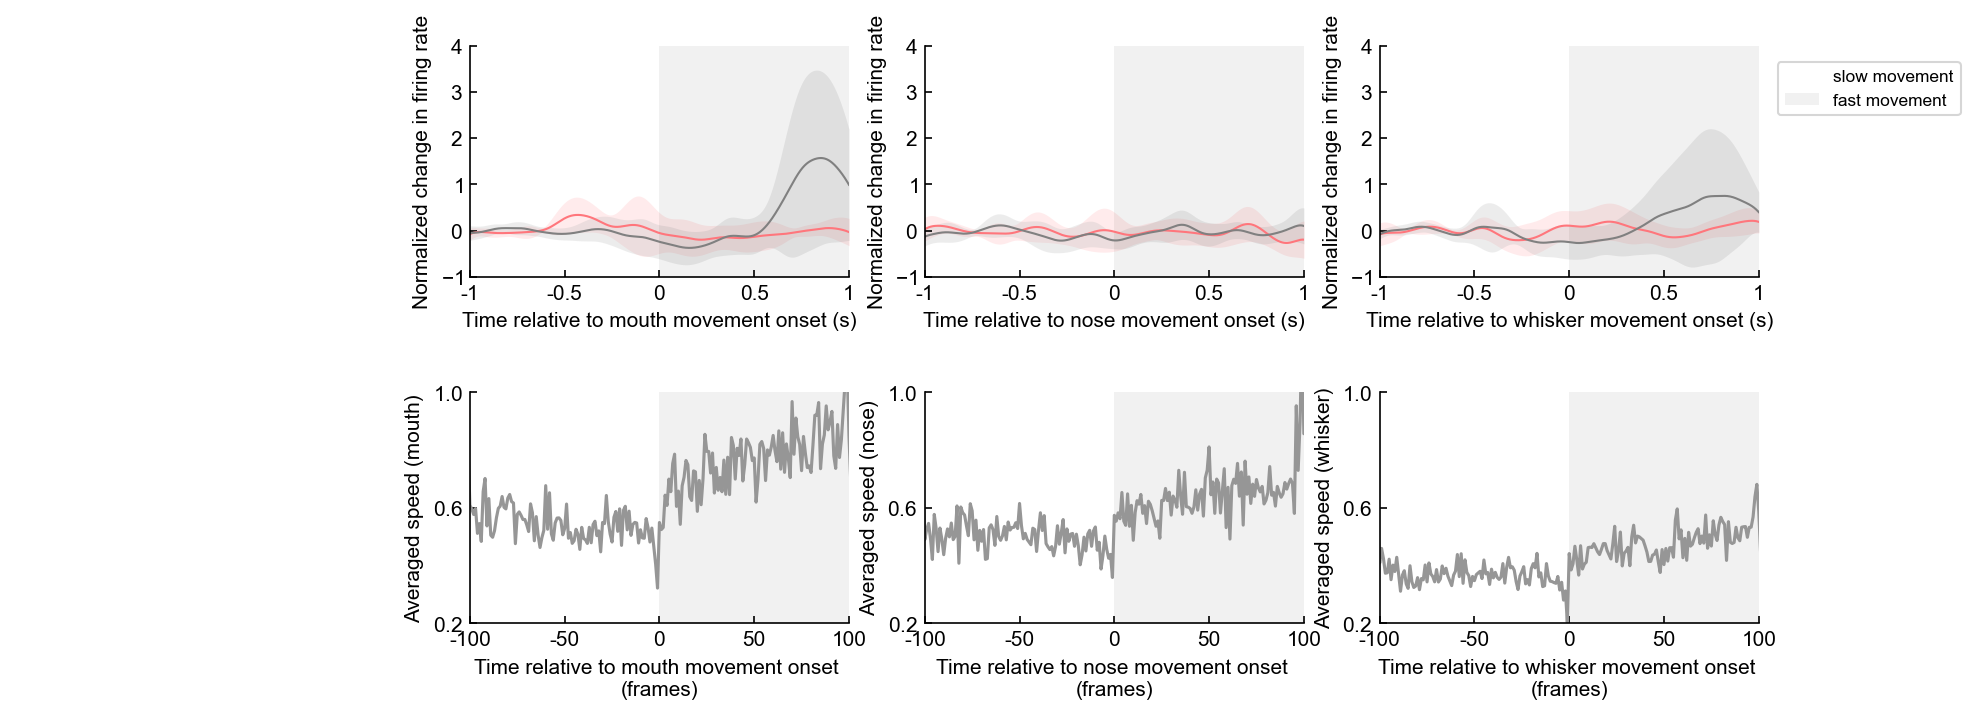

In [180]:
fig = visualizeClusterMovementAcrossCellsNormalize()
#fig.savefig(os.path.join('C:\\Users\insan\\Desktop\\Motion final\\png\\Normalized PSTH across all CRs and NCRs.png'),transparent=False,facecolor="white")
fig


# New figs with final style (Oct 2023)

### Speed

In [75]:
print(len(sem_mouth_3003_speed))
print(len(avg_mouth_3003_speed))

400
400


In [76]:
range(100,300)

range(100, 300)

meta NOT subset; don't know how to subset; dropped


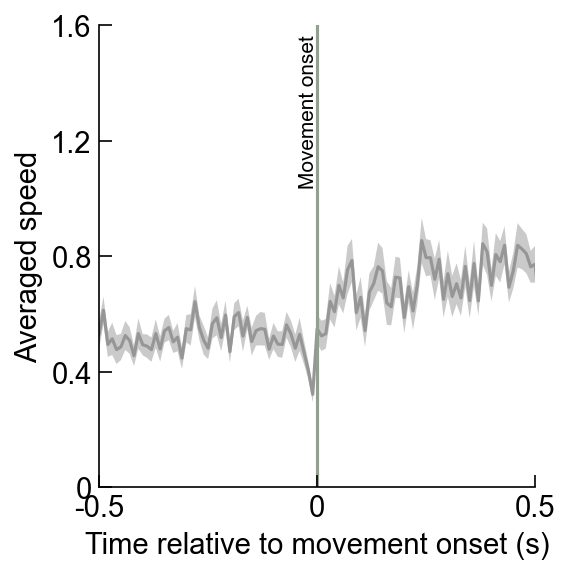

In [84]:
stdfont = 14
stdyfrac = 0.06

fig, ax = plt.subplots(figsize=(3.75,4))
#Mouth speed plot
#ax.axvspan(200, 250, ymin=0,color='#e8f4e4', lw=0,zorder=-11)
#ax.axvspan(150, 200, ymin=0,color='white', alpha=0.3, lw=0,label='slow',zorder=-11)
ax.plot(avg_mouth_3003_speed,color='#969696')
ax.fill_between(np.arange(0,400),avg_mouth_3003_speed-sem_mouth_3003_speed,avg_mouth_3003_speed+sem_mouth_3003_speed,color='#969696',alpha=0.5,zorder=-10,lw=0)

ax.set_xlim([150,250])
ax.set_xticks([150,200,250])
ax.set_xticklabels(['-0.5','0','0.5'])
ax.set_ylabel('Averaged speed')
ax.set_xlabel('Time relative to movement onset (s)')

ax.set_ylim([0,1.6])
ax.set_yticks([0,0.4,0.8,1.2,1.6])
ax.set_yticklabels(['0','0.4','0.8','1.2','1.6'])


ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)
ax.tick_params(length=6)
ax.set_axisbelow(False)

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
    ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(stdfont)

ax.text(198,1.3,'Movement onset',color='black',horizontalalignment='center',verticalalignment='center',rotation=90,fontsize=10)
ax.axvline(200,0,1.6,color='#92a18d')

fig.savefig(os.path.join('C:\\Users\insan\\Desktop\\Motion new\\mouth speed.pdf'),transparent=False,facecolor="white", bbox_inches = 'tight')

meta NOT subset; don't know how to subset; dropped


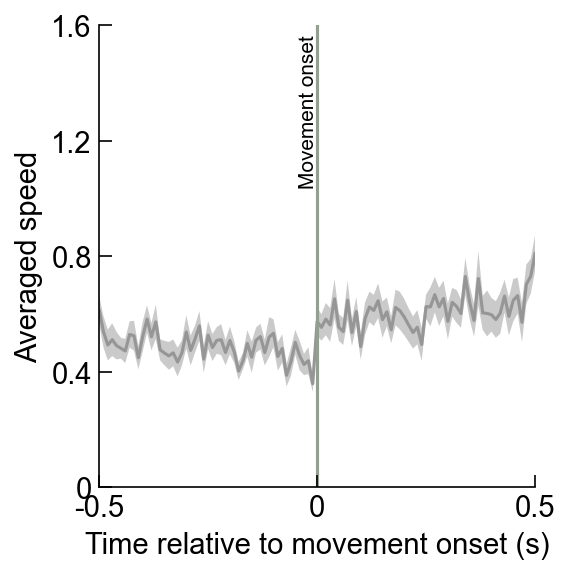

In [85]:
fig, ax = plt.subplots(figsize=(3.75,4))
#Nose speed plot
#ax.axvspan(200, 250, ymin=0,color='#e8f4e4', lw=0,zorder=-11)
#ax.axvspan(150, 200, ymin=0,color='white', alpha=0.3, lw=0,label='slow',zorder=-11)
ax.plot(avg_nose_3003_speed,color='#969696')
ax.fill_between(np.arange(0,400),avg_nose_3003_speed-sem_nose_3003_speed,avg_nose_3003_speed+sem_nose_3003_speed,color='#969696',alpha=0.5,zorder=-10,lw=0)

ax.set_xlim([150,250])
ax.set_xticks([150,200,250])
ax.set_xticklabels(['-0.5','0','0.5'])
ax.set_ylabel('Averaged speed')
ax.set_xlabel('Time relative to movement onset (s)')

ax.set_ylim([0,1.6])
ax.set_yticks([0,0.4,0.8,1.2,1.6])
ax.set_yticklabels(['0','0.4','0.8','1.2','1.6'])
ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)
ax.tick_params(length=6)
ax.set_axisbelow(False)

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
    ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(stdfont)
ax.text(198,1.3,'Movement onset',color='black',horizontalalignment='center',verticalalignment='center',rotation=90,fontsize=10)
ax.axvline(200,0,1.6,color='#92a18d')

fig.savefig(os.path.join('C:\\Users\insan\\Desktop\\Motion new\\nose speed.pdf'),transparent=False,facecolor="white", bbox_inches = 'tight')

meta NOT subset; don't know how to subset; dropped


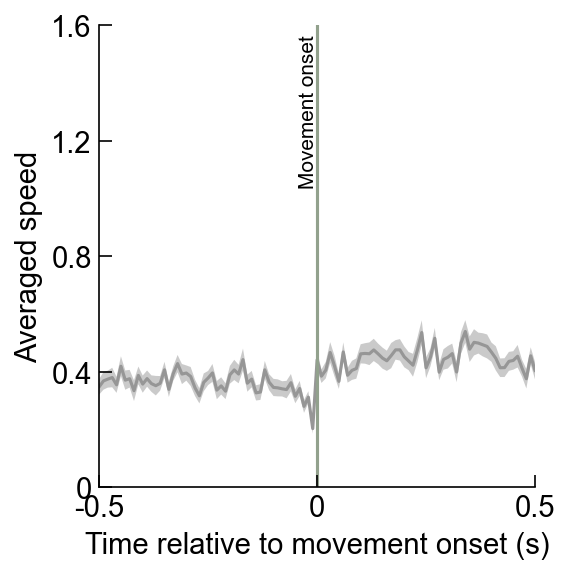

In [86]:
fig, ax = plt.subplots(figsize=(3.75,4))
#Whisker speed plot
#ax.axvspan(200, 250, ymin=0,color='#e8f4e4', lw=0,zorder=-11)
#ax.axvspan(150, 200, ymin=0,color='white', alpha=0.3, lw=0,label='slow',zorder=-11)

ax.plot(avg_whisker_3003_speed,color='#969696')
ax.fill_between(np.arange(0,400),avg_whisker_3003_speed-sem_whisker_3003_speed,avg_whisker_3003_speed+sem_whisker_3003_speed,color='#969696',alpha=0.5,zorder=-10,lw=0)

ax.set_xlim([150,250])
ax.set_xticks([150,200,250])
ax.set_xticklabels(['-0.5','0','0.5'])
ax.set_ylabel('Averaged speed')
ax.set_xlabel('Time relative to movement onset (s)')

ax.set_ylim([0,1.6])
ax.set_yticks([0,0.4,0.8,1.2,1.6])
ax.set_yticklabels(['0','0.4','0.8','1.2','1.6'])

ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)
ax.tick_params(length=6)
ax.set_axisbelow(False)

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
    ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(stdfont)

ax.text(198,1.3,'Movement onset',color='black',horizontalalignment='center',verticalalignment='center',rotation=90,fontsize=10)
ax.axvline(200,0,1.6,color='#92a18d')

fig.savefig(os.path.join('C:\\Users\insan\\Desktop\\Motion new\\whisker speed.pdf'),transparent=False,facecolor="white", bbox_inches = 'tight')

### FR

In [71]:
CR_D9

[3, 13, 15, 19, 31, 50, 77, 87, 88, 90, 91]

In [72]:
CR_D9 = [3, 15, 19, 31, 50, 77, 87, 88, 90, 91]


In [73]:
NCR_D9

[8, 33, 43, 44, 59, 92, 96]

### Non-Norm

In [98]:
stdfont = 14
stdyfrac = 0.06


In [99]:
 def CalculateforRasterPSTHAcrossCells(movementsToPlots):
    
    def CalculateClustFR(clust):
        moveSpikes = []
        for movement in movementsToPlots:
            this_move_spike = ilep.getSpikeTimes(sessionfile_D9,clust=clust,starttime=movement-33000, endtime=movement+33000)
            moveSpikes.append(this_move_spike-movement)
        moveSpikes = np.array(moveSpikes,dtype='object') 
        
        bw_scott_factor = 3
        starttime = -30000 #samples
        endtime = starttime+60000 #samples
        xrange = np.linspace(starttime,endtime,num=1000)
        FR = np.full((10,len(xrange)),np.nan) 
        kf = KFold(n_splits=10)
    
        for idx,(move_index,_) in enumerate(kf.split(moveSpikes)):
            PSTHspikes = np.concatenate(moveSpikes[move_index])
            bw = len(PSTHspikes)**(-1./5) / bw_scott_factor
            KDE = gaussian_kde(PSTHspikes,bw_method=bw)
            FR[idx,:] = KDE.evaluate(xrange)
            FR[idx,:] = FR[idx,:] * len(PSTHspikes) / len(move_index) *30000 #convert unit to seconds from samples
        
        avg_FR = np.mean(FR,axis=0) 
    
        return avg_FR 
    
    ###############  
    NCR_avg_FR = []
    for clust in NCR_D9:
        avg_FR = CalculateClustFR(clust)
        NCR_avg_FR.append(avg_FR)
    NCR_avg_FR = np.array(NCR_avg_FR)
     
    NCR_avg = np.mean(NCR_avg_FR,axis=0)
    NCR_sem = sem(NCR_avg_FR,axis=0)
    #print(NCR_avg_FR[0])
    
    max_FR_value = np.max(NCR_avg+NCR_sem) * 1.1
    sequence_of_possible_axis_limits = np.array([1,2,4,6,8,10,12,16,20,30,40,50,60,80,100,120,140,150,160,180,200])
    idx_of_okay_limits = np.greater_equal(sequence_of_possible_axis_limits,max_FR_value)
    valid_limits = sequence_of_possible_axis_limits[idx_of_okay_limits]
    limit = np.min(valid_limits)
    ###
    CR_avg_FR = []
    for clust in CR_D9:
        avg_FR = CalculateClustFR(clust)
        CR_avg_FR.append(avg_FR)
    CR_avg_FR = np.array(CR_avg_FR)
     
    CR_avg = np.mean(CR_avg_FR,axis=0)
    CR_sem = sem(CR_avg_FR,axis=0)
    
    CR_max_FR_value = np.max(CR_avg+CR_sem) * 1.1
    CR_idx_of_okay_limits = np.greater_equal(sequence_of_possible_axis_limits,CR_max_FR_value)
    CR_valid_limits = sequence_of_possible_axis_limits[CR_idx_of_okay_limits]
    CR_limit = np.min(CR_valid_limits)
        
    return NCR_avg, NCR_sem, limit, CR_avg, CR_sem,CR_limit

In [100]:
#Non-normal
movementsToPlots = [integrate_3003_movement_onset_samples_arr,mouth_3003_movement_onset_samples_arr,
                    nose_3003_movement_onset_samples_arr,whisker_3003_movement_onset_samples_arr]

meta NOT subset; don't know how to subset; dropped


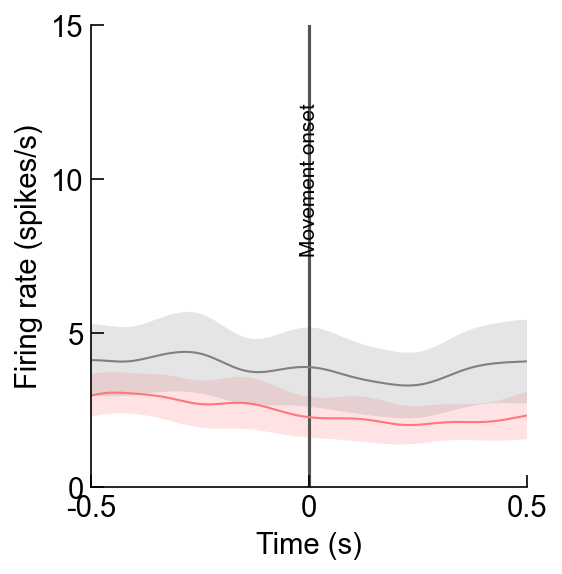

In [101]:
fig, ax = plt.subplots(figsize=(3.75,4))
    
#PSTH
starttime = -30000 #samples
endtime = starttime+60000 #samples
xrange = np.linspace(starttime,endtime,num=1000)

NCR_avg_FR_Mouth = CalculateforRasterPSTHAcrossCells(movementsToPlots[1])[0]
NCR_sem_FR_Mouth = CalculateforRasterPSTHAcrossCells(movementsToPlots[1])[1]
ax.plot(xrange,NCR_avg_FR_Mouth, lw=1,color=NCR_COLOR)
ax.fill_between(xrange,NCR_avg_FR_Mouth-NCR_sem_FR_Mouth,NCR_avg_FR_Mouth+NCR_sem_FR_Mouth,color=NCR_COLOR,alpha=0.2,zorder=-10,lw=0)
CR_avg_FR_Mouth = CalculateforRasterPSTHAcrossCells(movementsToPlots[1])[3]
CR_sem_FR_Mouth = CalculateforRasterPSTHAcrossCells(movementsToPlots[1])[4]
ax.plot(xrange,CR_avg_FR_Mouth, lw=1,color=CR_COLOR)
ax.fill_between(xrange,CR_avg_FR_Mouth-CR_sem_FR_Mouth,CR_avg_FR_Mouth+CR_sem_FR_Mouth,color=CR_COLOR,alpha=0.2,zorder=-10,lw=0)
ax.set_xlabel('Time (s)')

highest_limit = 15
ax.set_ylim([0,highest_limit])
ax.set_yticks([0,5,10,15])

ax.set_yticklabels(['0','5','10','15']) #real

ax.set_ylabel('Firing rate (spikes/s)')
ax.set_xlim([-15000,15000])
ax.set_xticks([-15000,0,15000])

ax.set_xticklabels(['-0.5','0','0.5'])#real


for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
    ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(stdfont)
    
ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)
ax.tick_params(length=6)
ax.set_axisbelow(False)


ax.text(-0.2,10,'Movement onset',color='black',horizontalalignment='center',verticalalignment='center',rotation=90,fontsize=10)
ax.axvline(0,0,highest_limit,color='#555555',zorder=-1)

fig.savefig(os.path.join('C:\\Users\insan\\Desktop\\Motion new\\non-normalized fr mouth2.pdf'),transparent=False,facecolor="white",bbox_inches = 'tight')

meta NOT subset; don't know how to subset; dropped


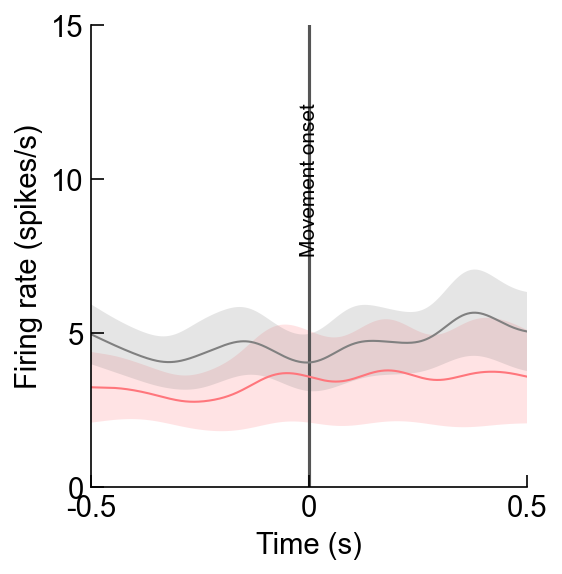

In [102]:
fig, ax = plt.subplots(figsize=(3.75,4))
    
#PSTH
starttime = -30000 #samples
endtime = starttime+60000 #samples
xrange = np.linspace(starttime,endtime,num=1000)

NCR_avg_FR_Nose = CalculateforRasterPSTHAcrossCells(movementsToPlots[2])[0]
NCR_sem_FR_Nose = CalculateforRasterPSTHAcrossCells(movementsToPlots[2])[1]
ax.plot(xrange,NCR_avg_FR_Nose, lw=1,color=NCR_COLOR,label = 'NCR')
ax.fill_between(xrange,NCR_avg_FR_Nose-NCR_sem_FR_Nose,NCR_avg_FR_Nose+NCR_sem_FR_Nose,color=NCR_COLOR,alpha=0.2,zorder=-10,lw=0)
CR_avg_FR_Nose = CalculateforRasterPSTHAcrossCells(movementsToPlots[2])[3]
CR_sem_FR_Nose = CalculateforRasterPSTHAcrossCells(movementsToPlots[2])[4]
ax.plot(xrange,CR_avg_FR_Nose, lw=1,color=CR_COLOR,label = 'CR')
ax.fill_between(xrange,CR_avg_FR_Nose-CR_sem_FR_Nose,CR_avg_FR_Nose+CR_sem_FR_Nose,color=CR_COLOR,alpha=0.2,zorder=-10,lw=0)
ax.set_xlabel('Time (s)')

highest_limit = 15
ax.set_ylim([0,highest_limit])
ax.set_yticks([0,5,10,15])

ax.set_yticklabels(['0','5','10','15']) #real

ax.set_ylabel('Firing rate (spikes/s)')
ax.set_xlim([-15000,15000])
ax.set_xticks([-15000,0,15000])


ax.set_xticklabels(['-0.5','0','0.5'])#real


for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
    ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(stdfont)
    
ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)
ax.tick_params(length=6)
ax.set_axisbelow(False)

ax.text(-0.2,10,'Movement onset',color='black',horizontalalignment='center',verticalalignment='center',rotation=90,fontsize=10)
ax.axvline(0,0,highest_limit,color='#555555',zorder=-1)

fig.savefig(os.path.join('C:\\Users\insan\\Desktop\\Motion new\\non-normalized fr nose2.pdf'),transparent=False,facecolor="white",bbox_inches = 'tight')

meta NOT subset; don't know how to subset; dropped


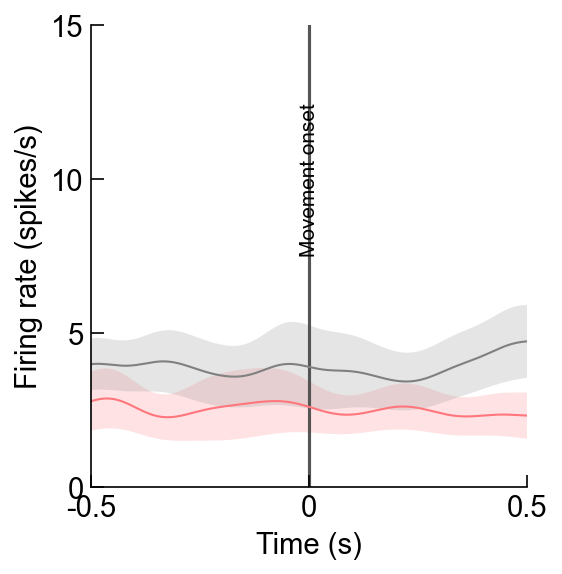

In [103]:
fig, ax = plt.subplots(figsize=(3.75,4))
    
#PSTH
starttime = -30000 #samples
endtime = starttime+60000 #samples
xrange = np.linspace(starttime,endtime,num=1000)

NCR_avg_FR_Whisker = CalculateforRasterPSTHAcrossCells(movementsToPlots[3])[0]
NCR_sem_FR_Whisker = CalculateforRasterPSTHAcrossCells(movementsToPlots[3])[1]
ax.plot(xrange,NCR_avg_FR_Whisker, lw=1,color=NCR_COLOR)
ax.fill_between(xrange,NCR_avg_FR_Whisker-NCR_sem_FR_Whisker,NCR_avg_FR_Whisker+NCR_sem_FR_Whisker,color=NCR_COLOR,alpha=0.2,zorder=-10,lw=0)
CR_avg_FR_Whisker = CalculateforRasterPSTHAcrossCells(movementsToPlots[3])[3]
CR_sem_FR_Whisker = CalculateforRasterPSTHAcrossCells(movementsToPlots[3])[4]
ax.plot(xrange,CR_avg_FR_Whisker, lw=1,color=CR_COLOR)
ax.fill_between(xrange,CR_avg_FR_Whisker-CR_sem_FR_Whisker,CR_avg_FR_Whisker+CR_sem_FR_Whisker,color=CR_COLOR,alpha=0.2,zorder=-10,lw=0)
ax.set_xlabel('Time (s)')

highest_limit = 15
ax.set_ylim([0,highest_limit])
ax.set_yticks([0,5,10,15])

ax.set_yticklabels(['0','5','10','15']) #real

ax.set_ylabel('Firing rate (spikes/s)')
ax.set_xlim([-15000,15000])
ax.set_xticks([-15000,0,15000])

ax.set_xticklabels(['-0.5','0','0.5'])#real


for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
    ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(stdfont)
    
ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)
ax.tick_params(length=6)
ax.set_axisbelow(False)

ax.text(-0.2,10,'Movement onset',color='black',horizontalalignment='center',verticalalignment='center',rotation=90,fontsize=10)
ax.axvline(0,0,highest_limit,color='#555555',zorder=-1)

fig.savefig(os.path.join('C:\\Users\insan\\Desktop\\Motion new\\non-normalized fr whisker2.pdf'),transparent=False,facecolor="white",bbox_inches = 'tight')

### Norm

In [177]:
def CalculateforRasterPSTHAcrossCellsNormalize(movementsToPlots):

    def CalculateClustFR(clust):
        moveSpikes = []
        for movement in movementsToPlots:
            this_move_spike = ilep.getSpikeTimes(sessionfile_D9,clust=clust,starttime=movement-33000, endtime=movement+33000)
            moveSpikes.append(this_move_spike-movement)
        moveSpikes = np.array(moveSpikes,dtype='object') 

        bw_scott_factor = 3
        starttime = -30000 #samples
        endtime = starttime+60000 #samples
        xrange = np.linspace(starttime,endtime,num=1000)
        FR = np.full((10,len(xrange)),np.nan) 
        kf = KFold(n_splits=10)

        for idx,(move_index,_) in enumerate(kf.split(moveSpikes)):
            PSTHspikes = np.concatenate(moveSpikes[move_index])
            bw = len(PSTHspikes)**(-1./5) / bw_scott_factor
            KDE = gaussian_kde(PSTHspikes,bw_method=bw)
            FR[idx,:] = KDE.evaluate(xrange)
            FR[idx,:] = FR[idx,:] * len(PSTHspikes) / len(move_index) *30000 #convert unit to seconds from samples

        avg_FR = np.mean(FR,axis=0) 
        base_FR = np.mean(avg_FR[:250]) 
        norm_FR = avg_FR/base_FR - 1
        #print(len(avg_FR))
        #print(len(norm_FR))

        return avg_FR, norm_FR 
    ###############  
    CR_norm_FR = []
    for clust in CR_D9:
        norm_FR = CalculateClustFR(clust)[1]
        CR_norm_FR.append(norm_FR)
    CR_norm_FR = np.array(CR_norm_FR)

    NCR_norm_FR = []
    for clust in NCR_D9:
        norm_FR = CalculateClustFR(clust)[1]
        NCR_norm_FR.append(norm_FR)
    NCR_norm_FR = np.array(NCR_norm_FR)

    CR_norm = np.mean(CR_norm_FR,axis=0)
    CR_sem = sem(CR_norm_FR,axis=0)
    NCR_norm = np.mean(NCR_norm_FR,axis=0)
    NCR_sem = sem(NCR_norm_FR,axis=0)
    
    print(CR_D9)
    return CR_norm, NCR_norm, CR_sem, NCR_sem

[3, 15, 19, 31, 50, 77, 87, 88, 90, 91]
[3, 15, 19, 31, 50, 77, 87, 88, 90, 91]
[3, 15, 19, 31, 50, 77, 87, 88, 90, 91]


meta NOT subset; don't know how to subset; dropped


[3, 15, 19, 31, 50, 77, 87, 88, 90, 91]


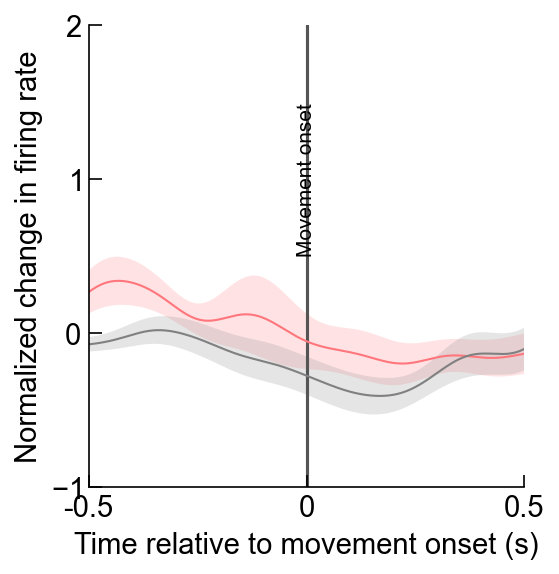

In [178]:
movementsToPlots = [integrate_3003_movement_onset_samples_arr,mouth_3003_movement_onset_samples_arr,
                   nose_3003_movement_onset_samples_arr,whisker_3003_movement_onset_samples_arr]

fig, ax = plt.subplots(figsize=(3.75,4))

FRmod = sessionfile.responsiveness[clust]['all_trials'].FRmodulation
FRmod_color = NCR_CR_cmap( (FRmod-1)/5)
region = sessionfile.meta.region
    
#PSTH
starttime = -30000 #samples
endtime = starttime+60000 #samples
xrange = np.linspace(starttime,endtime,num=1000)
    
NCR_noravg_FR_Mouth = CalculateforRasterPSTHAcrossCellsNormalize(movementsToPlots[1])[1]
NCR_norsem_FR_Mouth = CalculateforRasterPSTHAcrossCellsNormalize(movementsToPlots[1])[3]
CR_noravg_FR_Mouth = CalculateforRasterPSTHAcrossCellsNormalize(movementsToPlots[1])[0]
CR_norsem_FR_Mouth =  CalculateforRasterPSTHAcrossCellsNormalize(movementsToPlots[1])[2]
ax.plot(xrange,NCR_noravg_FR_Mouth, lw=1,color=NCR_COLOR,label = 'NCR (n=7)')
ax.plot(xrange,CR_noravg_FR_Mouth,lw=1,color=CR_COLOR,label = 'CR (n=11)')
ax.fill_between(xrange,NCR_noravg_FR_Mouth-NCR_norsem_FR_Mouth,NCR_noravg_FR_Mouth+NCR_norsem_FR_Mouth,color=NCR_COLOR,alpha=0.2,zorder=-10,lw=0)
ax.fill_between(xrange,CR_noravg_FR_Mouth-CR_norsem_FR_Mouth,CR_noravg_FR_Mouth+CR_norsem_FR_Mouth,color=CR_COLOR,alpha=0.2,zorder=-10,lw=0)
ax.set_xlabel('Time relative to movement onset (s)')

ax.set_ylim([-1,2])
ax.set_yticks([-1,0,1,2]) 

ax.set_ylabel('Normalized change in firing rate')
ax.set_xlim([-15000,15000])
ax.set_xticks([-15000,0,15000])
ax.set_xticklabels(['-0.5','0','0.5']) #real
#ax.legend()

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
    ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(stdfont)
    
ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)
ax.tick_params(length=6)
ax.set_axisbelow(False)
ax.text(-0.2,1,'Movement onset',color='black',horizontalalignment='center',verticalalignment='center',rotation=90,fontsize=10)
ax.axvline(0,0,2,color='#555555',zorder=-1)

fig.savefig(os.path.join('C:\\Users\insan\\Desktop\\Motion new\\normalized fr mouth2.pdf'),transparent=False,facecolor="white", bbox_inches = 'tight')

[3, 15, 19, 31, 50, 77, 87, 88, 90, 91]
[3, 15, 19, 31, 50, 77, 87, 88, 90, 91]
[3, 15, 19, 31, 50, 77, 87, 88, 90, 91]
[3, 15, 19, 31, 50, 77, 87, 88, 90, 91]


meta NOT subset; don't know how to subset; dropped


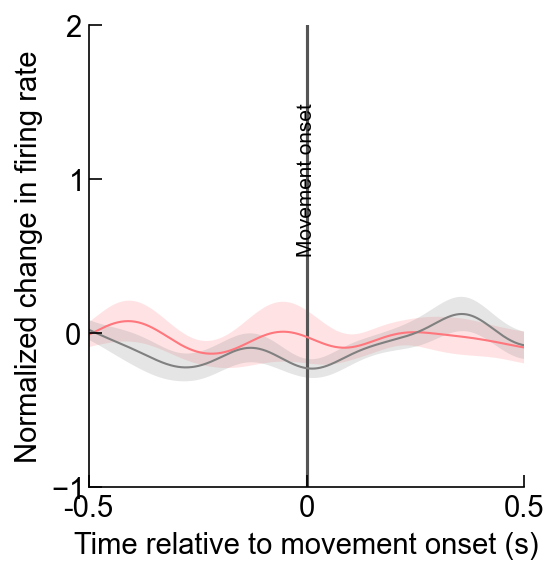

In [179]:
fig, ax = plt.subplots(figsize=(3.75,4))

FRmod = sessionfile.responsiveness[clust]['all_trials'].FRmodulation
FRmod_color = NCR_CR_cmap( (FRmod-1)/5)
region = sessionfile.meta.region
    
#PSTH
starttime = -30000 #samples
endtime = starttime+60000 #samples
xrange = np.linspace(starttime,endtime,num=1000)
    
NCR_noravg_FR_Nose = CalculateforRasterPSTHAcrossCellsNormalize(movementsToPlots[2])[1]
NCR_norsem_FR_Nose = CalculateforRasterPSTHAcrossCellsNormalize(movementsToPlots[2])[3]
CR_noravg_FR_Nose = CalculateforRasterPSTHAcrossCellsNormalize(movementsToPlots[2])[0]
CR_norsem_FR_Nose = CalculateforRasterPSTHAcrossCellsNormalize(movementsToPlots[2])[2]
ax.plot(xrange,NCR_noravg_FR_Nose, lw=1,color=NCR_COLOR,label = 'NCR')
ax.plot(xrange,CR_noravg_FR_Nose,lw=1,color=CR_COLOR,label = 'CR')
ax.fill_between(xrange,NCR_noravg_FR_Nose-NCR_norsem_FR_Nose,NCR_noravg_FR_Nose+NCR_norsem_FR_Nose,color=NCR_COLOR,alpha=0.2,zorder=-10,lw=0)
ax.fill_between(xrange,CR_noravg_FR_Nose-CR_norsem_FR_Nose,CR_noravg_FR_Nose+CR_norsem_FR_Nose,color=CR_COLOR,alpha=0.2,zorder=-10,lw=0)
ax.set_xlabel('Time relative to movement onset (s)')

ax.set_ylim([-1,2])
ax.set_yticks([-1,0,1,2]) 
#ax1.set_yticklabels(['0.2','0.6','1.0']) #plot purposes

ax.set_ylabel('Normalized change in firing rate')
ax.set_xlim([-15000,15000])
ax.set_xticks([-15000,0,15000])
#ax.set_xticklabels(['-100','-0.5','0','0.5','1']) #for plot purposes
ax.set_xticklabels(['-0.5','0','0.5']) #real
#ax.text(18000,1.5,'NCR n=7',color=NCR_COLOR)
#ax.text(18000,1.5+0.25,'CR n=11',color=CR_COLOR)

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
    ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(stdfont)
ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)
ax.tick_params(length=6)
ax.set_axisbelow(False)
ax.text(-0.2,1,'Movement onset',color='black',horizontalalignment='center',verticalalignment='center',rotation=90,fontsize=10)
ax.axvline(0,0,2,color='#555555',zorder=-1)

fig.savefig(os.path.join('C:\\Users\insan\\Desktop\\Motion new\\normalized fr nose2.pdf'),transparent=False,facecolor="white", bbox_inches = 'tight')

[3, 15, 19, 31, 50, 77, 87, 88, 90, 91]
[3, 15, 19, 31, 50, 77, 87, 88, 90, 91]
[3, 15, 19, 31, 50, 77, 87, 88, 90, 91]


meta NOT subset; don't know how to subset; dropped


[3, 15, 19, 31, 50, 77, 87, 88, 90, 91]


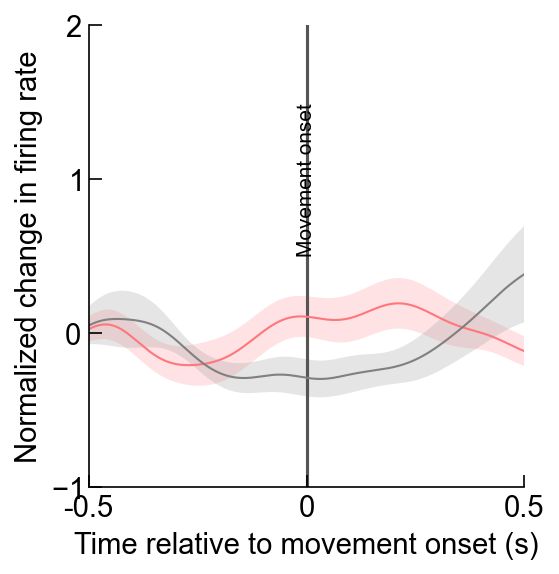

In [180]:
fig, ax = plt.subplots(figsize=(3.75,4))

FRmod = sessionfile.responsiveness[clust]['all_trials'].FRmodulation
FRmod_color = NCR_CR_cmap( (FRmod-1)/5)
region = sessionfile.meta.region
    
#PSTH
starttime = -30000 #samples
endtime = starttime+60000 #samples
xrange = np.linspace(starttime,endtime,num=1000)
    
NCR_noravg_FR_Whisker = CalculateforRasterPSTHAcrossCellsNormalize(movementsToPlots[3])[1]
NCR_norsem_FR_Whisker = CalculateforRasterPSTHAcrossCellsNormalize(movementsToPlots[3])[3]
CR_noravg_FR_Whisker = CalculateforRasterPSTHAcrossCellsNormalize(movementsToPlots[3])[0]
CR_norsem_FR_Whisker = CalculateforRasterPSTHAcrossCellsNormalize(movementsToPlots[3])[2]
ax.plot(xrange,NCR_noravg_FR_Whisker, lw=1,color=NCR_COLOR)
ax.plot(xrange,CR_noravg_FR_Whisker,lw=1,color=CR_COLOR)
ax.fill_between(xrange,NCR_noravg_FR_Whisker-NCR_norsem_FR_Whisker,NCR_noravg_FR_Whisker+NCR_norsem_FR_Whisker,color=NCR_COLOR,alpha=0.2,zorder=-10,lw=0)
ax.fill_between(xrange,CR_noravg_FR_Whisker-CR_norsem_FR_Whisker,CR_noravg_FR_Whisker+CR_norsem_FR_Whisker,color=CR_COLOR,alpha=0.2,zorder=-10,lw=0)
ax.set_xlabel('Time relative to movement onset (s)')

ax.set_ylim([-1,2])
ax.set_yticks([-1,0,1,2]) 
#ax1.set_yticklabels(['0.2','0.6','1.0']) #plot purposes

ax.set_ylabel('Normalized change in firing rate')
ax.set_xlim([-15000,15000])
ax.set_xticks([-15000,0,15000])
#ax.set_xticklabels(['-100','-0.5','0','0.5','1']) #for plot purposes
ax.set_xticklabels(['-0.5','0','0.5']) #real
#ax.text(18000,1.5,'NCR n=7',color=NCR_COLOR)
#ax.text(18000,1.5+0.25,'CR n=11',color=CR_COLOR)

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
    ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(stdfont)

ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)
ax.tick_params(length=6)
ax.set_axisbelow(False)
ax.text(-0.2,1,'Movement onset',color='black',horizontalalignment='center',verticalalignment='center',rotation=90,fontsize=10)
ax.axvline(0,0,2,color='#555555',zorder=-1)

fig.savefig(os.path.join('C:\\Users\insan\\Desktop\\Motion new\\normalized fr whisker2.pdf'),transparent=False,facecolor="white", bbox_inches = 'tight')

# New figs with final style (Sep 2023)

### Speed

In [70]:
print(len(sem_mouth_3003_speed))
print(len(avg_mouth_3003_speed))

400
400


In [71]:
range(100,300)

range(100, 300)

meta NOT subset; don't know how to subset; dropped


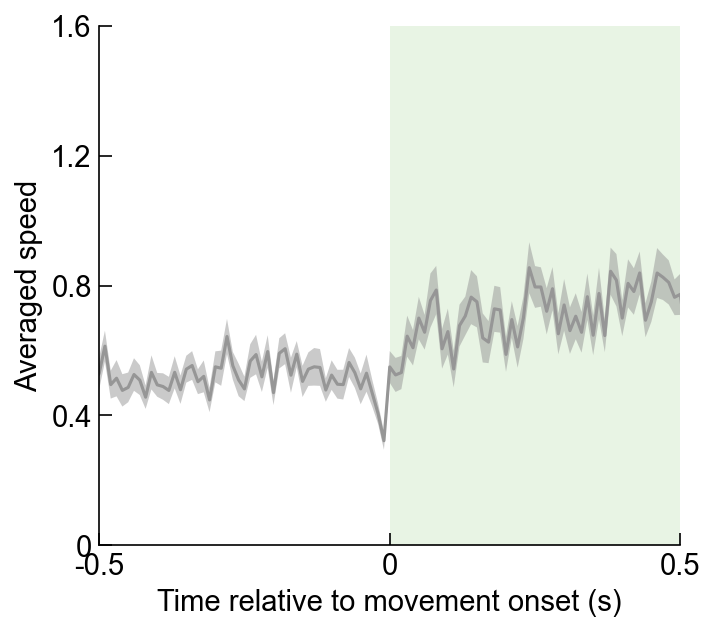

In [72]:
stdfont = 14
stdyfrac = 0.06

fig, ax = plt.subplots(figsize=(5,4.5))
#Mouth speed plot
ax.axvspan(200, 250, ymin=0,color='#e8f4e4', lw=0,zorder=-11)
ax.axvspan(150, 200, ymin=0,color='white', alpha=0.3, lw=0,label='slow',zorder=-11)
ax.plot(avg_mouth_3003_speed,color='#969696')
ax.fill_between(np.arange(0,400),avg_mouth_3003_speed-sem_mouth_3003_speed,avg_mouth_3003_speed+sem_mouth_3003_speed,color='#969696',alpha=0.5,zorder=-10,lw=0)

ax.set_xlim([150,250])
ax.set_xticks([150,200,250])
ax.set_xticklabels(['-0.5','0','0.5'])
ax.set_ylabel('Averaged speed')
ax.set_xlabel('Time relative to movement onset (s)')

ax.set_ylim([0,1.6])
ax.set_yticks([0,0.4,0.8,1.2,1.6])
ax.set_yticklabels(['0','0.4','0.8','1.2','1.6'])


ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)
ax.tick_params(length=6)
ax.set_axisbelow(False)

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
    ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(stdfont)


fig.savefig(os.path.join('C:\\Users\insan\\Desktop\\Motion new\\mouth speed.pdf'),transparent=False,facecolor="white")

meta NOT subset; don't know how to subset; dropped


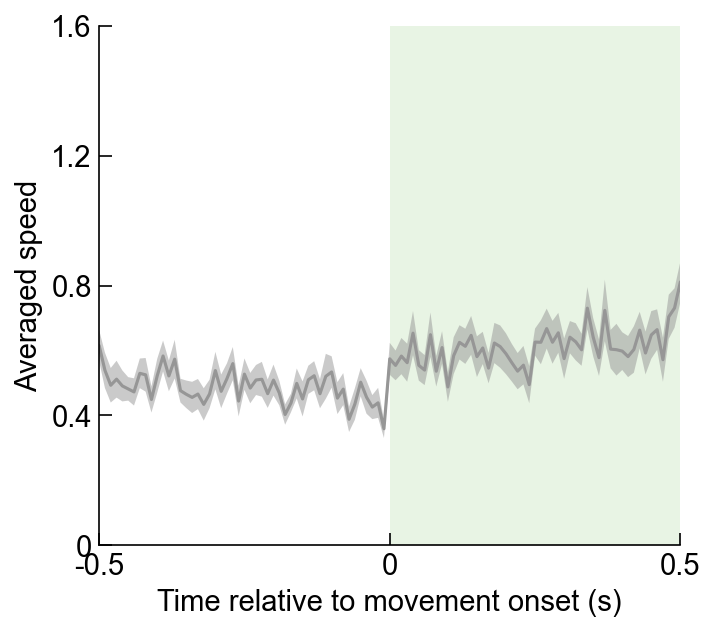

In [73]:
fig, ax = plt.subplots(figsize=(5,4.5))
#Nose speed plot
ax.axvspan(200, 250, ymin=0,color='#e8f4e4', lw=0,zorder=-11)
ax.axvspan(150, 200, ymin=0,color='white', alpha=0.3, lw=0,label='slow',zorder=-11)
ax.plot(avg_nose_3003_speed,color='#969696')
ax.fill_between(np.arange(0,400),avg_nose_3003_speed-sem_nose_3003_speed,avg_nose_3003_speed+sem_nose_3003_speed,color='#969696',alpha=0.5,zorder=-10,lw=0)

ax.set_xlim([150,250])
ax.set_xticks([150,200,250])
ax.set_xticklabels(['-0.5','0','0.5'])
ax.set_ylabel('Averaged speed')
ax.set_xlabel('Time relative to movement onset (s)')

ax.set_ylim([0,1.6])
ax.set_yticks([0,0.4,0.8,1.2,1.6])
ax.set_yticklabels(['0','0.4','0.8','1.2','1.6'])
ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)
ax.tick_params(length=6)
ax.set_axisbelow(False)

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
    ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(stdfont)


fig.savefig(os.path.join('C:\\Users\insan\\Desktop\\Motion new\\nose speed.pdf'),transparent=False,facecolor="white")

meta NOT subset; don't know how to subset; dropped


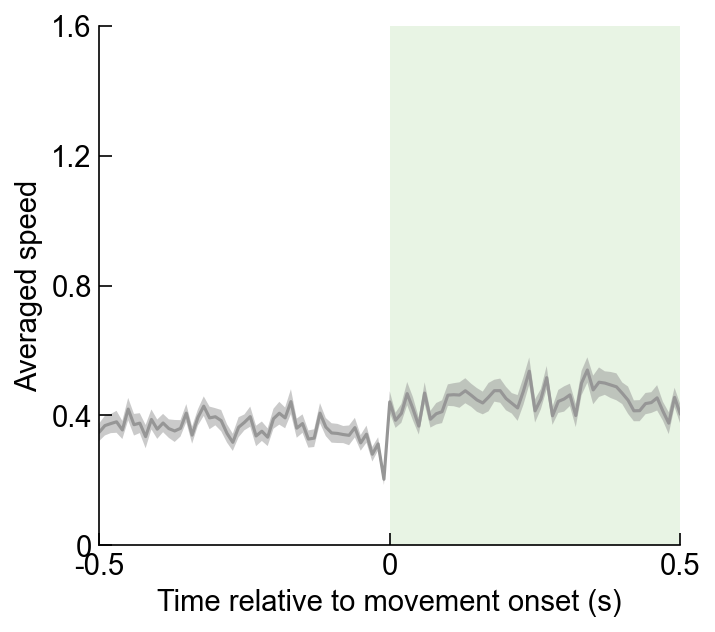

In [74]:
fig, ax = plt.subplots(figsize=(5,4.5))
#Whisker speed plot
ax.axvspan(200, 250, ymin=0,color='#e8f4e4', lw=0,zorder=-11)
ax.axvspan(150, 200, ymin=0,color='white', alpha=0.3, lw=0,label='slow',zorder=-11)

ax.plot(avg_whisker_3003_speed,color='#969696')
ax.fill_between(np.arange(0,400),avg_whisker_3003_speed-sem_whisker_3003_speed,avg_whisker_3003_speed+sem_whisker_3003_speed,color='#969696',alpha=0.5,zorder=-10,lw=0)

ax.set_xlim([150,250])
ax.set_xticks([150,200,250])
ax.set_xticklabels(['-0.5','0','0.5'])
ax.set_ylabel('Averaged speed')
ax.set_xlabel('Time relative to movement onset (s)')

ax.set_ylim([0,1.6])
ax.set_yticks([0,0.4,0.8,1.2,1.6])
ax.set_yticklabels(['0','0.4','0.8','1.2','1.6'])

ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)
ax.tick_params(length=6)
ax.set_axisbelow(False)

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
    ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(stdfont)

#ax.legend()

fig.savefig(os.path.join('C:\\Users\insan\\Desktop\\Motion new\\whisker speed.pdf'),transparent=False,facecolor="white")

meta NOT subset; don't know how to subset; dropped


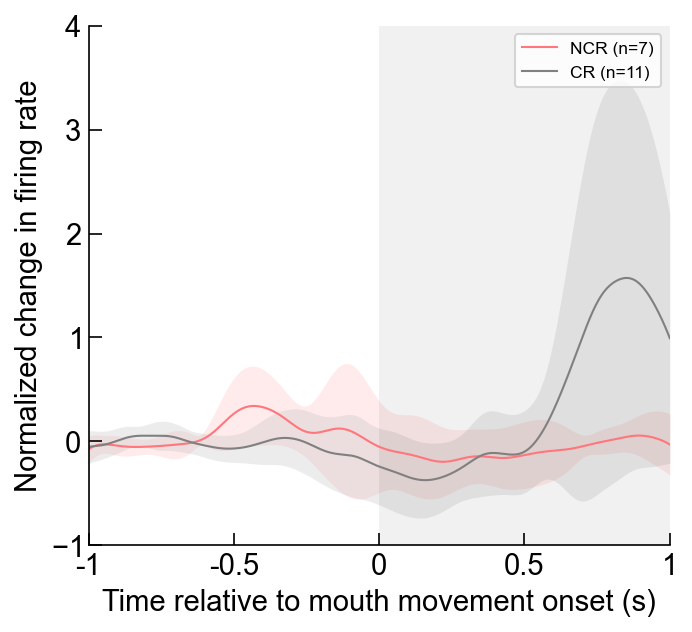

In [230]:
movementsToPlots = [integrate_3003_movement_onset_samples_arr,mouth_3003_movement_onset_samples_arr,
                   nose_3003_movement_onset_samples_arr,whisker_3003_movement_onset_samples_arr]

fig, ax = plt.subplots(figsize=(5,4.5))

FRmod = sessionfile.responsiveness[clust]['all_trials'].FRmodulation
FRmod_color = NCR_CR_cmap( (FRmod-1)/5)
region = sessionfile.meta.region
    
#PSTH
starttime = -30000 #samples
endtime = starttime+60000 #samples
xrange = np.linspace(starttime,endtime,num=1000)
    
NCR_noravg_FR_Mouth = CalculateforRasterPSTHAcrossCellsNormalize(movementsToPlots[1])[1]
NCR_norsem_FR_Mouth = CalculateforRasterPSTHAcrossCellsNormalize(movementsToPlots[1])[3]
CR_noravg_FR_Mouth = CalculateforRasterPSTHAcrossCellsNormalize(movementsToPlots[1])[0]
CR_norsem_FR_Mouth =  CalculateforRasterPSTHAcrossCellsNormalize(movementsToPlots[1])[2]
ax.plot(xrange,NCR_noravg_FR_Mouth, lw=1,color=NCR_COLOR,label = 'NCR (n=7)')
ax.plot(xrange,CR_noravg_FR_Mouth,lw=1,color=CR_COLOR,label = 'CR (n=11)')
ax.fill_between(xrange,NCR_noravg_FR_Mouth-NCR_norsem_FR_Mouth,NCR_noravg_FR_Mouth+NCR_norsem_FR_Mouth,color=NCR_COLOR,alpha=0.2,zorder=-10,lw=0)
ax.fill_between(xrange,CR_noravg_FR_Mouth-CR_norsem_FR_Mouth,CR_noravg_FR_Mouth+CR_norsem_FR_Mouth,color=CR_COLOR,alpha=0.2,zorder=-10,lw=0)
ax.set_xlabel('Time relative to mouth movement onset (s)')

ax.set_ylim([-1,4])
ax.set_yticks([-1,0,1,2,3,4]) 
#ax1.set_yticklabels(['0.2','0.6','1.0']) #plot purposes
ax.axvspan(-30000,0, ymin=0,color='white', alpha=0.3, lw=0) 
ax.axvspan(0, 30000, ymin=0,color='lightgray', alpha=0.3, lw=0)
ax.set_ylabel('Normalized change in firing rate')
ax.set_xlim([-30000,30000])
ax.set_xticks([-30000,-15000,0,15000, 30000])
#ax.set_xticklabels(['-100','-0.5','0','0.5','1']) #for plot purposes
ax.set_xticklabels(['-1','-0.5','0','0.5','1']) #real
ax.legend()

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
    ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(stdfont)
    
ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)
ax.tick_params(length=6)
ax.set_axisbelow(False)

fig.savefig(os.path.join('C:\\Users\insan\\Desktop\\Motion new\\normalized fr mouth.pdf'),transparent=False,facecolor="white")

meta NOT subset; don't know how to subset; dropped


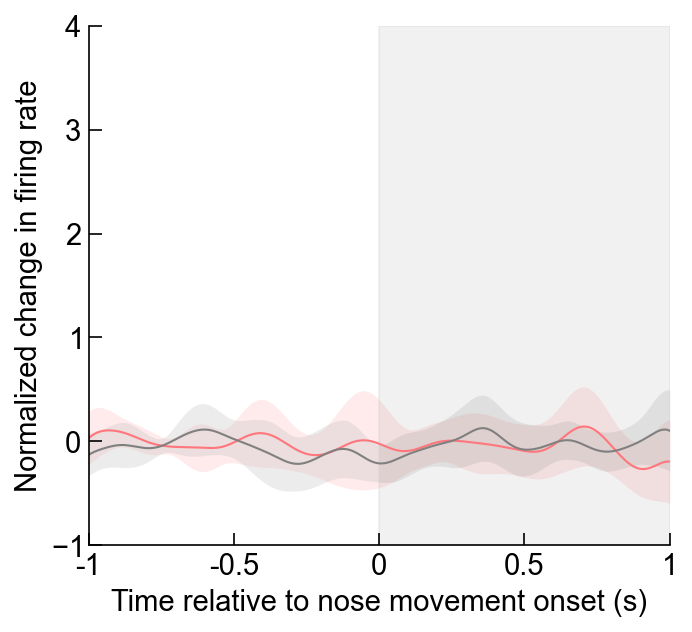

In [231]:
fig, ax = plt.subplots(figsize=(5,4.5))

FRmod = sessionfile.responsiveness[clust]['all_trials'].FRmodulation
FRmod_color = NCR_CR_cmap( (FRmod-1)/5)
region = sessionfile.meta.region
    
#PSTH
starttime = -30000 #samples
endtime = starttime+60000 #samples
xrange = np.linspace(starttime,endtime,num=1000)
    
NCR_noravg_FR_Nose = CalculateforRasterPSTHAcrossCellsNormalize(movementsToPlots[2])[1]
NCR_norsem_FR_Nose = CalculateforRasterPSTHAcrossCellsNormalize(movementsToPlots[2])[3]
CR_noravg_FR_Nose = CalculateforRasterPSTHAcrossCellsNormalize(movementsToPlots[2])[0]
CR_norsem_FR_Nose = CalculateforRasterPSTHAcrossCellsNormalize(movementsToPlots[2])[2]
ax.plot(xrange,NCR_noravg_FR_Nose, lw=1,color=NCR_COLOR,label = 'NCR')
ax.plot(xrange,CR_noravg_FR_Nose,lw=1,color=CR_COLOR,label = 'CR')
ax.fill_between(xrange,NCR_noravg_FR_Nose-NCR_norsem_FR_Nose,NCR_noravg_FR_Nose+NCR_norsem_FR_Nose,color=NCR_COLOR,alpha=0.2,zorder=-10,lw=0)
ax.fill_between(xrange,CR_noravg_FR_Nose-CR_norsem_FR_Nose,CR_noravg_FR_Nose+CR_norsem_FR_Nose,color=CR_COLOR,alpha=0.2,zorder=-10,lw=0)
ax.set_xlabel('Time relative to nose movement onset (s)')

ax.set_ylim([-1,4])
ax.set_yticks([-1,0,1,2,3,4]) 
#ax1.set_yticklabels(['0.2','0.6','1.0']) #plot purposes
ax.axvspan(-30000,0, ymin=0,color='white', alpha=0.3, lw=0) 
ax.axvspan(0, 30000, ymin=0,color='lightgray', alpha=0.3)
ax.set_ylabel('Normalized change in firing rate')
ax.set_xlim([-30000,30000])
ax.set_xticks([-30000,-15000,0,15000, 30000])
#ax.set_xticklabels(['-100','-0.5','0','0.5','1']) #for plot purposes
ax.set_xticklabels(['-1','-0.5','0','0.5','1']) #real
#ax.text(18000,1.5,'NCR n=7',color=NCR_COLOR)
#ax.text(18000,1.5+0.25,'CR n=11',color=CR_COLOR)

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
    ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(stdfont)
ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)
ax.tick_params(length=6)
ax.set_axisbelow(False)


fig.savefig(os.path.join('C:\\Users\insan\\Desktop\\Motion new\\normalized fr nose.pdf'),transparent=False,facecolor="white")

meta NOT subset; don't know how to subset; dropped


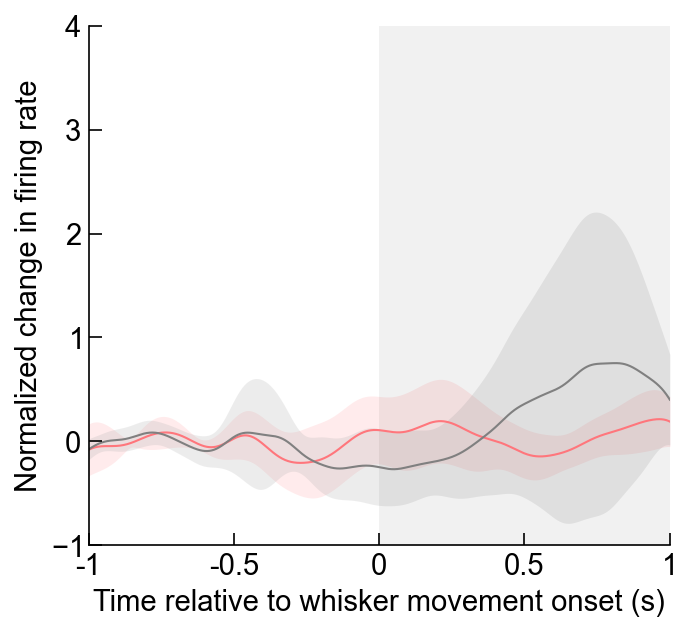

In [233]:
fig, ax = plt.subplots(figsize=(5,4.5))

FRmod = sessionfile.responsiveness[clust]['all_trials'].FRmodulation
FRmod_color = NCR_CR_cmap( (FRmod-1)/5)
region = sessionfile.meta.region
    
#PSTH
starttime = -30000 #samples
endtime = starttime+60000 #samples
xrange = np.linspace(starttime,endtime,num=1000)
    
NCR_noravg_FR_Whisker = CalculateforRasterPSTHAcrossCellsNormalize(movementsToPlots[3])[1]
NCR_norsem_FR_Whisker = CalculateforRasterPSTHAcrossCellsNormalize(movementsToPlots[3])[3]
CR_noravg_FR_Whisker = CalculateforRasterPSTHAcrossCellsNormalize(movementsToPlots[3])[0]
CR_norsem_FR_Whisker = CalculateforRasterPSTHAcrossCellsNormalize(movementsToPlots[3])[2]
ax.plot(xrange,NCR_noravg_FR_Whisker, lw=1,color=NCR_COLOR)
ax.plot(xrange,CR_noravg_FR_Whisker,lw=1,color=CR_COLOR)
ax.fill_between(xrange,NCR_noravg_FR_Whisker-NCR_norsem_FR_Whisker,NCR_noravg_FR_Whisker+NCR_norsem_FR_Whisker,color=NCR_COLOR,alpha=0.2,zorder=-10,lw=0)
ax.fill_between(xrange,CR_noravg_FR_Whisker-CR_norsem_FR_Whisker,CR_noravg_FR_Whisker+CR_norsem_FR_Whisker,color=CR_COLOR,alpha=0.2,zorder=-10,lw=0)
ax.set_xlabel('Time relative to whisker movement onset (s)')

ax.set_ylim([-1,4])
ax.set_yticks([-1,0,1,2,3,4]) 
#ax1.set_yticklabels(['0.2','0.6','1.0']) #plot purposes
ax.axvspan(-30000,0, ymin=0,color='white', alpha=0.3, lw=0) 
ax.axvspan(0, 30000, ymin=0,color='lightgray', alpha=0.3, lw=0)
ax.set_ylabel('Normalized change in firing rate')
ax.set_xlim([-30000,30000])
ax.set_xticks([-30000,-15000,0,15000, 30000])
#ax.set_xticklabels(['-100','-0.5','0','0.5','1']) #for plot purposes
ax.set_xticklabels(['-1','-0.5','0','0.5','1']) #real
#ax.text(18000,1.5,'NCR n=7',color=NCR_COLOR)
#ax.text(18000,1.5+0.25,'CR n=11',color=CR_COLOR)

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
    ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(stdfont)

ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)
ax.tick_params(length=6)
ax.set_axisbelow(False)

fig.savefig(os.path.join('C:\\Users\insan\\Desktop\\Motion new\\normalized fr whisker.pdf'),transparent=False,facecolor="white")

In [234]:
#Non-normal
movementsToPlots = [integrate_3003_movement_onset_samples_arr,mouth_3003_movement_onset_samples_arr,
                    nose_3003_movement_onset_samples_arr,whisker_3003_movement_onset_samples_arr]

meta NOT subset; don't know how to subset; dropped


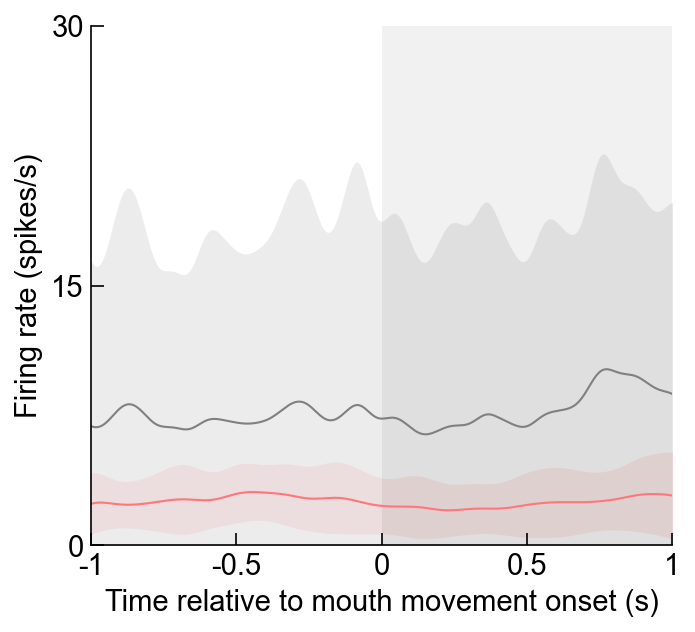

In [235]:
fig, ax = plt.subplots(figsize=(5,4.5))
    
#PSTH
starttime = -30000 #samples
endtime = starttime+60000 #samples
xrange = np.linspace(starttime,endtime,num=1000)

NCR_avg_FR_Mouth = CalculateforRasterPSTHAcrossCells(movementsToPlots[1])[0]
NCR_sem_FR_Mouth = CalculateforRasterPSTHAcrossCells(movementsToPlots[1])[1]
ax.plot(xrange,NCR_avg_FR_Mouth, lw=1,color=NCR_COLOR)
ax.fill_between(xrange,NCR_avg_FR_Mouth-NCR_sem_FR_Mouth,NCR_avg_FR_Mouth+NCR_sem_FR_Mouth,color=NCR_COLOR,alpha=0.2,zorder=-10,lw=0)
CR_avg_FR_Mouth = CalculateforRasterPSTHAcrossCells(movementsToPlots[1])[3]
CR_sem_FR_Mouth = CalculateforRasterPSTHAcrossCells(movementsToPlots[1])[4]
ax.plot(xrange,CR_avg_FR_Mouth, lw=1,color=CR_COLOR)
ax.fill_between(xrange,CR_avg_FR_Mouth-CR_sem_FR_Mouth,CR_avg_FR_Mouth+CR_sem_FR_Mouth,color=CR_COLOR,alpha=0.2,zorder=-10,lw=0)
ax.set_xlabel('Time relative to mouth movement onset (s)')

highest_limit = 30
ax.set_ylim([0,highest_limit])
ax.set_yticks([0,highest_limit/2,highest_limit])
#ax1.set_yticklabels(['0.2','0.6','1.0']) #plot purpose
ax.set_yticklabels(['0',str(int(highest_limit/2)),str(highest_limit)]) #real

ax.axvspan(-30000,0, ymin=0,color='white', alpha=0.3, lw=0,label='slow movement') 
ax.axvspan(0, 30000, ymin=0,color='lightgray', alpha=0.3, lw=0, label = 'fast movement')
ax.set_ylabel('Firing rate (spikes/s)')
ax.set_xlim([-30000,30000])
ax.set_xticks([-30000,-15000,0,15000, 30000])
#ax.set_xticklabels(['-100','-0.5','0','0.5','1'])#plot purpose
ax.set_xticklabels(['-1','-0.5','0','0.5','1'])#real
#ax.text(18000,highest_limit,'NCR n=7',color=NCR_COLOR)
#ax.text(18000,highest_limit+3,'CR n=11',color=CR_COLOR)

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
    ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(stdfont)
ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)
ax.tick_params(length=6)
ax.set_axisbelow(False)

fig.savefig(os.path.join('C:\\Users\insan\\Desktop\\Motion new\\non-normalized fr mouth.pdf'),transparent=False,facecolor="white")

meta NOT subset; don't know how to subset; dropped


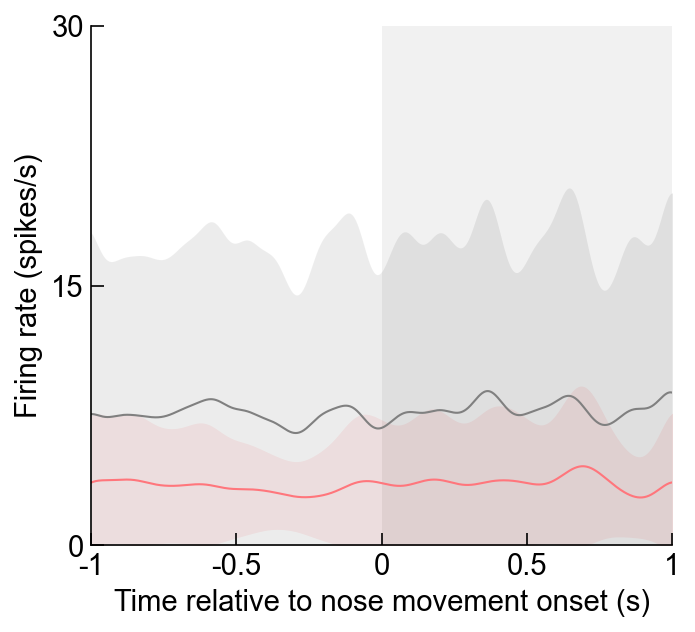

In [236]:
fig, ax = plt.subplots(figsize=(5,4.5))
    
#PSTH
starttime = -30000 #samples
endtime = starttime+60000 #samples
xrange = np.linspace(starttime,endtime,num=1000)

NCR_avg_FR_Nose = CalculateforRasterPSTHAcrossCells(movementsToPlots[2])[0]
NCR_sem_FR_Nose = CalculateforRasterPSTHAcrossCells(movementsToPlots[2])[1]
ax.plot(xrange,NCR_avg_FR_Nose, lw=1,color=NCR_COLOR,label = 'NCR')
ax.fill_between(xrange,NCR_avg_FR_Nose-NCR_sem_FR_Nose,NCR_avg_FR_Nose+NCR_sem_FR_Nose,color=NCR_COLOR,alpha=0.2,zorder=-10,lw=0)
CR_avg_FR_Nose = CalculateforRasterPSTHAcrossCells(movementsToPlots[2])[3]
CR_sem_FR_Nose = CalculateforRasterPSTHAcrossCells(movementsToPlots[2])[4]
ax.plot(xrange,CR_avg_FR_Nose, lw=1,color=CR_COLOR,label = 'CR')
ax.fill_between(xrange,CR_avg_FR_Nose-CR_sem_FR_Nose,CR_avg_FR_Nose+CR_sem_FR_Nose,color=CR_COLOR,alpha=0.2,zorder=-10,lw=0)
ax.set_xlabel('Time relative to nose movement onset (s)')

highest_limit = 30
ax.set_ylim([0,highest_limit])
ax.set_yticks([0,highest_limit/2,highest_limit])
#ax1.set_yticklabels(['0.2','0.6','1.0']) #plot purpose
ax.set_yticklabels(['0',str(int(highest_limit/2)),str(highest_limit)]) #real

ax.axvspan(-30000,0, ymin=0,color='white', alpha=0.3, lw=0,label='slow movement') 
ax.axvspan(0, 30000, ymin=0,color='lightgray', alpha=0.3, lw=0, label = 'fast movement')
ax.set_ylabel('Firing rate (spikes/s)')
ax.set_xlim([-30000,30000])
ax.set_xticks([-30000,-15000,0,15000, 30000])
#ax.set_xticklabels(['-100','-0.5','0','0.5','1'])#plot purpose
ax.set_xticklabels(['-1','-0.5','0','0.5','1'])#real
#ax.text(18000,highest_limit,'NCR n=7',color=NCR_COLOR)
#ax.text(18000,highest_limit+3,'CR n=11',color=CR_COLOR)

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
    ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(stdfont)

ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)
ax.tick_params(length=6)
ax.set_axisbelow(False)

fig.savefig(os.path.join('C:\\Users\insan\\Desktop\\Motion new\\non-normalized fr nose.pdf'),transparent=False,facecolor="white")

meta NOT subset; don't know how to subset; dropped


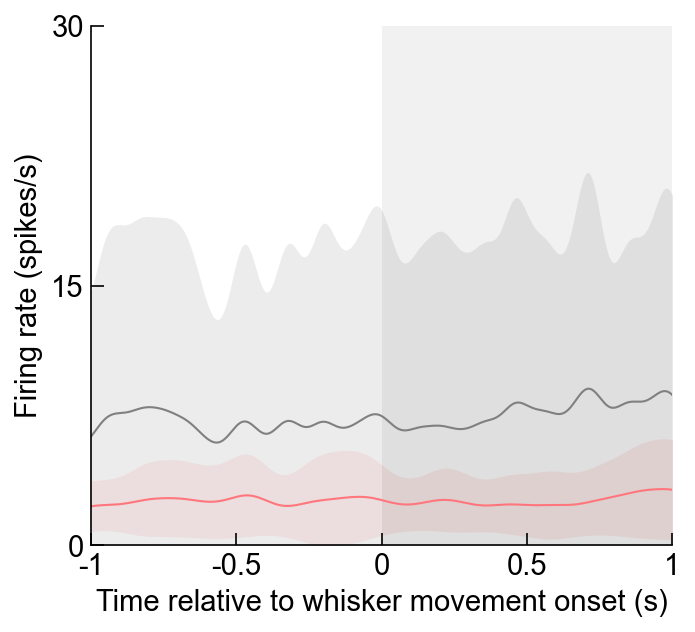

In [ ]:
fig, ax = plt.subplots(figsize=(5,4.5))
    
#PSTH
starttime = -30000 #samples
endtime = starttime+60000 #samples
xrange = np.linspace(starttime,endtime,num=1000)

NCR_avg_FR_Whisker = CalculateforRasterPSTHAcrossCells(movementsToPlots[3])[0]
NCR_sem_FR_Whisker = CalculateforRasterPSTHAcrossCells(movementsToPlots[3])[1]
ax.plot(xrange,NCR_avg_FR_Whisker, lw=1,color=NCR_COLOR)
ax.fill_between(xrange,NCR_avg_FR_Whisker-NCR_sem_FR_Whisker,NCR_avg_FR_Whisker+NCR_sem_FR_Whisker,color=NCR_COLOR,alpha=0.2,zorder=-10,lw=0)
CR_avg_FR_Whisker = CalculateforRasterPSTHAcrossCells(movementsToPlots[3])[3]
CR_sem_FR_Whisker = CalculateforRasterPSTHAcrossCells(movementsToPlots[3])[4]
ax.plot(xrange,CR_avg_FR_Whisker, lw=1,color=CR_COLOR)
ax.fill_between(xrange,CR_avg_FR_Whisker-CR_sem_FR_Whisker,CR_avg_FR_Whisker+CR_sem_FR_Whisker,color=CR_COLOR,alpha=0.2,zorder=-10,lw=0)
ax.set_xlabel('Time relative to whisker movement onset (s)')

highest_limit = 30
ax.set_ylim([0,highest_limit])
ax.set_yticks([0,highest_limit/2,highest_limit])
#ax1.set_yticklabels(['0.2','0.6','1.0']) #plot purpose
ax.set_yticklabels(['0',str(int(highest_limit/2)),str(highest_limit)]) #real

ax.axvspan(-30000,0, ymin=0,color='white', alpha=0.3, lw=0,label='slow movement') 
ax.axvspan(0, 30000, ymin=0,color='lightgray', alpha=0.3, lw=0, label = 'fast movement')
ax.set_ylabel('Firing rate (spikes/s)')
ax.set_xlim([-30000,30000])
ax.set_xticks([-30000,-15000,0,15000, 30000])
#ax.set_xticklabels(['-100','-0.5','0','0.5','1'])#plot purpose
ax.set_xticklabels(['-1','-0.5','0','0.5','1'])#real
#ax.text(18000,highest_limit,'NCR n=7',color=NCR_COLOR)
#ax.text(18000,highest_limit+3,'CR n=11',color=CR_COLOR)

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
    ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(stdfont)

ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)
ax.tick_params(length=6)
ax.set_axisbelow(False)

fig.savefig(os.path.join('C:\\Users\insan\\Desktop\\Motion new\\non-normalized fr whisker.pdf'),transparent=False,facecolor="white")

meta NOT subset; don't know how to subset; dropped


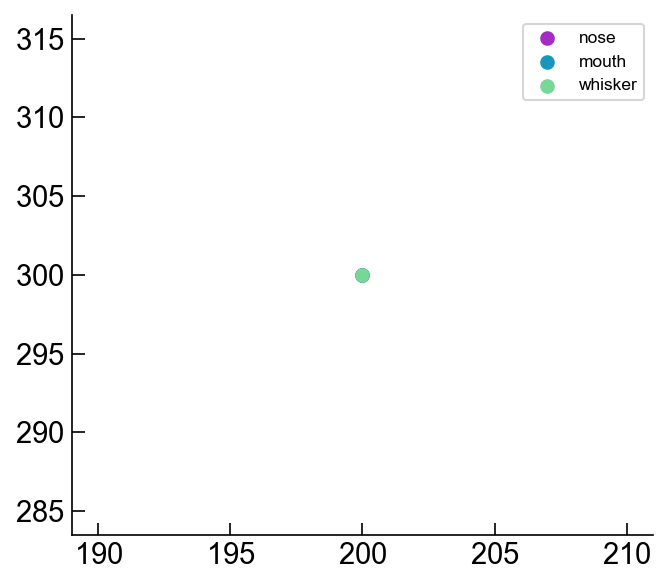

In [149]:
fig, ax = plt.subplots(figsize=(5,4.5))


ax.scatter(200, 300,color='#A32CC4',marker='o',label='nose')
ax.scatter(200, 300,color='#1797BD',marker='o',label='mouth')
ax.scatter(200, 300,color='#77D797',marker='o',label='whisker')
ax.legend()

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
    ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(stdfont)

ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)
ax.tick_params(length=6)
ax.set_axisbelow(False)
fig.savefig(os.path.join('C:\\Users\insan\\Desktop\\Motion new\\mouse legend.pdf'),transparent=False,facecolor="white")

meta NOT subset; don't know how to subset; dropped


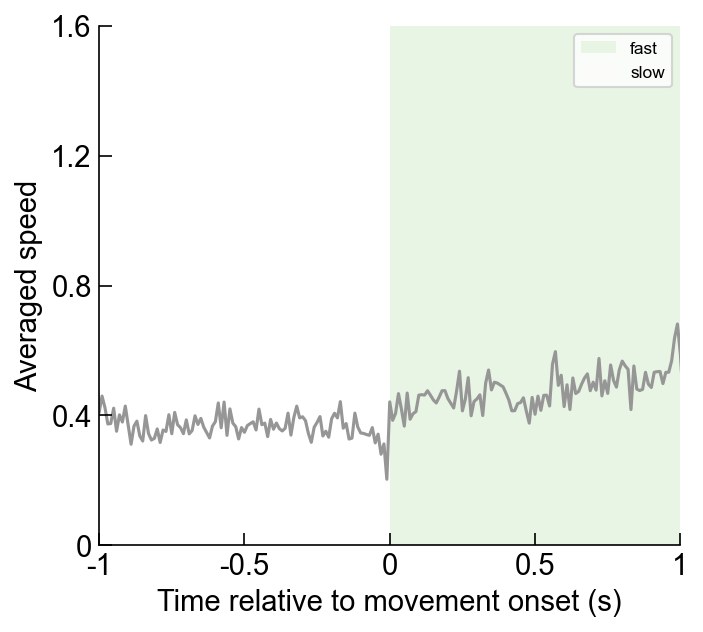

In [122]:
fig, ax = plt.subplots(figsize=(5,4.5))
#For legend only
ax.axvspan(200, 300, ymin=0,color='#e8f4e4',label='fast', lw=0,zorder=-11)
ax.axvspan(100, 200, ymin=0,color='white', alpha=0.3, lw=0,label='slow',zorder=-11)

ax.plot(avg_whisker_3003_speed,color='#969696')
ax.fill_between(np.arange(0,400),avg_whisker_3003_speed-sem_whisker_3003_speed,avg_whisker_3003_speed+sem_whisker_3003_speed,color='#969696',alpha=0,zorder=-10,lw=0)

ax.set_xlim([100,300])
ax.set_xticks([100,150,200,250,300])
ax.set_xticklabels(['-1','-0.5','0','0.5','1'])
ax.set_ylabel('Averaged speed')
ax.set_xlabel('Time relative to movement onset (s)')

ax.set_ylim([0,1.6])
ax.set_yticks([0,0.4,0.8,1.2,1.6])
ax.set_yticklabels(['0','0.4','0.8','1.2','1.6'])

ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)
ax.tick_params(length=6)
ax.set_axisbelow(False)

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
    ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(stdfont)

ax.legend()

fig.savefig(os.path.join('C:\\Users\insan\\Desktop\\Motion new\\speed legend.pdf'),transparent=False,facecolor="white")

### FR

### USE SEM

In [136]:
stdfont = 14
stdyfrac = 0.06


### Nonnorm

In [96]:
 def CalculateforRasterPSTHAcrossCells(movementsToPlots):
    
    def CalculateClustFR(clust):
        moveSpikes = []
        for movement in movementsToPlots:
            this_move_spike = ilep.getSpikeTimes(sessionfile_D9,clust=clust,starttime=movement-33000, endtime=movement+33000)
            moveSpikes.append(this_move_spike-movement)
        moveSpikes = np.array(moveSpikes,dtype='object') 
        
        bw_scott_factor = 3
        starttime = -30000 #samples
        endtime = starttime+60000 #samples
        xrange = np.linspace(starttime,endtime,num=1000)
        FR = np.full((10,len(xrange)),np.nan) 
        kf = KFold(n_splits=10)
    
        for idx,(move_index,_) in enumerate(kf.split(moveSpikes)):
            PSTHspikes = np.concatenate(moveSpikes[move_index])
            bw = len(PSTHspikes)**(-1./5) / bw_scott_factor
            KDE = gaussian_kde(PSTHspikes,bw_method=bw)
            FR[idx,:] = KDE.evaluate(xrange)
            FR[idx,:] = FR[idx,:] * len(PSTHspikes) / len(move_index) *30000 #convert unit to seconds from samples
        
        avg_FR = np.mean(FR,axis=0) 
    
        return avg_FR 
    
    ###############  
    NCR_avg_FR = []
    for clust in NCR_D9:
        avg_FR = CalculateClustFR(clust)
        NCR_avg_FR.append(avg_FR)
    NCR_avg_FR = np.array(NCR_avg_FR)
     
    NCR_avg = np.mean(NCR_avg_FR,axis=0)
    NCR_sem = sem(NCR_avg_FR,axis=0)
    #print(NCR_avg_FR[0])
    
    max_FR_value = np.max(NCR_avg+NCR_sem) * 1.1
    sequence_of_possible_axis_limits = np.array([1,2,4,6,8,10,12,16,20,30,40,50,60,80,100,120,140,150,160,180,200])
    idx_of_okay_limits = np.greater_equal(sequence_of_possible_axis_limits,max_FR_value)
    valid_limits = sequence_of_possible_axis_limits[idx_of_okay_limits]
    limit = np.min(valid_limits)
    ###
    CR_avg_FR = []
    for clust in CR_D9:
        avg_FR = CalculateClustFR(clust)
        CR_avg_FR.append(avg_FR)
    CR_avg_FR = np.array(CR_avg_FR)
     
    CR_avg = np.mean(CR_avg_FR,axis=0)
    CR_sem = sem(CR_avg_FR,axis=0)
    
    CR_max_FR_value = np.max(CR_avg+CR_sem) * 1.1
    CR_idx_of_okay_limits = np.greater_equal(sequence_of_possible_axis_limits,CR_max_FR_value)
    CR_valid_limits = sequence_of_possible_axis_limits[CR_idx_of_okay_limits]
    CR_limit = np.min(CR_valid_limits)
        
    return NCR_avg, NCR_sem, limit, CR_avg, CR_sem,CR_limit

In [97]:
#Non-normal
movementsToPlots = [integrate_3003_movement_onset_samples_arr,mouth_3003_movement_onset_samples_arr,
                    nose_3003_movement_onset_samples_arr,whisker_3003_movement_onset_samples_arr]

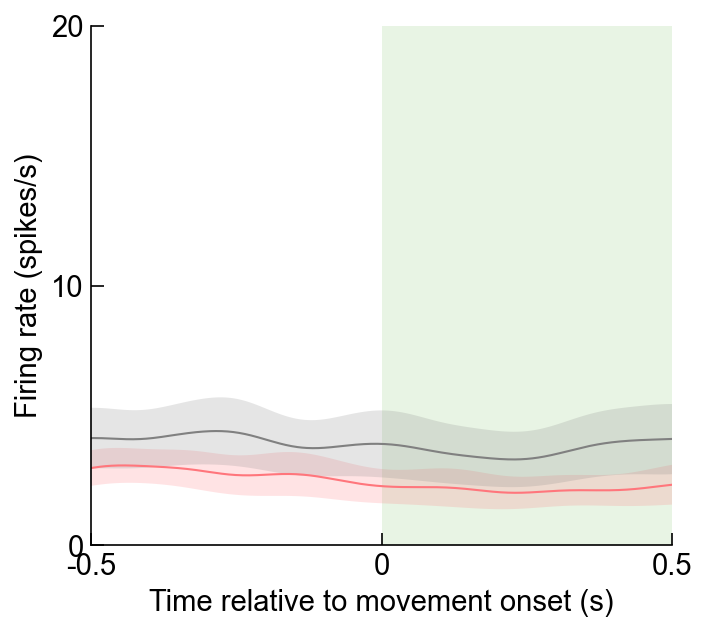

In [98]:
fig, ax = plt.subplots(figsize=(5,4.5))
    
#PSTH
starttime = -30000 #samples
endtime = starttime+60000 #samples
xrange = np.linspace(starttime,endtime,num=1000)

ax.axvspan(-30000,0, ymin=0,color='white', alpha=0.5, lw=0,zorder=-11) 
ax.axvspan(0, 30000, ymin=0,color='#e8f4e4', lw=0,zorder=-11)

NCR_avg_FR_Mouth = CalculateforRasterPSTHAcrossCells(movementsToPlots[1])[0]
NCR_sem_FR_Mouth = CalculateforRasterPSTHAcrossCells(movementsToPlots[1])[1]
ax.plot(xrange,NCR_avg_FR_Mouth, lw=1,color=NCR_COLOR)
ax.fill_between(xrange,NCR_avg_FR_Mouth-NCR_sem_FR_Mouth,NCR_avg_FR_Mouth+NCR_sem_FR_Mouth,color=NCR_COLOR,alpha=0.2,zorder=-10,lw=0)
CR_avg_FR_Mouth = CalculateforRasterPSTHAcrossCells(movementsToPlots[1])[3]
CR_sem_FR_Mouth = CalculateforRasterPSTHAcrossCells(movementsToPlots[1])[4]
ax.plot(xrange,CR_avg_FR_Mouth, lw=1,color=CR_COLOR)
ax.fill_between(xrange,CR_avg_FR_Mouth-CR_sem_FR_Mouth,CR_avg_FR_Mouth+CR_sem_FR_Mouth,color=CR_COLOR,alpha=0.2,zorder=-10,lw=0)
ax.set_xlabel('Time relative to movement onset (s)')

highest_limit = 20
ax.set_ylim([0,highest_limit])
ax.set_yticks([0,10,20])
#ax1.set_yticklabels(['0.2','0.6','1.0']) #plot purpose
ax.set_yticklabels(['0','10','20']) #real

ax.set_ylabel('Firing rate (spikes/s)')
ax.set_xlim([-15000,15000])
ax.set_xticks([-15000,0,15000])
#ax.set_xticklabels(['-100','-0.5','0','0.5','1'])#plot purpose
ax.set_xticklabels(['-0.5','0','0.5'])#real
#ax.text(18000,highest_limit,'NCR n=7',color=NCR_COLOR)
#ax.text(18000,highest_limit+3,'CR n=11',color=CR_COLOR)

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
    ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(stdfont)
ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)
ax.tick_params(length=6)
ax.set_axisbelow(False)

#fig.savefig(os.path.join('C:\\Users\insan\\Desktop\\Motion new\\non-normalized fr mouth2.pdf'),transparent=False,facecolor="white")

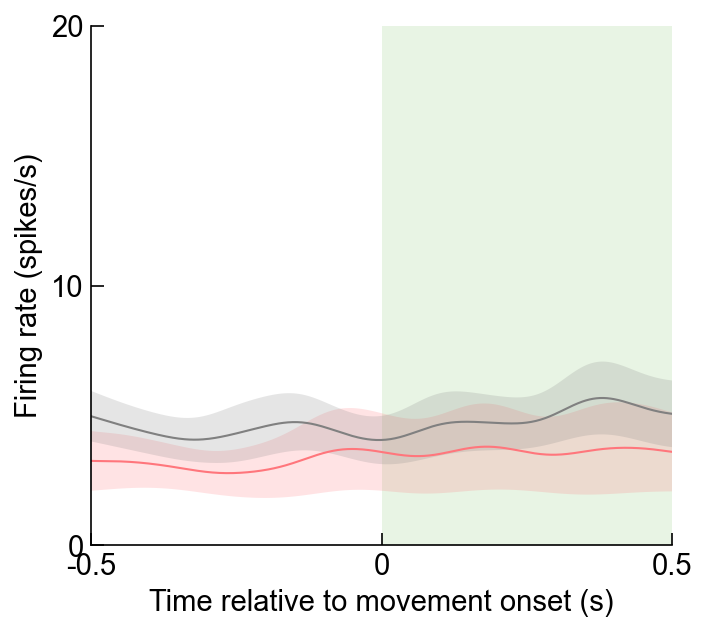

In [99]:
fig, ax = plt.subplots(figsize=(5,4.5))
    
#PSTH
starttime = -30000 #samples
endtime = starttime+60000 #samples
xrange = np.linspace(starttime,endtime,num=1000)

NCR_avg_FR_Nose = CalculateforRasterPSTHAcrossCells(movementsToPlots[2])[0]
NCR_sem_FR_Nose = CalculateforRasterPSTHAcrossCells(movementsToPlots[2])[1]
ax.plot(xrange,NCR_avg_FR_Nose, lw=1,color=NCR_COLOR,label = 'NCR')
ax.fill_between(xrange,NCR_avg_FR_Nose-NCR_sem_FR_Nose,NCR_avg_FR_Nose+NCR_sem_FR_Nose,color=NCR_COLOR,alpha=0.2,zorder=-10,lw=0)
CR_avg_FR_Nose = CalculateforRasterPSTHAcrossCells(movementsToPlots[2])[3]
CR_sem_FR_Nose = CalculateforRasterPSTHAcrossCells(movementsToPlots[2])[4]
ax.plot(xrange,CR_avg_FR_Nose, lw=1,color=CR_COLOR,label = 'CR')
ax.fill_between(xrange,CR_avg_FR_Nose-CR_sem_FR_Nose,CR_avg_FR_Nose+CR_sem_FR_Nose,color=CR_COLOR,alpha=0.2,zorder=-10,lw=0)
ax.set_xlabel('Time relative to movement onset (s)')

highest_limit = 20
ax.set_ylim([0,highest_limit])
ax.set_yticks([0,10,20])
#ax1.set_yticklabels(['0.2','0.6','1.0']) #plot purpose
ax.set_yticklabels(['0','10','20']) #real

ax.axvspan(-30000,0, ymin=0,color='white', alpha=0.3, lw=0,zorder=-11) 
ax.axvspan(0, 30000, ymin=0,color='#e8f4e4', lw=0,zorder=-11)

ax.set_ylabel('Firing rate (spikes/s)')
ax.set_xlim([-15000,15000])
ax.set_xticks([-15000,0,15000])
ax.set_xticklabels(['-0.5','0','0.5'])#real

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
    ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(stdfont)

ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)
ax.tick_params(length=6)
ax.set_axisbelow(False)

#fig.savefig(os.path.join('C:\\Users\insan\\Desktop\\Motion new\\non-normalized fr nose2.pdf'),transparent=False,facecolor="white")

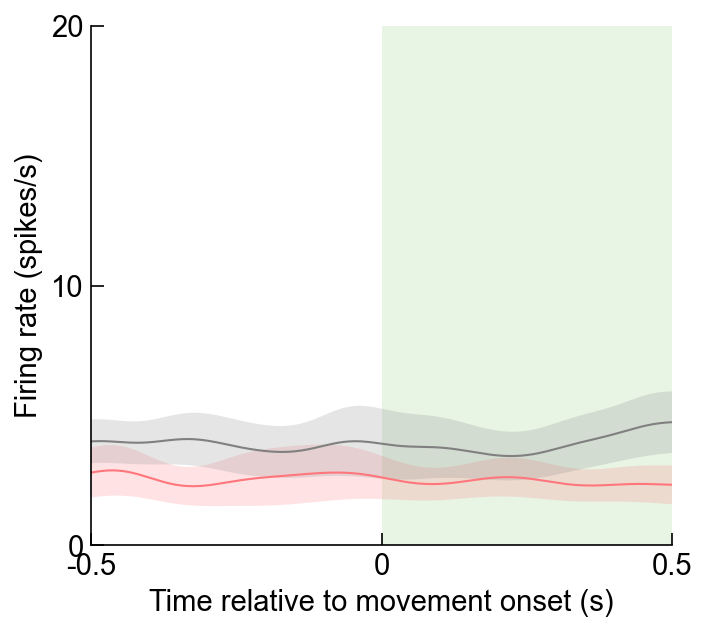

In [100]:
fig, ax = plt.subplots(figsize=(5,4.5))
    
#PSTH
starttime = -30000 #samples
endtime = starttime+60000 #samples
xrange = np.linspace(starttime,endtime,num=1000)

NCR_avg_FR_Whisker = CalculateforRasterPSTHAcrossCells(movementsToPlots[3])[0]
NCR_sem_FR_Whisker = CalculateforRasterPSTHAcrossCells(movementsToPlots[3])[1]
ax.plot(xrange,NCR_avg_FR_Whisker, lw=1,color=NCR_COLOR)
ax.fill_between(xrange,NCR_avg_FR_Whisker-NCR_sem_FR_Whisker,NCR_avg_FR_Whisker+NCR_sem_FR_Whisker,color=NCR_COLOR,alpha=0.2,zorder=-10,lw=0)
CR_avg_FR_Whisker = CalculateforRasterPSTHAcrossCells(movementsToPlots[3])[3]
CR_sem_FR_Whisker = CalculateforRasterPSTHAcrossCells(movementsToPlots[3])[4]
ax.plot(xrange,CR_avg_FR_Whisker, lw=1,color=CR_COLOR)
ax.fill_between(xrange,CR_avg_FR_Whisker-CR_sem_FR_Whisker,CR_avg_FR_Whisker+CR_sem_FR_Whisker,color=CR_COLOR,alpha=0.2,zorder=-10,lw=0)
ax.set_xlabel('Time relative to movement onset (s)')

highest_limit = 20
ax.set_ylim([0,highest_limit])
ax.set_yticks([0,10,20])
ax.set_yticklabels(['0','10','20']) #real

ax.axvspan(-30000,0, ymin=0,color='white', alpha=0.3, lw=0,zorder=-11) 
ax.axvspan(0, 30000, ymin=0,color='#e8f4e4', lw=0,zorder=-11)
ax.set_ylabel('Firing rate (spikes/s)')
ax.set_xlim([-15000,15000])
ax.set_xticks([-15000,0,15000])
#ax.set_xticklabels(['-100','-0.5','0','0.5','1'])#plot purpose
ax.set_xticklabels(['-0.5','0','0.5'])#real


for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
    ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(stdfont)

ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)
ax.tick_params(length=6)
ax.set_axisbelow(False)

#fig.savefig(os.path.join('C:\\Users\insan\\Desktop\\Motion new\\non-normalized fr whisker2.pdf'),transparent=False,facecolor="white")

### Norm

In [101]:
def CalculateforRasterPSTHAcrossCellsNormalize(movementsToPlots):

    def CalculateClustFR(clust):
        moveSpikes = []
        for movement in movementsToPlots:
            this_move_spike = ilep.getSpikeTimes(sessionfile_D9,clust=clust,starttime=movement-33000, endtime=movement+33000)
            moveSpikes.append(this_move_spike-movement)
        moveSpikes = np.array(moveSpikes,dtype='object') 

        bw_scott_factor = 3
        starttime = -30000 #samples
        endtime = starttime+60000 #samples
        xrange = np.linspace(starttime,endtime,num=1000)
        FR = np.full((10,len(xrange)),np.nan) 
        kf = KFold(n_splits=10)

        for idx,(move_index,_) in enumerate(kf.split(moveSpikes)):
            PSTHspikes = np.concatenate(moveSpikes[move_index])
            bw = len(PSTHspikes)**(-1./5) / bw_scott_factor
            KDE = gaussian_kde(PSTHspikes,bw_method=bw)
            FR[idx,:] = KDE.evaluate(xrange)
            FR[idx,:] = FR[idx,:] * len(PSTHspikes) / len(move_index) *30000 #convert unit to seconds from samples

        avg_FR = np.mean(FR,axis=0) 
        base_FR = np.mean(avg_FR[:250]) 
        norm_FR = avg_FR/base_FR - 1
        #print(len(avg_FR))
        #print(len(norm_FR))

        return avg_FR, norm_FR 
    ###############  
    CR_norm_FR = []
    for clust in CR_D9:
        norm_FR = CalculateClustFR(clust)[1]
        CR_norm_FR.append(norm_FR)
    CR_norm_FR = np.array(CR_norm_FR)

    NCR_norm_FR = []
    for clust in NCR_D9:
        norm_FR = CalculateClustFR(clust)[1]
        NCR_norm_FR.append(norm_FR)
    NCR_norm_FR = np.array(NCR_norm_FR)

    CR_norm = np.mean(CR_norm_FR,axis=0)
    CR_sem = sem(CR_norm_FR,axis=0)
    NCR_norm = np.mean(NCR_norm_FR,axis=0)
    NCR_sem = sem(NCR_norm_FR,axis=0)
    
    print(CR_D9)
    return CR_norm, NCR_norm, CR_sem, NCR_sem

[3, 15, 19, 31, 50, 77, 87, 88, 90, 91]
[3, 15, 19, 31, 50, 77, 87, 88, 90, 91]
[3, 15, 19, 31, 50, 77, 87, 88, 90, 91]
[3, 15, 19, 31, 50, 77, 87, 88, 90, 91]


meta NOT subset; don't know how to subset; dropped


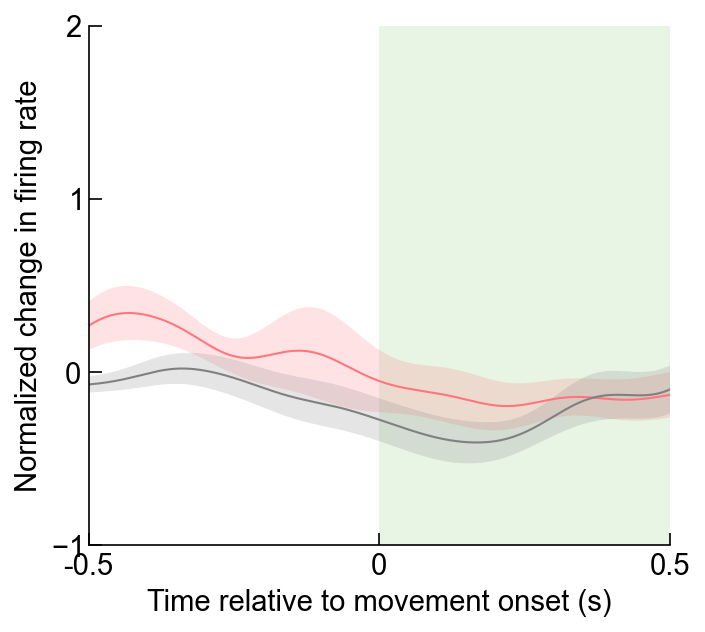

In [102]:
movementsToPlots = [integrate_3003_movement_onset_samples_arr,mouth_3003_movement_onset_samples_arr,
                   nose_3003_movement_onset_samples_arr,whisker_3003_movement_onset_samples_arr]

fig, ax = plt.subplots(figsize=(5,4.5))

FRmod = sessionfile.responsiveness[clust]['all_trials'].FRmodulation
FRmod_color = NCR_CR_cmap( (FRmod-1)/5)
region = sessionfile.meta.region
    
#PSTH
starttime = -30000 #samples
endtime = starttime+60000 #samples
xrange = np.linspace(starttime,endtime,num=1000)
    
NCR_noravg_FR_Mouth = CalculateforRasterPSTHAcrossCellsNormalize(movementsToPlots[1])[1]
NCR_norsem_FR_Mouth = CalculateforRasterPSTHAcrossCellsNormalize(movementsToPlots[1])[3]
CR_noravg_FR_Mouth = CalculateforRasterPSTHAcrossCellsNormalize(movementsToPlots[1])[0]
CR_norsem_FR_Mouth =  CalculateforRasterPSTHAcrossCellsNormalize(movementsToPlots[1])[2]
ax.plot(xrange,NCR_noravg_FR_Mouth, lw=1,color=NCR_COLOR,label = 'NCR (n=7)')
ax.plot(xrange,CR_noravg_FR_Mouth,lw=1,color=CR_COLOR,label = 'CR (n=11)')
ax.fill_between(xrange,NCR_noravg_FR_Mouth-NCR_norsem_FR_Mouth,NCR_noravg_FR_Mouth+NCR_norsem_FR_Mouth,color=NCR_COLOR,alpha=0.2,zorder=-10,lw=0)
ax.fill_between(xrange,CR_noravg_FR_Mouth-CR_norsem_FR_Mouth,CR_noravg_FR_Mouth+CR_norsem_FR_Mouth,color=CR_COLOR,alpha=0.2,zorder=-10,lw=0)
ax.set_xlabel('Time relative to movement onset (s)')

ax.set_ylim([-1,2])
ax.set_yticks([-1,0,1,2]) 
ax.axvspan(-30000,0, ymin=0,color='white', alpha=0.3, lw=0,zorder=-11) 
ax.axvspan(0, 30000, ymin=0,color='#e8f4e4', lw=0,zorder=-11)
ax.set_ylabel('Normalized change in firing rate')
ax.set_xlim([-15000,15000])
ax.set_xticks([-15000,0,15000])
ax.set_xticklabels(['-0.5','0','0.5']) #real
#ax.legend()

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
    ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(stdfont)
    
ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)
ax.tick_params(length=6)
ax.set_axisbelow(False)

fig.savefig(os.path.join('C:\\Users\insan\\Desktop\\Motion new\\normalized fr mouth2.pdf'),transparent=False,facecolor="white")

[3, 15, 19, 31, 50, 77, 87, 88, 90, 91]
[3, 15, 19, 31, 50, 77, 87, 88, 90, 91]
[3, 15, 19, 31, 50, 77, 87, 88, 90, 91]


meta NOT subset; don't know how to subset; dropped


[3, 15, 19, 31, 50, 77, 87, 88, 90, 91]


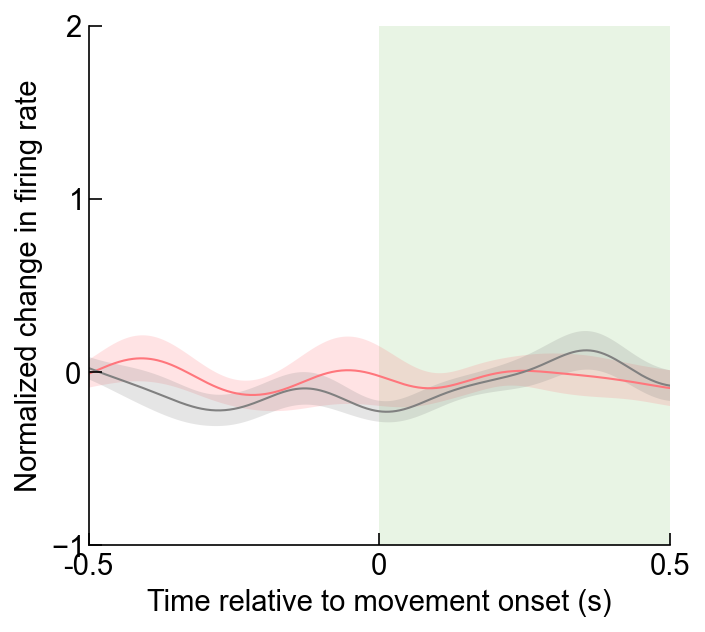

In [103]:
fig, ax = plt.subplots(figsize=(5,4.5))

FRmod = sessionfile.responsiveness[clust]['all_trials'].FRmodulation
FRmod_color = NCR_CR_cmap( (FRmod-1)/5)
region = sessionfile.meta.region
    
#PSTH
starttime = -30000 #samples
endtime = starttime+60000 #samples
xrange = np.linspace(starttime,endtime,num=1000)
    
NCR_noravg_FR_Nose = CalculateforRasterPSTHAcrossCellsNormalize(movementsToPlots[2])[1]
NCR_norsem_FR_Nose = CalculateforRasterPSTHAcrossCellsNormalize(movementsToPlots[2])[3]
CR_noravg_FR_Nose = CalculateforRasterPSTHAcrossCellsNormalize(movementsToPlots[2])[0]
CR_norsem_FR_Nose = CalculateforRasterPSTHAcrossCellsNormalize(movementsToPlots[2])[2]
ax.plot(xrange,NCR_noravg_FR_Nose, lw=1,color=NCR_COLOR,label = 'NCR')
ax.plot(xrange,CR_noravg_FR_Nose,lw=1,color=CR_COLOR,label = 'CR')
ax.fill_between(xrange,NCR_noravg_FR_Nose-NCR_norsem_FR_Nose,NCR_noravg_FR_Nose+NCR_norsem_FR_Nose,color=NCR_COLOR,alpha=0.2,zorder=-10,lw=0)
ax.fill_between(xrange,CR_noravg_FR_Nose-CR_norsem_FR_Nose,CR_noravg_FR_Nose+CR_norsem_FR_Nose,color=CR_COLOR,alpha=0.2,zorder=-10,lw=0)
ax.set_xlabel('Time relative to movement onset (s)')

ax.set_ylim([-1,2])
ax.set_yticks([-1,0,1,2]) 
#ax1.set_yticklabels(['0.2','0.6','1.0']) #plot purposes
ax.axvspan(-30000,0, ymin=0,color='white', alpha=0.3, lw=0,zorder=-11) 
ax.axvspan(0, 30000, ymin=0,color='#e8f4e4', lw=0,zorder=-11)
ax.set_ylabel('Normalized change in firing rate')
ax.set_xlim([-15000,15000])
ax.set_xticks([-15000,0,15000])
#ax.set_xticklabels(['-100','-0.5','0','0.5','1']) #for plot purposes
ax.set_xticklabels(['-0.5','0','0.5']) #real
#ax.text(18000,1.5,'NCR n=7',color=NCR_COLOR)
#ax.text(18000,1.5+0.25,'CR n=11',color=CR_COLOR)

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
    ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(stdfont)
ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)
ax.tick_params(length=6)
ax.set_axisbelow(False)


fig.savefig(os.path.join('C:\\Users\insan\\Desktop\\Motion new\\normalized fr nose2.pdf'),transparent=False,facecolor="white")

[3, 15, 19, 31, 50, 77, 87, 88, 90, 91]
[3, 15, 19, 31, 50, 77, 87, 88, 90, 91]
[3, 15, 19, 31, 50, 77, 87, 88, 90, 91]


meta NOT subset; don't know how to subset; dropped


[3, 15, 19, 31, 50, 77, 87, 88, 90, 91]


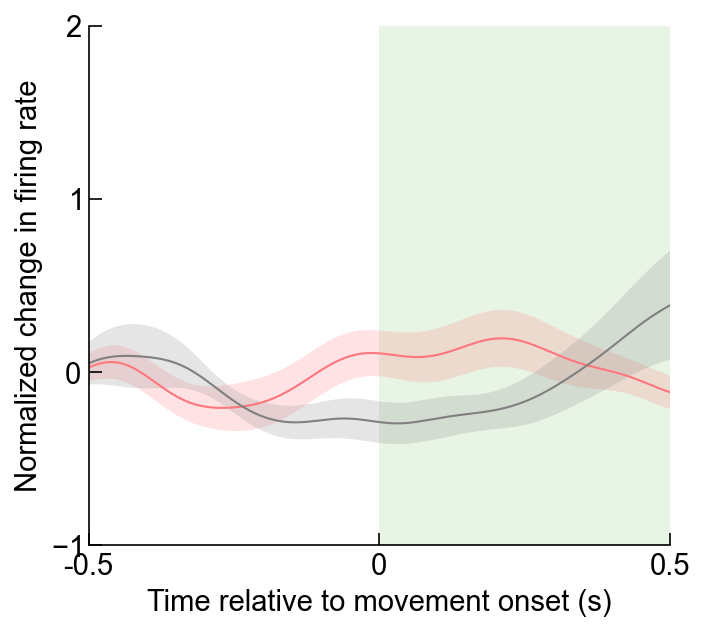

In [104]:
fig, ax = plt.subplots(figsize=(5,4.5))

FRmod = sessionfile.responsiveness[clust]['all_trials'].FRmodulation
FRmod_color = NCR_CR_cmap( (FRmod-1)/5)
region = sessionfile.meta.region
    
#PSTH
starttime = -30000 #samples
endtime = starttime+60000 #samples
xrange = np.linspace(starttime,endtime,num=1000)
    
NCR_noravg_FR_Whisker = CalculateforRasterPSTHAcrossCellsNormalize(movementsToPlots[3])[1]
NCR_norsem_FR_Whisker = CalculateforRasterPSTHAcrossCellsNormalize(movementsToPlots[3])[3]
CR_noravg_FR_Whisker = CalculateforRasterPSTHAcrossCellsNormalize(movementsToPlots[3])[0]
CR_norsem_FR_Whisker = CalculateforRasterPSTHAcrossCellsNormalize(movementsToPlots[3])[2]
ax.plot(xrange,NCR_noravg_FR_Whisker, lw=1,color=NCR_COLOR)
ax.plot(xrange,CR_noravg_FR_Whisker,lw=1,color=CR_COLOR)
ax.fill_between(xrange,NCR_noravg_FR_Whisker-NCR_norsem_FR_Whisker,NCR_noravg_FR_Whisker+NCR_norsem_FR_Whisker,color=NCR_COLOR,alpha=0.2,zorder=-10,lw=0)
ax.fill_between(xrange,CR_noravg_FR_Whisker-CR_norsem_FR_Whisker,CR_noravg_FR_Whisker+CR_norsem_FR_Whisker,color=CR_COLOR,alpha=0.2,zorder=-10,lw=0)
ax.set_xlabel('Time relative to movement onset (s)')

ax.set_ylim([-1,2])
ax.set_yticks([-1,0,1,2]) 
#ax1.set_yticklabels(['0.2','0.6','1.0']) #plot purposes
ax.axvspan(-30000,0, ymin=0,color='white', alpha=0.3, lw=0,zorder=-11) 
ax.axvspan(0, 30000, ymin=0,color='#e8f4e4', lw=0,zorder=-11)
ax.set_ylabel('Normalized change in firing rate')
ax.set_xlim([-15000,15000])
ax.set_xticks([-15000,0,15000])
#ax.set_xticklabels(['-100','-0.5','0','0.5','1']) #for plot purposes
ax.set_xticklabels(['-0.5','0','0.5']) #real
#ax.text(18000,1.5,'NCR n=7',color=NCR_COLOR)
#ax.text(18000,1.5+0.25,'CR n=11',color=CR_COLOR)

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
    ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(stdfont)

ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)
ax.tick_params(length=6)
ax.set_axisbelow(False)

fig.savefig(os.path.join('C:\\Users\insan\\Desktop\\Motion new\\normalized fr whisker2.pdf'),transparent=False,facecolor="white")

## Stats prepare

In [71]:
NCR_D9

[8, 33, 43, 44, 59, 92, 96]

In [72]:
CR_D9

[3, 13, 15, 19, 31, 50, 77, 87, 88, 90, 91]

In [73]:
CR_D9 = [3, 15, 19, 31, 50, 77, 87, 88, 90, 91]

In [74]:
CR_D9 

[3, 15, 19, 31, 50, 77, 87, 88, 90, 91]

In [76]:
movementsToPlots = [integrate_3003_movement_onset_samples_arr,mouth_3003_movement_onset_samples_arr,
                    nose_3003_movement_onset_samples_arr,whisker_3003_movement_onset_samples_arr]

## Jan 2024

In [106]:
def CalculateforStats(movementsToPlots):

    def CalculateClustFR(clust):
        moveSpikes = []
        for movement in movementsToPlots:
            this_move_spike = ilep.getSpikeTimes(sessionfile_D9,clust=clust,starttime=movement-33000, endtime=movement+33000)
            moveSpikes.append(this_move_spike-movement)
        moveSpikes = np.array(moveSpikes,dtype='object') 

        bw_scott_factor = 3
        starttime = -30000 #samples
        endtime = starttime+60000 #samples
        xrange = np.linspace(starttime,endtime,num=40)
        FR = np.full((10,len(xrange)),np.nan) 
        kf = KFold(n_splits=10)

        for idx,(move_index,_) in enumerate(kf.split(moveSpikes)):
            PSTHspikes = np.concatenate(moveSpikes[move_index])
            bw = len(PSTHspikes)**(-1./5) / bw_scott_factor
            KDE = gaussian_kde(PSTHspikes,bw_method=bw)
            FR[idx,:] = KDE.evaluate(xrange)
            FR[idx,:] = FR[idx,:] * len(PSTHspikes) / len(move_index) *30000 #convert unit to seconds from samples

        avg_FR = np.mean(FR,axis=0) 

        return avg_FR 

    ###############  
    NCR_avg_FR = []
    NCR_base_FR = []
    NCR_slow_FR = []
    NCR_fast_FR = []

    for clust in NCR_D9:
        avg_FR = CalculateClustFR(clust)
        base_FR = avg_FR[:10] #divede into 10 periods
        slow_FR = avg_FR[10:20]
        fast_FR = avg_FR[20:30]

        NCR_avg_FR.append(avg_FR) #FR for each cell
        NCR_base_FR.append(base_FR)
        NCR_slow_FR.append(slow_FR)
        NCR_fast_FR.append(fast_FR)
        
    NCR_avg_FR = np.array(NCR_avg_FR) #len=1000 for each cell
    NCR_base_FR = np.array(NCR_base_FR) 
    NCR_slow_FR = np.array(NCR_slow_FR)
    NCR_fast_FR = np.array(NCR_fast_FR)
    
    NCR_avg = np.mean(NCR_avg_FR,axis=0)
    NCR_sem = sem(NCR_avg_FR,axis=0)
      
    ###############  
    CR_avg_FR = []
    CR_base_FR = []
    CR_slow_FR = []
    CR_fast_FR = []

    for clust in CR_D9:
        avg_FR = CalculateClustFR(clust)
        base_FR = avg_FR[:10] #divede into 10 periods
        slow_FR = avg_FR[10:20]
        fast_FR = avg_FR[20:30]

        CR_avg_FR.append(avg_FR) #FR for each cell
        CR_base_FR.append(base_FR)
        CR_slow_FR.append(slow_FR)
        CR_fast_FR.append(fast_FR)
        
    CR_avg_FR = np.array(CR_avg_FR) #len=1000 for each cell
    CR_base_FR = np.array(CR_base_FR) 
    CR_slow_FR = np.array(CR_slow_FR)
    CR_fast_FR = np.array(CR_fast_FR)
    
    CR_avg = np.mean(CR_avg_FR,axis=0)
    CR_sem = sem(CR_avg_FR,axis=0)
      

    return NCR_base_FR, NCR_slow_FR, NCR_fast_FR, CR_base_FR, CR_slow_FR, CR_fast_FR

In [133]:
#NCR
mouth_NCR_baseline = CalculateforStats(movementsToPlots[1])[0]
mouth_NCR_slow = CalculateforStats(movementsToPlots[1])[1]
mouth_NCR_fast = CalculateforStats(movementsToPlots[1])[2]

nose_NCR_baseline = CalculateforStats(movementsToPlots[2])[0]
nose_NCR_slow = CalculateforStats(movementsToPlots[2])[1]
nose_NCR_fast = CalculateforStats(movementsToPlots[2])[2]

whisker_NCR_baseline = CalculateforStats(movementsToPlots[3])[0]
whisker_NCR_slow = CalculateforStats(movementsToPlots[3])[1]
whisker_NCR_fast = CalculateforStats(movementsToPlots[3])[2]


In [134]:
mean_mouth_NCR_slow = np.mean(mouth_NCR_slow,axis=1)
mean_mouth_NCR_fast = np.mean(mouth_NCR_fast,axis=1)

mean_nose_NCR_slow = np.mean(nose_NCR_slow,axis=1)
mean_nose_NCR_fast = np.mean(nose_NCR_fast,axis=1)

mean_whisker_NCR_slow = np.mean(whisker_NCR_slow,axis=1)
mean_whisker_NCR_fast = np.mean(whisker_NCR_fast,axis=1)

In [135]:
import scipy.stats
scipy.stats.wilcoxon(mean_mouth_NCR_slow,mean_mouth_NCR_fast)

WilcoxonResult(statistic=0.0, pvalue=0.015625)

In [136]:
scipy.stats.wilcoxon(mean_nose_NCR_slow,mean_nose_NCR_fast)

WilcoxonResult(statistic=13.0, pvalue=0.9375)

In [137]:
scipy.stats.wilcoxon(mean_whisker_NCR_slow,mean_whisker_NCR_fast)

WilcoxonResult(statistic=12.0, pvalue=0.8125)

In [138]:
#CR
mouth_CR_baseline = CalculateforStats(movementsToPlots[1])[3]
mouth_CR_slow = CalculateforStats(movementsToPlots[1])[4]
mouth_CR_fast = CalculateforStats(movementsToPlots[1])[5]

nose_CR_baseline = CalculateforStats(movementsToPlots[2])[3]
nose_CR_slow = CalculateforStats(movementsToPlots[2])[4]
nose_CR_fast = CalculateforStats(movementsToPlots[2])[5]

whisker_CR_baseline = CalculateforStats(movementsToPlots[3])[3]
whisker_CR_slow = CalculateforStats(movementsToPlots[3])[4]
whisker_CR_fast = CalculateforStats(movementsToPlots[3])[5]

In [139]:
mean_mouth_CR_slow = np.mean(mouth_CR_slow,axis=1)
mean_mouth_CR_fast = np.mean(mouth_CR_fast,axis=1)

mean_nose_CR_slow = np.mean(nose_CR_slow,axis=1)
mean_nose_CR_fast = np.mean(nose_CR_fast,axis=1)

mean_whisker_CR_slow = np.mean(whisker_CR_slow,axis=1)
mean_whisker_CR_fast = np.mean(whisker_CR_fast,axis=1)

In [140]:
scipy.stats.wilcoxon(mean_mouth_CR_slow,mean_mouth_CR_fast)

WilcoxonResult(statistic=0.0, pvalue=0.001953125)

In [141]:
scipy.stats.wilcoxon(mean_nose_CR_slow,mean_nose_CR_fast)

WilcoxonResult(statistic=8.0, pvalue=0.048828125)

In [142]:
scipy.stats.wilcoxon(mean_whisker_CR_slow,mean_whisker_CR_fast)

WilcoxonResult(statistic=25.0, pvalue=0.845703125)

In [144]:
# NCR:
#     mouth:0.015625 *
#     nose:0.9375 
#     whisker:0.8125
    
# CR:
#     mouth:0.001953125 **
#     nose:0.048828125 *
#     whisker:0.845703125
    
        
        

In [89]:
# 0.05 = *
# 0.01 = **
# 0.001 = ***
# 0.0001 = ****

In [108]:
mean_mouth_NCR_slow = np.mean(mouth_NCR_slow,axis=1)
mean_mouth_NCR_fast = np.mean(mouth_NCR_fast,axis=1)



In [126]:
import scipy.stats
scipy.stats.wilcoxon(mean_mouth_NCR_slow,mean_mouth_NCR_fast)

WilcoxonResult(statistic=0.0, pvalue=0.015625)

In [127]:
scipy.stats.mannwhitneyu(mean_mouth_NCR_slow,mean_mouth_NCR_fast)

MannwhitneyuResult(statistic=33.0, pvalue=0.31759906759906764)

In [148]:
mean_mouth_NCR_slow 

array([2.40260879, 1.2730559 , 6.34394492, 1.87567385, 4.38601212,
       1.16451829, 2.03538458])

In [149]:
mean_mouth_NCR_fast

array([2.25718103, 0.71380108, 5.05995468, 0.79358008, 4.00709536,
       1.06519817, 1.22270488])

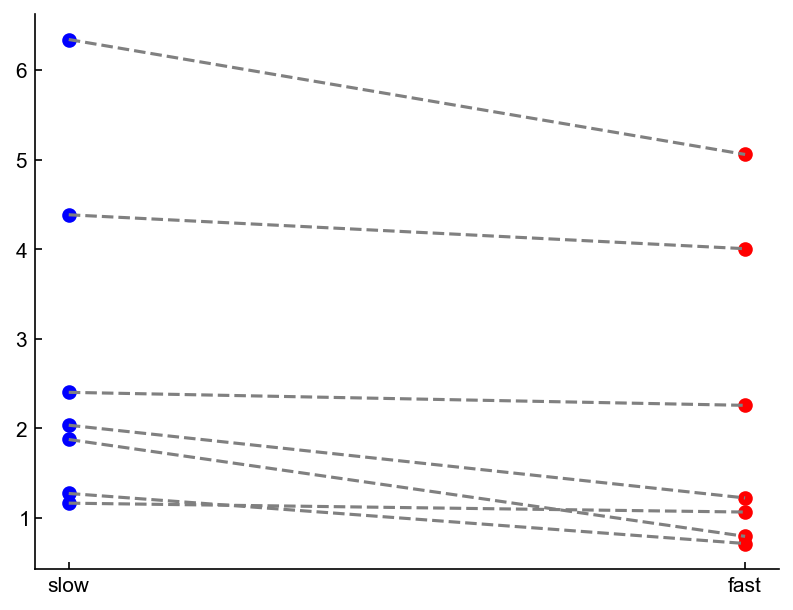

In [124]:

slow_category = np.ones_like(mean_mouth_NCR_slow)
fast_category = np.full_like(mean_mouth_NCR_fast,2)

for i in range(7):
    plt.plot([1,2],[mean_mouth_NCR_slow[i],mean_mouth_NCR_fast[i]],color = 'gray',linestyle='--')

plt.xticks([1,2],['slow','fast'])
plt.scatter(slow_category,mean_mouth_NCR_slow,color='blue')
plt.scatter(fast_category,mean_mouth_NCR_fast,color='red')

## New Stats (Dec2023)

In [292]:
def CalculateforStats(movementsToPlots):

    def CalculateClustFR(clust):
        moveSpikes = []
        for movement in movementsToPlots:
            this_move_spike = ilep.getSpikeTimes(sessionfile_D9,clust=clust,starttime=movement-33000, endtime=movement+33000)
            moveSpikes.append(this_move_spike-movement)
        moveSpikes = np.array(moveSpikes,dtype='object') 

        bw_scott_factor = 3
        starttime = -30000 #samples
        endtime = starttime+60000 #samples
        xrange = np.linspace(starttime,endtime,num=40)
        FR = np.full((10,len(xrange)),np.nan) 
        kf = KFold(n_splits=10)

        for idx,(move_index,_) in enumerate(kf.split(moveSpikes)):
            PSTHspikes = np.concatenate(moveSpikes[move_index])
            bw = len(PSTHspikes)**(-1./5) / bw_scott_factor
            KDE = gaussian_kde(PSTHspikes,bw_method=bw)
            FR[idx,:] = KDE.evaluate(xrange)
            FR[idx,:] = FR[idx,:] * len(PSTHspikes) / len(move_index) *30000 #convert unit to seconds from samples

        avg_FR = np.mean(FR,axis=0) 

        return avg_FR 

    ###############  
    NCR_avg_FR = []
    NCR_base_FR = []
    NCR_test_FR = []

    for clust in NCR_D9:
        avg_FR = CalculateClustFR(clust)
        base_FR = avg_FR[10:20] #divede into 10 periods
        test_FR = avg_FR[20:30] #divided into 10 periods

        NCR_avg_FR.append(avg_FR) #FR for each cell
        NCR_base_FR.append(base_FR)
        NCR_test_FR.append(test_FR)
        
    NCR_avg_FR = np.array(NCR_avg_FR) #len=1000 for each cell
    NCR_base_FR = np.array(NCR_base_FR) 
    NCR_test_FR = np.array(NCR_test_FR) 
    
    NCR_avg = np.mean(NCR_avg_FR,axis=0)
    NCR_avg_slow = np.mean(NCR_base_FR,axis=0)
    NCR_avg_fast = np.mean(NCR_test_FR,axis=0)
      
    ###############  
    CR_avg_FR = []
    CR_base_FR = []
    CR_test_FR = []

    for clust in CR_D9:
        avg_FR = CalculateClustFR(clust)
        base_FR = avg_FR[10:20] #slow
        test_FR = avg_FR[20:30] #fast

        CR_avg_FR.append(avg_FR) #FR for each cell
        CR_base_FR.append(base_FR)
        CR_test_FR.append(test_FR)
        
    CR_avg_FR = np.array(CR_avg_FR) #len=1000 for each cell
    CR_base_FR = np.array(CR_base_FR) 
    CR_test_FR = np.array(CR_test_FR) 
    
    CR_avg = np.mean(CR_avg_FR,axis=0)
    CR_avg_slow = np.mean(CR_base_FR,axis=0)
    CR_avg_fast = np.mean(CR_test_FR,axis=0)
      

    return NCR_base_FR, NCR_test_FR, CR_base_FR, CR_test_FR, NCR_avg_slow, NCR_avg_fast, CR_avg_slow, CR_avg_fast

In [293]:
mouth_NCR_baseline = CalculateforStats(movementsToPlots[1])[0]
mouth_NCR_test = CalculateforStats(movementsToPlots[1])[1]

mouth_CR_baseline = CalculateforStats(movementsToPlots[1])[2]
mouth_CR_test = CalculateforStats(movementsToPlots[1])[3]

nose_NCR_baseline = CalculateforStats(movementsToPlots[2])[0]
nose_NCR_test = CalculateforStats(movementsToPlots[2])[1]

nose_CR_baseline = CalculateforStats(movementsToPlots[2])[2]
nose_CR_test = CalculateforStats(movementsToPlots[2])[3]

whisker_NCR_baseline = CalculateforStats(movementsToPlots[3])[0]
whisker_NCR_test = CalculateforStats(movementsToPlots[3])[1]

whisker_CR_baseline = CalculateforStats(movementsToPlots[3])[2]
whisker_CR_test = CalculateforStats(movementsToPlots[3])[3]

In [299]:
whisker_NCR_test

array([[2.0162217 , 2.2354936 , 2.44016068, 2.518691  , 2.42876818,
        2.29838068, 2.35402321, 2.68484002, 3.04764895, 3.12293479],
       [1.49997579, 1.46138866, 1.38964942, 1.28567004, 1.19475058,
        1.17965387, 1.26222737, 1.38163375, 1.40915748, 1.27857584],
       [6.06609181, 5.53845826, 5.53376559, 5.91411783, 6.10586807,
        5.68560214, 5.08320085, 4.76319517, 4.75377975, 4.96321928],
       [1.06815314, 1.14501752, 1.208484  , 1.22069094, 1.16203808,
        1.03854299, 0.88096431, 0.70752091, 0.52660585, 0.39284439],
       [4.4027751 , 3.68421128, 3.82320271, 4.38789357, 4.6460157 ,
        4.45101349, 4.22191589, 4.44818234, 4.818792  , 4.84061916],
       [0.76243802, 0.79575032, 0.87539058, 1.00811387, 1.14012324,
        1.22824536, 1.2439245 , 1.16372674, 1.01555703, 0.87550569],
       [1.69793065, 1.68173968, 1.6792645 , 1.70031624, 1.6346847 ,
        1.45129164, 1.23365442, 1.06891222, 0.97013002, 0.90484583]])

## Stats based on [average all cell time point1, point 2...]

In [276]:
mouth_NCR_avg_slow = CalculateforStats(movementsToPlots[1])[4]
mouth_NCR_avg_fast = CalculateforStats(movementsToPlots[1])[5]
mouth_CR_avg_slow = CalculateforStats(movementsToPlots[1])[6]
mouth_CR_avg_fast = CalculateforStats(movementsToPlots[1])[7]

In [277]:
mouth_NCR_avg_slow

array([3.01878464, 3.07428074, 3.02614402, 2.93645185, 2.77771108,
       2.69464588, 2.74025366, 2.7050947 , 2.52167956, 2.33523737])

In [278]:
mouth_NCR_avg_fast

array([2.24984157, 2.24204796, 2.20509209, 2.09108306, 2.02344589,
       2.07437384, 2.12191385, 2.11863377, 2.17051168, 2.30236382])

In [279]:
scipy.stats.mannwhitneyu(mouth_NCR_avg_slow,mouth_NCR_avg_fast)

MannwhitneyuResult(statistic=100.0, pvalue=0.00018267179110955002)

In [280]:
scipy.stats.mannwhitneyu(mouth_CR_avg_slow,mouth_CR_avg_fast)

MannwhitneyuResult(statistic=87.0, pvalue=0.00579535854433471)

In [282]:
nose_NCR_avg_slow = CalculateforStats(movementsToPlots[2])[4]
nose_NCR_avg_fast = CalculateforStats(movementsToPlots[2])[5]
nose_CR_avg_slow = CalculateforStats(movementsToPlots[2])[6]
nose_CR_avg_fast = CalculateforStats(movementsToPlots[2])[7]

In [286]:
scipy.stats.mannwhitneyu(nose_NCR_avg_slow,nose_NCR_avg_fast)

MannwhitneyuResult(statistic=13.0, pvalue=0.00579535854433471)

In [288]:
scipy.stats.mannwhitneyu(nose_CR_avg_slow,nose_CR_avg_fast)

MannwhitneyuResult(statistic=16.0, pvalue=0.011329696684474665)

In [289]:
whisker_NCR_avg_slow = CalculateforStats(movementsToPlots[3])[4]
whisker_NCR_avg_fast = CalculateforStats(movementsToPlots[3])[5]
whisker_CR_avg_slow = CalculateforStats(movementsToPlots[3])[6]
whisker_CR_avg_fast = CalculateforStats(movementsToPlots[3])[7]

In [290]:
scipy.stats.mannwhitneyu(whisker_NCR_avg_slow,whisker_NCR_avg_fast)

MannwhitneyuResult(statistic=80.0, pvalue=0.025748080821108063)

In [291]:
scipy.stats.mannwhitneyu(whisker_CR_avg_slow,whisker_CR_avg_fast)

MannwhitneyuResult(statistic=58.0, pvalue=0.5707503880581739)

## Stats (need to check again)

In [267]:
mouth_NCR_baseline = CalculateforStats(movementsToPlots[1])[0]
mouth_NCR_test = CalculateforStats(movementsToPlots[1])[1]

mouth_CR_baseline = CalculateforStats(movementsToPlots[1])[2]
mouth_CR_test = CalculateforStats(movementsToPlots[1])[3]

In [269]:
mouth_NCR_baseline #each small array is a cell

array([[2.61650201, 2.90054594, 3.06597753, 2.96812736, 2.62227826,
        2.21534323, 1.94047842, 1.85116559, 1.88951239, 1.95615719],
       [1.52150436, 1.54587658, 1.55654207, 1.50945739, 1.39395514,
        1.23852382, 1.10440783, 1.02188427, 0.95887265, 0.87953484],
       [5.79842752, 6.08548648, 6.30053596, 6.64023991, 6.60908238,
        6.39614423, 6.57044699, 6.73909602, 6.44136417, 5.85862552],
       [3.11139008, 3.18890998, 2.86925586, 2.34145157, 1.7879022 ,
        1.35340188, 1.09166135, 0.98413842, 0.99624582, 1.03238133],
       [5.19181185, 4.68449127, 4.28088014, 4.16578072, 4.25458423,
        4.74721569, 5.08624767, 4.51349921, 3.60369504, 3.33191541],
       [1.30006304, 1.41814125, 1.46318968, 1.39951763, 1.24030891,
        1.08763446, 1.01557478, 0.97392583, 0.9010437 , 0.84578364],
       [1.59179359, 1.69651364, 1.64662688, 1.53058839, 1.53586641,
        1.82425787, 2.37295861, 2.85195356, 2.86102315, 2.44226369]])

In [121]:
mean_mouth_NCR_baseline = np.mean(mouth_NCR_baseline,axis=1)
mean_mouth_CR_baseline = np.mean(mouth_CR_baseline,axis=1)

In [206]:
scipy.stats.mannwhitneyu(mouth_CR_test,mouth_CR_baseline)

MannwhitneyuResult(statistic=array([41., 39., 37., 37., 35., 41., 45., 49., 51., 53.]), pvalue=array([0.52052288, 0.42735531, 0.34470422, 0.34470422, 0.27303634,
       0.52052288, 0.73373   , 0.96984998, 0.96984998, 0.85010674]))

In [215]:
scipy.stats.mannwhitneyu(mouth_NCR_test,mouth_NCR_baseline)

MannwhitneyuResult(statistic=array([17., 16., 16., 15., 15., 17., 18., 19., 22., 23.]), pvalue=array([0.38286713, 0.31759907, 0.31759907, 0.25932401, 0.25932401,
       0.38286713, 0.45571096, 0.53496503, 0.80477855, 0.90151515]))

In [216]:
scipy.stats.mannwhitneyu(nose_NCR_test,nose_NCR_baseline)

MannwhitneyuResult(statistic=array([23., 20., 20., 22., 24., 26., 27., 24., 24., 23.]), pvalue=array([0.90151515, 0.62004662, 0.62004662, 0.80477855, 1.        ,
       0.90151515, 0.80477855, 1.        , 1.        , 0.90151515]))

In [217]:
scipy.stats.mannwhitneyu(nose_CR_test,nose_CR_baseline)

MannwhitneyuResult(statistic=array([39., 43., 51., 53., 57., 59., 58., 57., 57., 57.]), pvalue=array([0.42735531, 0.62317622, 0.96984998, 0.85010674, 0.62317622,
       0.52052288, 0.57075039, 0.62317622, 0.62317622, 0.62317622]))

In [218]:
scipy.stats.mannwhitneyu(whisker_NCR_test,whisker_NCR_baseline)

MannwhitneyuResult(statistic=array([25., 26., 27., 30., 30., 28., 27., 25., 22., 19.]), pvalue=array([1.        , 0.90151515, 0.80477855, 0.53496503, 0.53496503,
       0.71037296, 0.80477855, 1.        , 0.80477855, 0.53496503]))

In [219]:
scipy.stats.mannwhitneyu(whisker_CR_test,whisker_CR_baseline)

MannwhitneyuResult(statistic=array([42., 41., 44., 45., 46., 51., 54., 57., 59., 63.]), pvalue=array([0.57075039, 0.52052288, 0.67758496, 0.73373   , 0.79133678,
       0.96984998, 0.79133678, 0.62317622, 0.52052288, 0.34470422]))

## Stats based on [[time point11 all cell],[time point12 all cell]...] vs baseline which is [[avergae slow window all cell]]

In [294]:
mean_mouth_NCR_baseline

array([2.40260879, 1.2730559 , 6.34394492, 1.87567385, 4.38601212,
       1.16451829, 2.03538458])

In [123]:
def nonparametricIndependentStatsCompareToBaseline(data,fr_bins):
    # data = [baseline,test]

    ### Create dataframe ###
    phase = []
    context = []
    FR = []
    for fr_bin in range(fr_bins):
        phase = phase + len(data.baseline)*[fr_bin] + len(data.test[fr_bin])*[fr_bin]
        #print(len(phase))
        context = context + len(data.baseline)*["baseline"] + len(data.test[fr_bin])*["experimental"]
        #print(len(context))
        FR_frame = np.concatenate([data.baseline, data.test[fr_bin]])

        FR.append(FR_frame)
    ####################################################################################
    FR = np.concatenate(FR)
    

    df = pd.DataFrame({"phase": phase, "context": context, "FR": FR})

    ### Anova ###
    anova = pg.anova(data=df, dv='FR', between=['phase','context'], detailed=True)
    print(anova)
    print()



    ### Create and print results ###
    pairwise_mwu = pg.pairwise_tests(data=df, dv='FR', between=['phase','context'], padjust="fdr_bh", parametric=False, )
    print(pairwise_mwu[pairwise_mwu["Contrast"] == "phase * context"][["phase","A", "B", "p-unc", "p-corr", "hedges"]])
    
    print(len(FR))
    print(len(phase))
    print(len(context))
    
    return pairwise_mwu


In [124]:
#Mouth
#NCR
data = SimpleNamespace()
data.baseline = mean_mouth_NCR_baseline
data.test = np.transpose(mouth_NCR_test)
pairwise_mwu = nonparametricIndependentStatsCompareToBaseline(data,10)
#pairwise_mwu.to_csv('C:\\Users\insan\\Desktop\\Motion new\\mouth_stats_NCR.csv')

#CR
data = SimpleNamespace()
data.baseline = mean_mouth_CR_baseline
data.test = np.transpose(mouth_CR_test)
pairwise_mwu = nonparametricIndependentStatsCompareToBaseline(data,10)
#pairwise_mwu.to_csv('C:\\Users\insan\\Desktop\\Motion new\\mouth_stats_CR.csv')

            Source          SS   DF         MS         F     p-unc       np2
0            phase    0.248866    9   0.027652  0.008284  1.000000  0.000621
1          context   13.588772    1  13.588772  4.070815  0.045861  0.032810
2  phase * context    0.248866    9   0.027652  0.008284  1.000000  0.000621
3         Residual  400.571482  120   3.338096       NaN       NaN       NaN

   phase         A             B     p-unc    p-corr    hedges
46     0  baseline  experimental  0.382867  0.382867  0.274126
47     1  baseline  experimental  0.317599  0.382867  0.268981
48     2  baseline  experimental  0.317599  0.382867  0.281029
49     3  baseline  experimental  0.317599  0.382867  0.348346
50     4  baseline  experimental  0.317599  0.382867  0.400089
51     5  baseline  experimental  0.317599  0.382867  0.378882
52     6  baseline  experimental  0.317599  0.382867  0.356074
53     7  baseline  experimental  0.317599  0.382867  0.356804
54     8  baseline  experimental  0.317599  0.3

In [250]:
nose_NCR_baseline = CalculateforStats(movementsToPlots[2])[0]
nose_NCR_test = CalculateforStats(movementsToPlots[2])[1]

nose_CR_baseline = CalculateforStats(movementsToPlots[2])[2]
nose_CR_test = CalculateforStats(movementsToPlots[2])[3]

whisker_NCR_baseline = CalculateforStats(movementsToPlots[3])[0]
whisker_NCR_test = CalculateforStats(movementsToPlots[3])[1]

whisker_CR_baseline = CalculateforStats(movementsToPlots[3])[2]
whisker_CR_test = CalculateforStats(movementsToPlots[3])[3]

mean_nose_NCR_baseline = np.mean(nose_NCR_baseline,axis=1)
mean_whisker_NCR_baseline = np.mean(whisker_NCR_baseline,axis=1)

mean_nose_CR_baseline = np.mean(nose_CR_baseline,axis=1)
mean_whisker_CR_baseline = np.mean(whisker_CR_baseline,axis=1)

In [251]:
#Nose
#NCR
data = SimpleNamespace()
data.baseline = mean_nose_NCR_baseline
data.test = np.transpose(nose_NCR_test)
pairwise_mwu = nonparametricIndependentStatsCompareToBaseline(data,10)

#CR
data = SimpleNamespace()
data.baseline = mean_nose_CR_baseline
data.test = np.transpose(nose_CR_test)
pairwise_mwu = nonparametricIndependentStatsCompareToBaseline(data,10)

#Whisker
#NCR
data = SimpleNamespace()
data.baseline = mean_whisker_NCR_baseline
data.test = np.transpose(whisker_NCR_test)
pairwise_mwu = nonparametricIndependentStatsCompareToBaseline(data,10)

#CR
data = SimpleNamespace()
data.baseline = mean_whisker_CR_baseline
data.test = np.transpose(whisker_CR_test)
pairwise_mwu = nonparametricIndependentStatsCompareToBaseline(data,10)

            Source           SS   DF         MS         F     p-unc       np2
0            phase     0.433010    9   0.048112  0.003640  1.000000  0.000273
1          context     6.883467    1   6.883467  0.520793  0.471907  0.004321
2  phase * context     0.433010    9   0.048112  0.003640  1.000000  0.000273
3         Residual  1586.073772  120  13.217281       NaN       NaN       NaN

   phase         A             B     p-unc  p-corr    hedges
46     0  baseline  experimental  0.901515     1.0 -0.087395
47     1  baseline  experimental  0.804779     1.0 -0.073433
48     2  baseline  experimental  0.710373     1.0 -0.120668
49     3  baseline  experimental  1.000000     1.0 -0.154116
50     4  baseline  experimental  1.000000     1.0 -0.128694
51     5  baseline  experimental  1.000000     1.0 -0.086235
52     6  baseline  experimental  1.000000     1.0 -0.097232
53     7  baseline  experimental  0.901515     1.0 -0.129660
54     8  baseline  experimental  0.901515     1.0 -0.138568

## Stats based on combinations [[time point all cell],[time point all cell]...]

In [252]:
mouth_CR_slow = np.transpose(mouth_CR_baseline)
mouth_CR_fast = np.transpose(mouth_CR_test)

In [253]:
mouth_CR_slow

array([[ 0.44706958,  6.90918683,  4.25778565,  2.01332461,  6.43284334,
         0.55359443, 10.57488968,  8.12526574,  1.41588885,  0.54731715],
       [ 0.5635853 ,  7.49062125,  4.0756962 ,  2.27898548,  6.38341152,
         0.51955846,  9.93840166,  7.77719449,  1.1667144 ,  0.65228262],
       [ 0.6912033 ,  7.97949747,  4.18749373,  2.46514652,  6.1471891 ,
         0.52626323,  9.89738089,  7.94338216,  1.03477265,  0.68299046],
       [ 0.76511866,  8.3368263 ,  4.33493618,  2.35237314,  6.16621364,
         0.52900666, 10.78685111,  8.34098753,  0.99669786,  0.59509201],
       [ 0.77223695,  8.35827642,  4.33738814,  1.95250172,  6.4267849 ,
         0.49553879, 11.70503908,  8.47132259,  0.99980444,  0.4725692 ],
       [ 0.76534366,  7.68336854,  4.37585479,  1.49920171,  6.7777296 ,
         0.43633801, 11.27139726,  8.42715428,  0.98746475,  0.39653378],
       [ 0.77625444,  6.59920212,  4.65200196,  1.16168911,  6.91428316,
         0.37916464,  9.54111281,  8.14268219

In [254]:
mouth_CR_fast

array([[ 0.26940796,  7.56320205,  4.19389427,  0.67835469,  6.21671553,
         0.1929688 , 11.34120231,  7.48051228,  0.45164224,  0.2268833 ],
       [ 0.13165833,  7.27796802,  4.22233214,  0.74281605,  5.92427491,
         0.16583712, 10.28600601,  7.4089912 ,  0.38110186,  0.21069781],
       [ 0.08356058,  6.67824621,  4.09006317,  0.81654655,  6.03310017,
         0.15798793,  9.16209649,  7.40095233,  0.31052966,  0.17824782],
       [ 0.12929638,  6.41305609,  3.65532794,  0.86113579,  5.98859477,
         0.16711605,  8.51804373,  7.49381078,  0.2377252 ,  0.18835663],
       [ 0.26172943,  6.5511917 ,  3.27401514,  0.89175404,  5.60409536,
         0.18650201,  8.23595954,  7.5881637 ,  0.17721596,  0.30325286],
       [ 0.44332901,  6.89127935,  3.25394883,  0.95191651,  5.23964824,
         0.20206048,  9.08316668,  7.5517012 ,  0.14767644,  0.52102032],
       [ 0.60265012,  7.82500063,  3.50843568,  1.04811434,  5.11937496,
         0.20102752, 10.26883829,  7.54305566

In [255]:
for i in range(10):
    for j in range(10):
        result = scipy.stats.mannwhitneyu(mouth_CR_slow[i],mouth_CR_fast[j])
        print(result)

MannwhitneyuResult(statistic=59.0, pvalue=0.5205228832757727)
MannwhitneyuResult(statistic=61.0, pvalue=0.4273553138978077)
MannwhitneyuResult(statistic=62.0, pvalue=0.3846730627355087)
MannwhitneyuResult(statistic=63.0, pvalue=0.3447042220069576)
MannwhitneyuResult(statistic=62.0, pvalue=0.3846730627355087)
MannwhitneyuResult(statistic=61.0, pvalue=0.4273553138978077)
MannwhitneyuResult(statistic=55.0, pvalue=0.7337299956962472)
MannwhitneyuResult(statistic=53.0, pvalue=0.8501067391385259)
MannwhitneyuResult(statistic=53.0, pvalue=0.8501067391385259)
MannwhitneyuResult(statistic=56.0, pvalue=0.6775849579524755)
MannwhitneyuResult(statistic=60.0, pvalue=0.47267559351158717)
MannwhitneyuResult(statistic=61.0, pvalue=0.4273553138978077)
MannwhitneyuResult(statistic=62.0, pvalue=0.3846730627355087)
MannwhitneyuResult(statistic=62.0, pvalue=0.3846730627355087)
MannwhitneyuResult(statistic=62.0, pvalue=0.3846730627355087)
MannwhitneyuResult(statistic=61.0, pvalue=0.4273553138978077)
Mannwhi

In [295]:
mouth_NCR_slow = np.transpose(mouth_NCR_baseline)
mouth_NCR_fast = np.transpose(mouth_NCR_test)

In [296]:
np.mean(mouth_NCR_slow[0])

3.0187846354213517

In [257]:
mouth_NCR_slow

array([[2.61650201, 1.52150436, 5.79842752, 3.11139008, 5.19181185,
        1.30006304, 1.59179359],
       [2.90054594, 1.54587658, 6.08548648, 3.18890998, 4.68449127,
        1.41814125, 1.69651364],
       [3.06597753, 1.55654207, 6.30053596, 2.86925586, 4.28088014,
        1.46318968, 1.64662688],
       [2.96812736, 1.50945739, 6.64023991, 2.34145157, 4.16578072,
        1.39951763, 1.53058839],
       [2.62227826, 1.39395514, 6.60908238, 1.7879022 , 4.25458423,
        1.24030891, 1.53586641],
       [2.21534323, 1.23852382, 6.39614423, 1.35340188, 4.74721569,
        1.08763446, 1.82425787],
       [1.94047842, 1.10440783, 6.57044699, 1.09166135, 5.08624767,
        1.01557478, 2.37295861],
       [1.85116559, 1.02188427, 6.73909602, 0.98413842, 4.51349921,
        0.97392583, 2.85195356],
       [1.88951239, 0.95887265, 6.44136417, 0.99624582, 3.60369504,
        0.9010437 , 2.86102315],
       [1.95615719, 0.87953484, 5.85862552, 1.03238133, 3.33191541,
        0.84578364, 2.4

In [258]:
mouth_NCR_fast

array([[1.93981912, 0.7939143 , 5.38001591, 0.94754536, 3.82093045,
        0.88561419, 1.98105169],
       [1.84170829, 0.72609844, 5.2627862 , 0.70589832, 4.48829117,
        0.99558813, 1.67396519],
       [1.80541603, 0.67567601, 5.29159724, 0.46139883, 4.64305585,
        1.08138466, 1.47711599],
       [1.9132789 , 0.63952918, 5.06363953, 0.41047735, 4.19669035,
        1.09663335, 1.31733278],
       [2.11717327, 0.64145095, 4.81738208, 0.58897229, 3.71974833,
        1.07105831, 1.20833601],
       [2.37993608, 0.69992878, 4.81914768, 0.83319079, 3.56013035,
        1.05376068, 1.17452252],
       [2.62739895, 0.77326828, 4.75773898, 0.96025174, 3.55955591,
        1.07100541, 1.10417765],
       [2.70112237, 0.78564615, 4.66790184, 0.97785448, 3.67109931,
        1.1129917 , 0.91382056],
       [2.62814681, 0.72529124, 4.98582605, 1.00532665, 3.98485842,
        1.14199549, 0.72213713],
       [2.61781054, 0.67720745, 5.55351125, 1.04488494, 4.42659343,
        1.14194978, 0.6

In [259]:
for i in range(10):
    for j in range(10):
        result = scipy.stats.mannwhitneyu(mouth_NCR_slow[i],mouth_NCR_fast[j])
        print(result)

MannwhitneyuResult(statistic=32.0, pvalue=0.3828671328671329)
MannwhitneyuResult(statistic=32.0, pvalue=0.3828671328671329)
MannwhitneyuResult(statistic=34.0, pvalue=0.25932400932400934)
MannwhitneyuResult(statistic=35.0, pvalue=0.20862470862470864)
MannwhitneyuResult(statistic=36.0, pvalue=0.16491841491841494)
MannwhitneyuResult(statistic=36.0, pvalue=0.16491841491841494)
MannwhitneyuResult(statistic=35.0, pvalue=0.20862470862470864)
MannwhitneyuResult(statistic=35.0, pvalue=0.20862470862470864)
MannwhitneyuResult(statistic=35.0, pvalue=0.20862470862470864)
MannwhitneyuResult(statistic=34.0, pvalue=0.25932400932400934)
MannwhitneyuResult(statistic=32.0, pvalue=0.3828671328671329)
MannwhitneyuResult(statistic=33.0, pvalue=0.31759906759906764)
MannwhitneyuResult(statistic=34.0, pvalue=0.25932400932400934)
MannwhitneyuResult(statistic=35.0, pvalue=0.20862470862470864)
MannwhitneyuResult(statistic=35.0, pvalue=0.20862470862470864)
MannwhitneyuResult(statistic=35.0, pvalue=0.20862470862470

In [260]:
nose_CR_slow = np.transpose(nose_CR_baseline)
nose_CR_fast = np.transpose(nose_CR_test)

nose_NCR_slow = np.transpose(nose_NCR_baseline)
nose_NCR_fast = np.transpose(nose_NCR_test)

In [261]:
for i in range(10):
    for j in range(10):
        result = scipy.stats.mannwhitneyu(nose_CR_slow[i],nose_CR_fast[j])
        print(result)

MannwhitneyuResult(statistic=61.0, pvalue=0.4273553138978077)
MannwhitneyuResult(statistic=60.0, pvalue=0.47267559351158717)
MannwhitneyuResult(statistic=58.0, pvalue=0.5707503880581739)
MannwhitneyuResult(statistic=52.0, pvalue=0.9097218891455553)
MannwhitneyuResult(statistic=54.0, pvalue=0.7913367801006604)
MannwhitneyuResult(statistic=52.0, pvalue=0.9097218891455553)
MannwhitneyuResult(statistic=49.0, pvalue=0.9698499769931556)
MannwhitneyuResult(statistic=45.0, pvalue=0.7337299956962472)
MannwhitneyuResult(statistic=49.0, pvalue=0.9698499769931556)
MannwhitneyuResult(statistic=52.0, pvalue=0.9097218891455553)
MannwhitneyuResult(statistic=58.0, pvalue=0.5707503880581739)
MannwhitneyuResult(statistic=57.0, pvalue=0.6231762238821174)
MannwhitneyuResult(statistic=52.0, pvalue=0.9097218891455553)
MannwhitneyuResult(statistic=52.0, pvalue=0.9097218891455553)
MannwhitneyuResult(statistic=51.0, pvalue=0.9698499769931556)
MannwhitneyuResult(statistic=48.0, pvalue=0.9097218891455553)
Mannwhi

In [262]:
for i in range(10):
    for j in range(10):
        result = scipy.stats.mannwhitneyu(nose_NCR_slow[i],nose_NCR_fast[j])
        print(result)

MannwhitneyuResult(statistic=26.0, pvalue=0.9015151515151516)
MannwhitneyuResult(statistic=29.0, pvalue=0.6200466200466201)
MannwhitneyuResult(statistic=29.0, pvalue=0.6200466200466201)
MannwhitneyuResult(statistic=26.0, pvalue=0.9015151515151516)
MannwhitneyuResult(statistic=26.0, pvalue=0.9015151515151516)
MannwhitneyuResult(statistic=24.0, pvalue=1.0)
MannwhitneyuResult(statistic=24.0, pvalue=1.0)
MannwhitneyuResult(statistic=28.0, pvalue=0.7103729603729605)
MannwhitneyuResult(statistic=28.0, pvalue=0.7103729603729605)
MannwhitneyuResult(statistic=28.0, pvalue=0.7103729603729605)
MannwhitneyuResult(statistic=29.0, pvalue=0.6200466200466201)
MannwhitneyuResult(statistic=29.0, pvalue=0.6200466200466201)
MannwhitneyuResult(statistic=29.0, pvalue=0.6200466200466201)
MannwhitneyuResult(statistic=26.0, pvalue=0.9015151515151516)
MannwhitneyuResult(statistic=26.0, pvalue=0.9015151515151516)
MannwhitneyuResult(statistic=27.0, pvalue=0.8047785547785549)
MannwhitneyuResult(statistic=27.0, pva

In [263]:
whisker_CR_slow = np.transpose(whisker_CR_baseline)
whisker_CR_fast = np.transpose(whisker_CR_test)

whisker_NCR_slow = np.transpose(whisker_NCR_baseline)
whisker_NCR_fast = np.transpose(whisker_NCR_test)

In [264]:
for i in range(10):
    for j in range(10):
        result = scipy.stats.mannwhitneyu(whisker_CR_slow[i],whisker_CR_fast[j])
        print(result)

MannwhitneyuResult(statistic=58.0, pvalue=0.5707503880581739)
MannwhitneyuResult(statistic=56.0, pvalue=0.6775849579524755)
MannwhitneyuResult(statistic=56.0, pvalue=0.6775849579524755)
MannwhitneyuResult(statistic=58.0, pvalue=0.5707503880581739)
MannwhitneyuResult(statistic=59.0, pvalue=0.5205228832757727)
MannwhitneyuResult(statistic=52.0, pvalue=0.9097218891455553)
MannwhitneyuResult(statistic=51.0, pvalue=0.9698499769931556)
MannwhitneyuResult(statistic=46.0, pvalue=0.7913367801006604)
MannwhitneyuResult(statistic=44.0, pvalue=0.6775849579524755)
MannwhitneyuResult(statistic=45.0, pvalue=0.7337299956962472)
MannwhitneyuResult(statistic=58.0, pvalue=0.5707503880581739)
MannwhitneyuResult(statistic=59.0, pvalue=0.5205228832757727)
MannwhitneyuResult(statistic=56.0, pvalue=0.6775849579524755)
MannwhitneyuResult(statistic=58.0, pvalue=0.5707503880581739)
MannwhitneyuResult(statistic=59.0, pvalue=0.5205228832757727)
MannwhitneyuResult(statistic=54.0, pvalue=0.7913367801006604)
Mannwhit

In [265]:
for i in range(10):
    for j in range(10):
        result = scipy.stats.mannwhitneyu(whisker_NCR_slow[i],whisker_NCR_fast[j])
        print(result)

MannwhitneyuResult(statistic=24.0, pvalue=1.0)
MannwhitneyuResult(statistic=23.0, pvalue=0.9015151515151516)
MannwhitneyuResult(statistic=23.0, pvalue=0.9015151515151516)
MannwhitneyuResult(statistic=22.0, pvalue=0.8047785547785549)
MannwhitneyuResult(statistic=22.0, pvalue=0.8047785547785549)
MannwhitneyuResult(statistic=22.0, pvalue=0.8047785547785549)
MannwhitneyuResult(statistic=23.0, pvalue=0.9015151515151516)
MannwhitneyuResult(statistic=24.0, pvalue=1.0)
MannwhitneyuResult(statistic=26.0, pvalue=0.9015151515151516)
MannwhitneyuResult(statistic=27.0, pvalue=0.8047785547785549)
MannwhitneyuResult(statistic=24.0, pvalue=1.0)
MannwhitneyuResult(statistic=23.0, pvalue=0.9015151515151516)
MannwhitneyuResult(statistic=23.0, pvalue=0.9015151515151516)
MannwhitneyuResult(statistic=22.0, pvalue=0.8047785547785549)
MannwhitneyuResult(statistic=22.0, pvalue=0.8047785547785549)
MannwhitneyuResult(statistic=22.0, pvalue=0.8047785547785549)
MannwhitneyuResult(statistic=23.0, pvalue=0.901515151

## Old Stats (normalization)

In [396]:
def CalculateforStats(movementsToPlots):

    def CalculateClustFR(clust):
        moveSpikes = []
        for movement in movementsToPlots:
            this_move_spike = ilep.getSpikeTimes(sessionfile_D9,clust=clust,starttime=movement-33000, endtime=movement+33000)
            moveSpikes.append(this_move_spike-movement)
        moveSpikes = np.array(moveSpikes,dtype='object') 

        bw_scott_factor = 3
        starttime = -30000 #samples
        endtime = starttime+60000 #samples
        xrange = np.linspace(starttime,endtime,num=40)
        FR = np.full((10,len(xrange)),np.nan) 
        kf = KFold(n_splits=10)

        for idx,(move_index,_) in enumerate(kf.split(moveSpikes)):
            PSTHspikes = np.concatenate(moveSpikes[move_index])
            bw = len(PSTHspikes)**(-1./5) / bw_scott_factor
            KDE = gaussian_kde(PSTHspikes,bw_method=bw)
            FR[idx,:] = KDE.evaluate(xrange)
            FR[idx,:] = FR[idx,:] * len(PSTHspikes) / len(move_index) *30000 #convert unit to seconds from samples

        avg_FR = np.mean(FR,axis=0) 

        return avg_FR 

    ###############  
    NCR_avg_FR = []
    NCR_base_FR = []
    NCR_test_FR = []

    for clust in NCR_D9:
        avg_FR = CalculateClustFR(clust)
        base_FR = avg_FR[:10] #divede into 10 periods
        test_FR = avg_FR[10:30] #divided into 20 periods

        NCR_avg_FR.append(avg_FR) #FR for each cell
        NCR_base_FR.append(base_FR)
        NCR_test_FR.append(test_FR)
        
    NCR_avg_FR = np.array(NCR_avg_FR) #len=1000 for each cell
    NCR_base_FR = np.array(NCR_base_FR) 
    NCR_test_FR = np.array(NCR_test_FR) 
    
    NCR_avg = np.mean(NCR_avg_FR,axis=0)
    NCR_sem = sem(NCR_avg_FR,axis=0)
      
    ###############  
    CR_avg_FR = []
    CR_base_FR = []
    CR_test_FR = []

    for clust in CR_D9:
        avg_FR = CalculateClustFR(clust)
        base_FR = avg_FR[:10]
        test_FR = avg_FR[10:30]

        CR_avg_FR.append(avg_FR) #FR for each cell
        CR_base_FR.append(base_FR)
        CR_test_FR.append(test_FR)
        
    CR_avg_FR = np.array(CR_avg_FR) #len=1000 for each cell
    CR_base_FR = np.array(CR_base_FR) 
    CR_test_FR = np.array(CR_test_FR) 
    
    CR_avg = np.mean(CR_avg_FR,axis=0)
    CR_sem = sem(CR_avg_FR,axis=0)
      

    return NCR_base_FR, NCR_test_FR, CR_base_FR, CR_test_FR

In [397]:
mouth_NCR_baseline = CalculateforStats(movementsToPlots[1])[0]
mouth_NCR_test = CalculateforStats(movementsToPlots[1])[1]

mouth_CR_baseline = CalculateforStats(movementsToPlots[1])[2]
mouth_CR_test = CalculateforStats(movementsToPlots[1])[3]


In [398]:
mouth_NCR_baseline

array([[2.37990331, 2.72215435, 2.69762534, 2.66496399, 2.82971611,
        2.9902787 , 2.91763514, 2.66370923, 2.43753797, 2.41369542],
       [1.83043869, 1.97853613, 1.89902078, 1.74536131, 1.65774161,
        1.69314086, 1.78601308, 1.79789608, 1.68578685, 1.55980539],
       [6.22366294, 5.44788444, 4.67248335, 4.60461632, 5.08554181,
        5.99431714, 6.69866909, 6.39105311, 5.56518725, 5.38146721],
       [1.16206294, 1.35531442, 1.42963468, 1.40381147, 1.34273539,
        1.30005069, 1.31141696, 1.48379736, 1.9459585 , 2.60534177],
       [3.38716269, 3.74339679, 3.86205765, 4.14935479, 4.42642226,
        4.40321258, 4.25675691, 4.24424468, 4.56835614, 5.11719005],
       [0.82364366, 0.77056403, 0.71997876, 0.71048945, 0.70576963,
        0.69056358, 0.7027548 , 0.7890736 , 0.94868064, 1.13464688],
       [1.00116833, 1.15507996, 1.24723092, 1.24360201, 1.13229372,
        0.98061611, 0.91945836, 0.99436843, 1.16060452, 1.37959235]])

In [399]:
mean_mouth_NCR_baseline = np.mean(mouth_NCR_baseline,axis=1)

In [400]:
mean_mouth_NCR_baseline

array([2.67172196, 1.76337408, 5.60648827, 1.53401242, 4.21581545,
       0.7996165 , 1.12140147])

In [401]:
np.mean([2.37990331, 2.72215435, 2.69762534, 2.66496399, 2.82971611,
        2.9902787 , 2.91763514, 2.66370923, 2.43753797, 2.41369542])

2.671721956

In [402]:
mouth_NCR_test[:2]

array([[2.61650201, 2.90054594, 3.06597753, 2.96812736, 2.62227826,
        2.21534323, 1.94047842, 1.85116559, 1.88951239, 1.95615719,
        1.93981912, 1.84170829, 1.80541603, 1.9132789 , 2.11717327,
        2.37993608, 2.62739895, 2.70112237, 2.62814681, 2.61781054],
       [1.52150436, 1.54587658, 1.55654207, 1.50945739, 1.39395514,
        1.23852382, 1.10440783, 1.02188427, 0.95887265, 0.87953484,
        0.7939143 , 0.72609844, 0.67567601, 0.63952918, 0.64145095,
        0.69992878, 0.77326828, 0.78564615, 0.72529124, 0.67720745]])

In [403]:
len(mouth_NCR_test[0])

20

In [404]:
testexample = np.transpose(mouth_NCR_test)

In [405]:
len(testexample)

20

In [406]:
testexample[0] #firing rate for each cell in window0

array([2.61650201, 1.52150436, 5.79842752, 3.11139008, 5.19181185,
       1.30006304, 1.59179359])

In [407]:
#Averaged firing rate of 10 baseline periods for each cell(n=7)
#Firing rate of each cell in each window(among 20) (n=7)


In [408]:
###############

In [409]:
mouth_NCR_baseline = CalculateforStats(movementsToPlots[1])[0]
mouth_NCR_test = CalculateforStats(movementsToPlots[1])[1]

mouth_CR_baseline = CalculateforStats(movementsToPlots[1])[2]
mouth_CR_test = CalculateforStats(movementsToPlots[1])[3]

In [410]:
nose_NCR_baseline = CalculateforStats(movementsToPlots[2])[0]
nose_NCR_test = CalculateforStats(movementsToPlots[2])[1]

nose_CR_baseline = CalculateforStats(movementsToPlots[2])[2]
nose_CR_test = CalculateforStats(movementsToPlots[2])[3]


In [411]:
whisker_NCR_baseline = CalculateforStats(movementsToPlots[3])[0]
whisker_NCR_test = CalculateforStats(movementsToPlots[3])[1]

whisker_CR_baseline = CalculateforStats(movementsToPlots[3])[2]
whisker_CR_test = CalculateforStats(movementsToPlots[3])[3]


In [412]:
mean_mouth_NCR_baseline = np.mean(mouth_NCR_baseline,axis=1)
mean_nose_NCR_baseline = np.mean(nose_NCR_baseline,axis=1)
mean_whisker_NCR_baseline = np.mean(whisker_NCR_baseline,axis=1)

mean_mouth_CR_baseline = np.mean(mouth_CR_baseline,axis=1)
mean_nose_CR_baseline = np.mean(nose_CR_baseline,axis=1)
mean_whisker_CR_baseline = np.mean(whisker_CR_baseline,axis=1)

In [413]:
len(mean_mouth_NCR_baseline)

7

In [414]:
mean_mouth_NCR_baseline

array([2.67172196, 1.76337408, 5.60648827, 1.53401242, 4.21581545,
       0.7996165 , 1.12140147])

In [415]:
np.transpose(mouth_NCR_test)

array([[2.61650201, 1.52150436, 5.79842752, 3.11139008, 5.19181185,
        1.30006304, 1.59179359],
       [2.90054594, 1.54587658, 6.08548648, 3.18890998, 4.68449127,
        1.41814125, 1.69651364],
       [3.06597753, 1.55654207, 6.30053596, 2.86925586, 4.28088014,
        1.46318968, 1.64662688],
       [2.96812736, 1.50945739, 6.64023991, 2.34145157, 4.16578072,
        1.39951763, 1.53058839],
       [2.62227826, 1.39395514, 6.60908238, 1.7879022 , 4.25458423,
        1.24030891, 1.53586641],
       [2.21534323, 1.23852382, 6.39614423, 1.35340188, 4.74721569,
        1.08763446, 1.82425787],
       [1.94047842, 1.10440783, 6.57044699, 1.09166135, 5.08624767,
        1.01557478, 2.37295861],
       [1.85116559, 1.02188427, 6.73909602, 0.98413842, 4.51349921,
        0.97392583, 2.85195356],
       [1.88951239, 0.95887265, 6.44136417, 0.99624582, 3.60369504,
        0.9010437 , 2.86102315],
       [1.95615719, 0.87953484, 5.85862552, 1.03238133, 3.33191541,
        0.84578364, 2.4

### Stats

In [418]:
# EDF5c:
#     N:
#     Mouth:
#     NCR = 7
#     CR = 10
    
#     Nose:
#     NCR = 7
#     CR = 10
    
#     Whisker:
#     NCR = 7
#     CR = 10
    
#     P-val: (test window is divided into 20 periods and compared to the average of baseline window)
#         Mouth 
#             NCR: all 20 p=1;N.S
#             CR: all 20 p=1;N.S
            
#         Nose: 
#             NCR: all 20 p=1;N.S
#             CR: 19 p=0.957602, 1 p=1; N.S
            
#         Whisker:
#             NCR:all 20 p=1;N.S
#             CR:all 20 p=1;N.S
    
#     mwu test Benjamini-hochberg corrections
        
    

In [416]:
def nonparametricIndependentStatsCompareToBaseline(data,fr_bins):
    # data = [baseline,test]

    ### Create dataframe ###
    phase = []
    context = []
    FR = []
    for fr_bin in range(fr_bins):
        phase = phase + len(data.baseline)*[fr_bin] + len(data.test[fr_bin])*[fr_bin]
        #print(len(phase))
        context = context + len(data.baseline)*["baseline"] + len(data.test[fr_bin])*["experimental"]
        #print(len(context))
        FR_frame = np.concatenate([data.baseline, data.test[fr_bin]])

        FR.append(FR_frame)
    ####################################################################################
    FR = np.concatenate(FR)
    

    df = pd.DataFrame({"phase": phase, "context": context, "FR": FR})

    ### Anova ###
    anova = pg.anova(data=df, dv='FR', between=['phase','context'], detailed=True)
    print(anova)
    print()



    ### Create and print results ###
    pairwise_mwu = pg.pairwise_tests(data=df, dv='FR', between=['phase','context'], padjust="fdr_bh", parametric=False, )
    print(pairwise_mwu[pairwise_mwu["Contrast"] == "phase * context"][["phase","A", "B", "p-unc", "p-corr", "hedges"]])
    
    print(len(FR))
    print(len(phase))
    print(len(context))
    
    return pairwise_mwu



In [471]:
#Mouth
#NCR
data = SimpleNamespace()
data.baseline = mean_mouth_NCR_baseline
data.test = np.transpose(mouth_NCR_test)
pairwise_mwu = nonparametricIndependentStatsCompareToBaseline(data,20)
pairwise_mwu.to_csv('C:\\Users\insan\\Desktop\\Motion new\\mouth_stats_NCR.csv')

#CR
data = SimpleNamespace()
data.baseline = mean_mouth_CR_baseline
data.test = np.transpose(mouth_CR_test)
pairwise_mwu = nonparametricIndependentStatsCompareToBaseline(data,20)
pairwise_mwu.to_csv('C:\\Users\insan\\Desktop\\Motion new\\mouth_stats_CR.csv')

            Source          SS   DF        MS         F     p-unc       np2
0            phase    8.819908   19  0.464206  0.140604  0.999995  0.011009
1          context    0.242578    1  0.242578  0.073475  0.786576  0.000306
2  phase * context    8.819908   19  0.464206  0.140604  0.999995  0.011009
3         Residual  792.360204  240  3.301501       NaN       NaN       NaN

    phase         A             B     p-unc  p-corr    hedges
191     0  baseline  experimental  0.620047     1.0 -0.254506
192     1  baseline  experimental  0.455711     1.0 -0.287804
193     2  baseline  experimental  0.455711     1.0 -0.261821
194     3  baseline  experimental  0.804779     1.0 -0.206072
195     4  baseline  experimental  0.710373     1.0 -0.122951
196     5  baseline  experimental  0.901515     1.0 -0.080064
197     6  baseline  experimental  1.000000     1.0 -0.098048
198     7  baseline  experimental  1.000000     1.0 -0.081821
199     8  baseline  experimental  1.000000     1.0  0.004270

In [417]:
#Nose
#NCR
data = SimpleNamespace()
data.baseline = mean_nose_NCR_baseline
data.test = np.transpose(nose_NCR_test)
pairwise_mwu = nonparametricIndependentStatsCompareToBaseline(data,20)
pairwise_mwu.to_csv('C:\\Users\insan\\Desktop\\Motion new\\nose_stats_NCR.csv')

#CR
data = SimpleNamespace()
data.baseline = mean_nose_CR_baseline
data.test = np.transpose(nose_CR_test)
pairwise_mwu = nonparametricIndependentStatsCompareToBaseline(data,20)
pairwise_mwu.to_csv('C:\\Users\insan\\Desktop\\Motion new\\nose_stats_CR.csv')

            Source           SS   DF         MS         F     p-unc       np2
0            phase     7.042605   19   0.370663  0.026620  1.000000  0.002103
1          context     2.039999    1   2.039999  0.146507  0.702235  0.000610
2  phase * context     7.042605   19   0.370663  0.026620  1.000000  0.002103
3         Residual  3341.813508  240  13.924223       NaN       NaN       NaN

    phase         A             B     p-unc  p-corr    hedges
191     0  baseline  experimental  0.804779     1.0  0.089631
192     1  baseline  experimental  0.901515     1.0  0.101149
193     2  baseline  experimental  0.901515     1.0  0.138138
194     3  baseline  experimental  0.901515     1.0  0.194976
195     4  baseline  experimental  0.901515     1.0  0.235362
196     5  baseline  experimental  0.804779     1.0  0.219036
197     6  baseline  experimental  0.710373     1.0  0.156090
198     7  baseline  experimental  0.710373     1.0  0.054608
199     8  baseline  experimental  1.000000     1.0

In [473]:
#Whisker
#NCR
data = SimpleNamespace()
data.baseline = mean_whisker_NCR_baseline
data.test = np.transpose(whisker_NCR_test)
pairwise_mwu = nonparametricIndependentStatsCompareToBaseline(data,20)
pairwise_mwu.to_csv('C:\\Users\insan\\Desktop\\Motion new\\whisker_stats_NCR.csv')

#CR
data = SimpleNamespace()
data.baseline = mean_whisker_CR_baseline
data.test = np.transpose(whisker_CR_test)
pairwise_mwu = nonparametricIndependentStatsCompareToBaseline(data,20)
pairwise_mwu.to_csv('C:\\Users\insan\\Desktop\\Motion new\\whisker_stats_CR.csv')

            Source           SS   DF        MS         F    p-unc  \
0            phase     2.287311   19  0.120385  0.026015  1.00000   
1          context     0.000702    1  0.000702  0.000152  0.99018   
2  phase * context     2.287311   19  0.120385  0.026015  1.00000   
3         Residual  1110.606434  240  4.627527       NaN      NaN   

            np2  
0  2.055282e-03  
1  6.324951e-07  
2  2.055282e-03  
3           NaN  

    phase         A             B     p-unc  p-corr    hedges
191     0  baseline  experimental  1.000000     1.0 -0.125698
192     1  baseline  experimental  1.000000     1.0 -0.119757
193     2  baseline  experimental  1.000000     1.0  0.014481
194     3  baseline  experimental  0.804779     1.0  0.116234
195     4  baseline  experimental  0.620047     1.0  0.071727
196     5  baseline  experimental  0.620047     1.0 -0.004315
197     6  baseline  experimental  0.710373     1.0 -0.045667
198     7  baseline  experimental  1.000000     1.0 -0.079733
199  

In [474]:
np.shape(whisker_NCR_test)

(7, 20)

In [475]:
np.shape(whisker_CR_test)

(10, 20)

In [460]:

### Create dataframe ###
phase = []
context = []
FR = []
for frame in range(5):
    phase = phase + len(data.baseline)*[frame] + len(data.test[frame])*[frame]
    #print(len(data.test[frame]))
    #print(phase)
    print(len(phase))
    #context = context + len(data.baseline)*["baseline"] + len(data.test[frame])*["experimental"]
    #print(len(context))
    #FR_frame = np.concatenate([data.baseline, data.test[frame]])

    #FR.append(FR_frame)

20
40
60
80
100


In [462]:
data = SimpleNamespace()
data.baseline = mean_whisker_CR_baseline
data.test = np.transpose(whisker_CR_test)
pairwise_mwu = nonparametricIndependentStatsCompareToBaseline(data,20)

            Source           SS   DF         MS         F     p-unc       np2
0            phase     9.343967   19   0.491788  0.045702  1.000000  0.002406
1          context     6.390814    1   6.390814  0.593904  0.441419  0.001647
2  phase * context     9.343967   19   0.491788  0.045702  1.000000  0.002406
3         Residual  3873.847946  360  10.760689       NaN       NaN       NaN

    phase         A             B     p-unc  p-corr    hedges
191     0  baseline  experimental  1.000000     1.0  0.049190
192     1  baseline  experimental  1.000000     1.0  0.067653
193     2  baseline  experimental  0.909722     1.0  0.051970
194     3  baseline  experimental  1.000000     1.0  0.021397
195     4  baseline  experimental  0.850107     1.0  0.060764
196     5  baseline  experimental  0.733730     1.0  0.130955
197     6  baseline  experimental  0.733730     1.0  0.170875
198     7  baseline  experimental  0.733730     1.0  0.138144
199     8  baseline  experimental  0.733730     1.0

In [285]:
#####################

In [145]:
baseline_NCR_avg_FR_Mouth = NCR_avg_FR_Mouth[:250]
slow_NCR_avg_FR_Mouth = NCR_avg_FR_Mouth[250:500]
fast_NCR_avg_FR_Mouth = NCR_avg_FR_Mouth[500:750]

2.562106143423799
2.7442771654540854


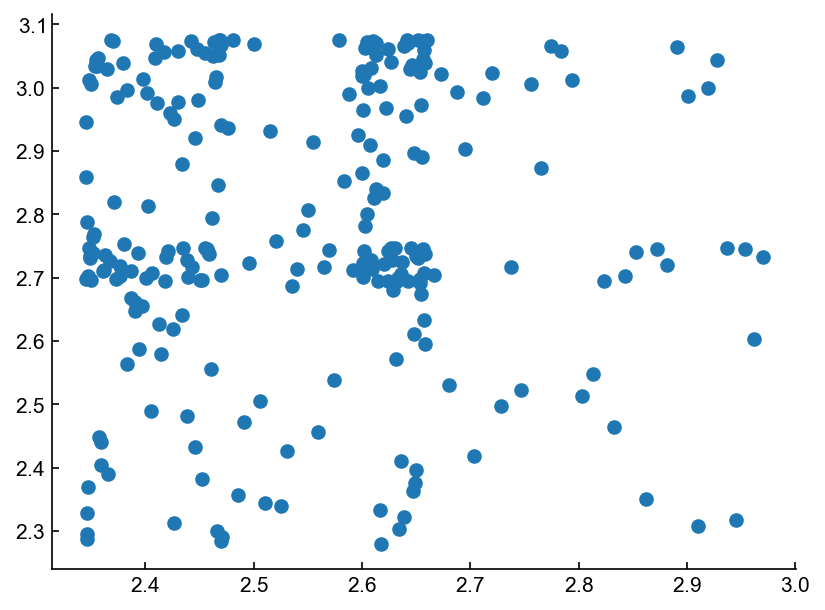

In [170]:
plt.scatter(np.random.permutation(data.baseline),np.random.permutation(data.slow))
print(np.nanmedian(data.baseline))
print(np.nanmedian(data.slow))

In [172]:
data =  [baseline_NCR_avg_FR_Mouth,slow_NCR_avg_FR_Mouth,fast_NCR_avg_FR_Mouth]

data = SimpleNamespace()
data.baseline = baseline_NCR_avg_FR_Mouth
data.slow = slow_NCR_avg_FR_Mouth
data.fast = fast_NCR_avg_FR_Mouth


In [173]:
nonparametricIndependentStatsCompareToBaseline(data)


            Source         SS   DF         MS           F          p-unc  \
0            phase  24.143601    1  24.143601  598.460885  7.017987e-104   
1          context  24.143601    1  24.143601  598.460885  7.017987e-104   
2  phase * context  24.143601    1  24.143601  598.460885  7.017987e-104   
3         Residual  40.181451  996   0.040343         NaN            NaN   

        np2  
0  0.375337  
1  0.375337  
2  0.375337  
3       NaN  

  phase         A             B         p-unc        p-corr    hedges
2  fast  baseline  experimental  5.901917e-83  1.180383e-82  3.636726
3  slow  baseline  experimental  1.000000e+00  1.000000e+00  0.000000


Contrast phase         A             B Paired  Parametric     U-val  \
0            phase     -      fast          slow  False       False   62662.0   
1          context     -  baseline  experimental  False       False  187338.0   
2  phase * context  fast  baseline  experimental  False       False   62419.0   
3  phase * context  slow  baseline  experimental  False       False   31250.0   

  alternative         p-unc        p-corr p-adjust    hedges  
0   two-sided  2.000054e-42           NaN      NaN -1.042978  
1   two-sided  2.000054e-42           NaN      NaN  1.042978  
2   two-sided  5.901917e-83  1.180383e-82   fdr_bh  3.636726  
3   two-sided  1.000000e+00  1.000000e+00   fdr_bh  0.000000

# Old Figs

In [79]:
#Save all in PDF: Plots with same y-axis for each cell in PSTH
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib import pyplot as plt, patches

file_PSTH = 'C:\\Users\insan\\Desktop\\Motion final\\Normalized PSTH across all CRs and NCRs.pdf'
with PdfPages(file_PSTH) as pdf:
    pdf.savefig(fig)
    plt.close('all')

###################

meta NOT subset; don't know how to subset; dropped


In [80]:
CR_COLOR = '#808080'
NCR_COLOR = '#FF767C'

def visualizeClusterMovementAcrossCellsNormalizewithtonereward():
    movementsToPlots = [integrate_3003_movement_onset_samples_arr,mouth_3003_movement_onset_samples_arr,
                   nose_3003_movement_onset_samples_arr,whisker_3003_movement_onset_samples_arr]

    FRmod = sessionfile.responsiveness[clust]['all_trials'].FRmodulation
    FRmod_color = NCR_CR_cmap( (FRmod-1)/5)
    #########################################################################################
    region = sessionfile.meta.region
    #########################################################################################

    fig = plt.figure(figsize=(15,5))
    #fig.suptitle('PSTH for all cells from AE_231_3_AC')
    
    gs = fig.add_gridspec(2,4,height_ratios=[0.4,0.4],hspace=0.5)
    #Integrate
    ax1 = plt.subplot(gs[0,0])#PSTH 
    #Mouth
    ax2 = plt.subplot(gs[0,1],sharey=ax1)#PSTH
    #Nose
    ax3 = plt.subplot(gs[0,2],sharey=ax1)#PSTH
    #Whisker
    ax4 = plt.subplot(gs[0,3],sharey=ax1)#PSTH
    
    ax_PSTH = [ax1,ax2,ax3,ax4]
    
    ax5 = plt.subplot(gs[1,0],sharex=ax1)
    #Speed plot
    ax6 = plt.subplot(gs[1,1])
    ax7 = plt.subplot(gs[1,2],sharex=ax6)
    ax8 = plt.subplot(gs[1,3],sharex=ax6)
  

    ax5.spines['bottom'].set_visible(False)
    ax5.spines['left'].set_visible(False)
    ax5.get_xaxis().set_visible(False)
    ax5.get_yaxis().set_visible(False)
    ax5.scatter(np.random.rand(20),np.random.rand(20),color='r',alpha=0,s=1.5,marker='o',lw=0)
    
    #PSTH
    starttime = -30000 #samples
    endtime = starttime+60000 #samples
    xrange = np.linspace(starttime,endtime,num=1000)
    
    NCR_noravg_FR_Integrate = CalculateforRasterPSTHAcrossCellsNormalize(movementsToPlots[0])[1]
    NCR_norsem_FR_Integrate =  CalculateforRasterPSTHAcrossCellsNormalize(movementsToPlots[0])[3]
    CR_noravg_FR_Integrate = CalculateforRasterPSTHAcrossCellsNormalize(movementsToPlots[0])[0]
    CR_norsem_FR_Integrate =  CalculateforRasterPSTHAcrossCellsNormalize(movementsToPlots[0])[2]
    ax1.plot(xrange,NCR_noravg_FR_Integrate, lw=1,color=NCR_COLOR,label = 'NCR')
    ax1.plot(xrange,CR_noravg_FR_Integrate,lw=1,color=CR_COLOR,label = 'CR')
    ax1.fill_between(xrange,NCR_noravg_FR_Integrate-NCR_norsem_FR_Integrate,NCR_noravg_FR_Integrate+NCR_norsem_FR_Integrate,color=NCR_COLOR,alpha=0.2,zorder=-10,lw=0)
    ax1.fill_between(xrange,CR_noravg_FR_Integrate-CR_norsem_FR_Integrate,CR_noravg_FR_Integrate+CR_norsem_FR_Integrate,color=CR_COLOR,alpha=0.2,zorder=-10,lw=0)
    ax1.annotate('movements = 120', xy=(0, 1.04), xycoords='axes fraction', xytext=(0, 1.02),color='black')
    ax1.set_xlabel('Time relative to all movement onset (s)')
        
    NCR_noravg_FR_Mouth = CalculateforRasterPSTHAcrossCellsNormalize(movementsToPlots[1])[1]
    NCR_norsem_FR_Mouth = CalculateforRasterPSTHAcrossCellsNormalize(movementsToPlots[1])[3]
    CR_noravg_FR_Mouth = CalculateforRasterPSTHAcrossCellsNormalize(movementsToPlots[1])[0]
    CR_norsem_FR_Mouth =  CalculateforRasterPSTHAcrossCellsNormalize(movementsToPlots[1])[2]
    ax2.plot(xrange,NCR_noravg_FR_Mouth, lw=1,color=NCR_COLOR,label = 'NCR')
    ax2.plot(xrange,CR_noravg_FR_Mouth,lw=1,color=CR_COLOR,label = 'CR')
    ax2.fill_between(xrange,NCR_noravg_FR_Mouth-NCR_norsem_FR_Mouth,NCR_noravg_FR_Mouth+NCR_norsem_FR_Mouth,color=NCR_COLOR,alpha=0.2,zorder=-10,lw=0)
    ax2.fill_between(xrange,CR_noravg_FR_Mouth-CR_norsem_FR_Mouth,CR_noravg_FR_Mouth+CR_norsem_FR_Mouth,color=CR_COLOR,alpha=0.2,zorder=-10,lw=0)
    ax2.annotate('movements = 41', xy=(0, 1.04), xycoords='axes fraction', xytext=(0, 1.02),color='black')
    ax2.set_xlabel('Time relative to mouth movement onset (s)')
        
    NCR_noravg_FR_Nose = CalculateforRasterPSTHAcrossCellsNormalize(movementsToPlots[2])[1]
    NCR_norsem_FR_Nose = CalculateforRasterPSTHAcrossCellsNormalize(movementsToPlots[2])[3]
    CR_noravg_FR_Nose = CalculateforRasterPSTHAcrossCellsNormalize(movementsToPlots[2])[0]
    CR_norsem_FR_Nose = CalculateforRasterPSTHAcrossCellsNormalize(movementsToPlots[2])[2]
    ax3.plot(xrange,NCR_noravg_FR_Nose, lw=1,color=NCR_COLOR,label = 'NCR')
    ax3.plot(xrange,CR_noravg_FR_Nose,lw=1,color=CR_COLOR,label = 'CR')
    ax3.fill_between(xrange,NCR_noravg_FR_Nose-NCR_norsem_FR_Nose,NCR_noravg_FR_Nose+NCR_norsem_FR_Nose,color=NCR_COLOR,alpha=0.2,zorder=-10,lw=0)
    ax3.fill_between(xrange,CR_noravg_FR_Nose-CR_norsem_FR_Nose,CR_noravg_FR_Nose+CR_norsem_FR_Nose,color=CR_COLOR,alpha=0.2,zorder=-10,lw=0)
    ax3.annotate('movements = 31', xy=(0, 1.04), xycoords='axes fraction', xytext=(0, 1.02),color='black')
    ax3.set_xlabel('Time relative to nose movement onset (s)')
    
    NCR_noravg_FR_Whisker = CalculateforRasterPSTHAcrossCellsNormalize(movementsToPlots[3])[1]
    NCR_norsem_FR_Whisker = CalculateforRasterPSTHAcrossCellsNormalize(movementsToPlots[3])[3]
    CR_noravg_FR_Whisker = CalculateforRasterPSTHAcrossCellsNormalize(movementsToPlots[3])[0]
    CR_norsem_FR_Whisker = CalculateforRasterPSTHAcrossCellsNormalize(movementsToPlots[3])[2]
    ax4.plot(xrange,NCR_noravg_FR_Whisker, lw=1,color=NCR_COLOR,label = 'NCR n=7')
    ax4.plot(xrange,CR_noravg_FR_Whisker,lw=1,color=CR_COLOR,label = 'CR n=11')
    ax4.fill_between(xrange,NCR_noravg_FR_Whisker-NCR_norsem_FR_Whisker,NCR_noravg_FR_Whisker+NCR_norsem_FR_Whisker,color=NCR_COLOR,alpha=0.2,zorder=-10,lw=0)
    ax4.fill_between(xrange,CR_noravg_FR_Whisker-CR_norsem_FR_Whisker,CR_noravg_FR_Whisker+CR_norsem_FR_Whisker,color=CR_COLOR,alpha=0.2,zorder=-10,lw=0)
    ax4.annotate('movements = 48', xy=(0, 1.04), xycoords='axes fraction', xytext=(0, 1.02),color='black')
    ax4.set_xlabel('Time relative to whisker movement onset (s)')
    
    #Investigate CR modulation
   
    for tone_time in mouth_tone:
        tone_range=[tone_time,tone_time+0.1*30000]
        ax2.fill_between(tone_range,1.5, 1.3, color = 'darkcyan',alpha=0.3)
        #ax2.axvline(tone_time,0.97,1,color='r')
    for tone_time in nose_tone:
        tone_range=[tone_time,tone_time+0.1*30000]
        ax3.fill_between(tone_range,1.5, 1.3, color = 'darkcyan',alpha=0.3)
        #ax3.axvline(tone_time,0.97,1,color='r')
    for tone_time in whisker_tone:
        tone_range=[tone_time,tone_time+0.1*30000]
        ax4.fill_between(tone_range,1.5, 1.3, color = 'darkcyan',alpha=0.3)
        #ax4.axvline(tone_time,0.97,1,color='r')
        
    for reward_time in mouth_reward:
        reward_range=[reward_time,reward_time+100]
        ax2.fill_between(reward_range,1.29, 1.09, color = 'darkviolet',alpha=0.3)
        #ax2.axvline(reward_time,0.8,1.1,color='b',alpha=0.2)
    for reward_time in nose_reward:
        reward_range=[reward_time,reward_time+100]
        ax3.fill_between(reward_range,1.29, 1.09, color = 'darkviolet',alpha=0.3)
        #ax3.axvline(reward_time,0.8,1.1,color='b',alpha=0.2)
    for reward_time in whisker_reward:
        reward_range=[reward_time,reward_time+100]
        ax4.fill_between(reward_range,1.29, 1.09, color = 'darkviolet',alpha=0.3)
        #ax4.axvline(reward_time,0.8,1.1,color='b',alpha=0.2)
        
    ax4.axvline(-33000,color='darkcyan',label='tone duration (0.1s)')
    ax4.axvline(-33000,color='darkviolet',label='reward time')
    
    ax1.set_ylim([-1,1.5])
    ax1.set_yticks([-1,0,1])

    for ax in ax_PSTH:
        ax.axvspan(-30000,0, ymin=0,color='white', alpha=0.3, lw=0,label='slow movement') 
        ax.axvspan(0, 30000, ymin=0,color='lightgray', alpha=0.3, lw=0, label = 'fast movement')
        ax.set_ylabel('Normalized change in firing rate')
        ax.set_xlim([-30000,30000])
        ax.set_xticks([-30000,-15000,0,15000, 30000])
        ax.set_xticklabels(['-1','-0.5','0','0.5','1'])
        #ax.text(18000,1.5,'NCR n=7',color=NCR_COLOR)
        #ax.text(18000,1.8,'CR n=11',color=CR_COLOR)

    ax4.legend(frameon=True,loc=(1.05,0.7))
    
    #Speed plot
    #Mouth speed plot
    ax6.plot(avg_mouth_3003_speed)
    ax6.set_xlim([0,400])
    #ax6.set_xticklabels(['-100','-50','0','50','100'])
    ax6.set_ylabel('Averaged speed(mouth)')
    ax6.set_xlabel('Time relative to mouth movement onset \n(frames)')
    ax6.axvline(200,color='black',linestyle='--',zorder=10,lw=1)
    # ax6.set_yticks([0,0.4,0.8])
    ax6.set_ylim([0.2,1])
    ax6.axvspan(200, 300, ymin=0,color='lightgray', alpha=0.3, lw=0)
    
    #Nose speed plot
    ax7.plot(avg_nose_3003_speed)
    ax7.set_xlim([100,300])
    ax7.set_xticklabels(['-100','-50','0','50','100'])
    ax7.set_ylabel('Averaged speed(nose)')
    ax7.set_xlabel('Time relative to nose movement onset \n(frames)')
    ax7.axvline(200,color='black',linestyle='--',zorder=10,lw=1)
    # ax7.set_yticks([0,0.4,0.8])
    ax7.set_ylim([0.2,1])
    ax7.axvspan(200, 300, ymin=0,color='lightgray', alpha=0.3, lw=0)
    
    #Whisker speed plot
    ax8.plot(avg_whisker_3003_speed)
    ax8.set_xlim([100,300])
    ax8.set_xticklabels(['-100','-50','0','50','100'])
    ax8.set_ylabel('Averaged speed(whisker)')
    ax8.set_xlabel('Time relative to whisker movement onset \n(frames)')
    ax8.axvline(200,color='black',linestyle='--',zorder=10,lw=1)
    # ax8.set_yticks([0,0.4,0.8])
    ax8.set_ylim([0.2,1])
    ax8.axvspan(200, 300, ymin=0,color='lightgray', alpha=0.3, lw=0)
    
    plt.close()
    return fig
    

C:\Users\insan\AppData\Local\Temp\ipykernel_14808\3576912835.py:152: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax7.set_xticklabels(['-100','-50','0','50','100'])
C:\Users\insan\AppData\Local\Temp\ipykernel_14808\3576912835.py:163: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax8.set_xticklabels(['-100','-50','0','50','100'])


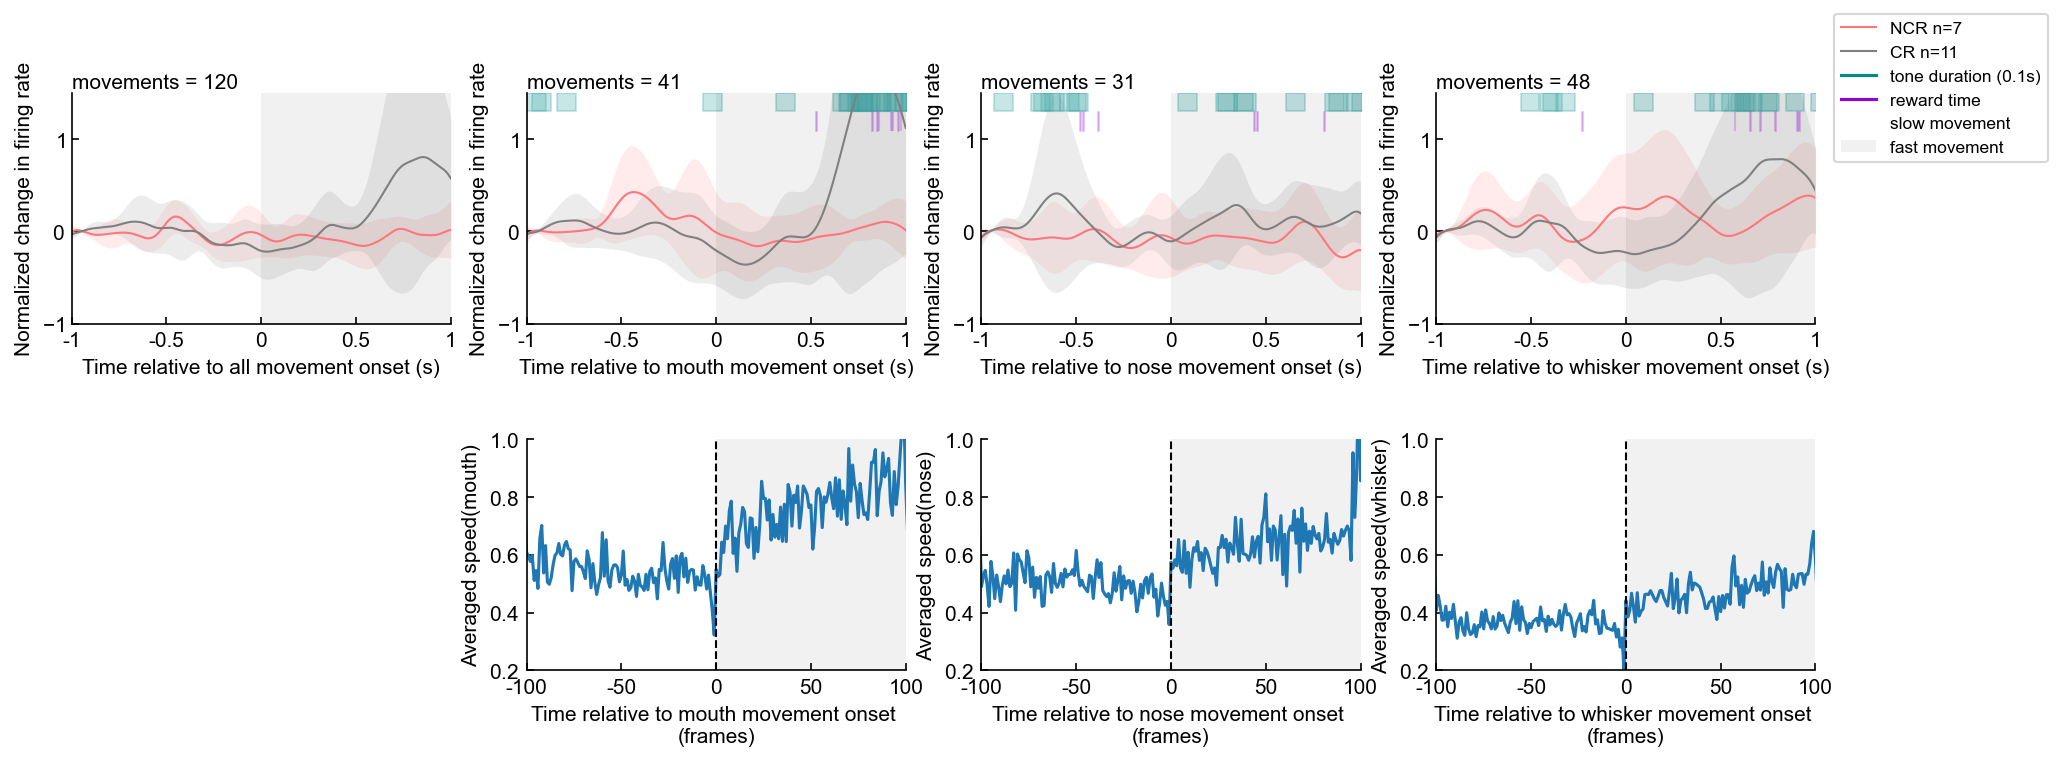

In [81]:
fig = visualizeClusterMovementAcrossCellsNormalizewithtonereward()
#fig.savefig(os.path.join('C:\\Users\insan\\Desktop\\Motion final\\png\\Normalized PSTH across all CRs and NCRs with tone and reward.png'),transparent=False,facecolor="white")
fig


In [82]:
#Save all in PDF: Plots with same y-axis for each cell in PSTH
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib import pyplot as plt, patches

file_PSTH = 'C:\\Users\insan\\Desktop\\Motion final\\Normalized PSTH across all CRs and NCRs with tone_reward time.pdf'
with PdfPages(file_PSTH) as pdf:
    pdf.savefig(fig)
    plt.close('all')

##################

meta NOT subset; don't know how to subset; dropped


In [83]:
#Unnormalized NCR plot

In [186]:
 def CalculateforRasterPSTHAcrossCells(movementsToPlots):
    
    def CalculateClustFR(clust):
        moveSpikes = []
        for movement in movementsToPlots:
            this_move_spike = ilep.getSpikeTimes(sessionfile_D9,clust=clust,starttime=movement-33000, endtime=movement+33000)
            moveSpikes.append(this_move_spike-movement)
        moveSpikes = np.array(moveSpikes,dtype='object') 
        
        bw_scott_factor = 3
        starttime = -30000 #samples
        endtime = starttime+60000 #samples
        xrange = np.linspace(starttime,endtime,num=1000)
        FR = np.full((10,len(xrange)),np.nan) 
        kf = KFold(n_splits=10)
    
        for idx,(move_index,_) in enumerate(kf.split(moveSpikes)):
            PSTHspikes = np.concatenate(moveSpikes[move_index])
            bw = len(PSTHspikes)**(-1./5) / bw_scott_factor
            KDE = gaussian_kde(PSTHspikes,bw_method=bw)
            FR[idx,:] = KDE.evaluate(xrange)
            FR[idx,:] = FR[idx,:] * len(PSTHspikes) / len(move_index) *30000 #convert unit to seconds from samples
        
        avg_FR = np.mean(FR,axis=0) 
    
        return avg_FR 
    
    ###############  
    NCR_avg_FR = []
    for clust in NCR_D9:
        avg_FR = CalculateClustFR(clust)
        NCR_avg_FR.append(avg_FR)
    NCR_avg_FR = np.array(NCR_avg_FR)
     
    NCR_avg = np.mean(NCR_avg_FR,axis=0)
    NCR_sem = np.std(NCR_avg_FR,axis=0)
    #print(len(NCR_avg))
    
    max_FR_value = np.max(NCR_avg+NCR_sem) * 1.1
    sequence_of_possible_axis_limits = np.array([1,2,4,6,8,10,12,16,20,30,40,50,60,80,100,120,140,150,160,180,200])
    idx_of_okay_limits = np.greater_equal(sequence_of_possible_axis_limits,max_FR_value)
    valid_limits = sequence_of_possible_axis_limits[idx_of_okay_limits]
    limit = np.min(valid_limits)
    ###
    CR_avg_FR = []
    for clust in CR_D9:
        avg_FR = CalculateClustFR(clust)
        CR_avg_FR.append(avg_FR)
    CR_avg_FR = np.array(CR_avg_FR)
     
    CR_avg = np.mean(CR_avg_FR,axis=0)
    CR_sem = np.std(CR_avg_FR,axis=0)
    
    CR_max_FR_value = np.max(CR_avg+CR_sem) * 1.1
    CR_idx_of_okay_limits = np.greater_equal(sequence_of_possible_axis_limits,CR_max_FR_value)
    CR_valid_limits = sequence_of_possible_axis_limits[CR_idx_of_okay_limits]
    CR_limit = np.min(CR_valid_limits)
        
    return NCR_avg, NCR_sem, limit, CR_avg, CR_sem,CR_limit

In [187]:
print(CalculateforRasterPSTHAcrossCells(integrate_3003_movement_onset_samples_arr)[-1])
print(CalculateforRasterPSTHAcrossCells(mouth_3003_movement_onset_samples_arr)[-1])
print(CalculateforRasterPSTHAcrossCells(nose_3003_movement_onset_samples_arr)[-1])
print(CalculateforRasterPSTHAcrossCells(whisker_3003_movement_onset_samples_arr)[-1])
print(CalculateforRasterPSTHAcrossCells(integrate_3003_movement_onset_samples_arr)[2])
print(CalculateforRasterPSTHAcrossCells(mouth_3003_movement_onset_samples_arr)[2])
print(CalculateforRasterPSTHAcrossCells(nose_3003_movement_onset_samples_arr)[2])
print(CalculateforRasterPSTHAcrossCells(whisker_3003_movement_onset_samples_arr)[2])

30
30
30
30
8
6
12
8


In [86]:
def visualizeClusterMovementAcrossCells():
    movementsToPlots = [integrate_3003_movement_onset_samples_arr,mouth_3003_movement_onset_samples_arr,
                   nose_3003_movement_onset_samples_arr,whisker_3003_movement_onset_samples_arr]

    FRmod = sessionfile.responsiveness[clust]['all_trials'].FRmodulation
    FRmod_color = NCR_CR_cmap( (FRmod-1)/5)
    #########################################################################################
    region = sessionfile.meta.region
    #########################################################################################

    fig = plt.figure(figsize=(15,5))
    #fig.suptitle('Unnormalized PSTH for all cells and speed plots')
    
    gs = fig.add_gridspec(2,4,height_ratios=[0.4,0.4],hspace=0.5)

    #Mouth
    ax2 = plt.subplot(gs[0,1])#PSTH
    #Nose
    ax3 = plt.subplot(gs[0,2],sharey=ax2)#PSTH
    #Whisker
    ax4 = plt.subplot(gs[0,3],sharey=ax2)#PSTH
    #Integrate
    ax1 = plt.subplot(gs[0,0],sharey=ax2)#PSTH - removed
    
    ax_PSTH = [ax2,ax3,ax4]
    
    ax5 = plt.subplot(gs[1,0],sharex=ax2)
    #Speed plot
    ax6 = plt.subplot(gs[1,1])
    ax7 = plt.subplot(gs[1,2],sharex=ax6)
    ax8 = plt.subplot(gs[1,3],sharex=ax6)
  

    ax5.spines['bottom'].set_visible(False)
    ax5.spines['left'].set_visible(False)
    ax5.get_xaxis().set_visible(False)
    ax5.get_yaxis().set_visible(False)
    ax5.scatter(np.random.rand(20),np.random.rand(20),color='r',alpha=0,s=1.5,marker='o',lw=0)
    ax1.spines['bottom'].set_visible(False)
    ax1.spines['left'].set_visible(False)
    ax1.get_xaxis().set_visible(False)
    ax1.get_yaxis().set_visible(False)

    #PSTH
    starttime = -30000 #samples
    endtime = starttime+60000 #samples
    xrange = np.linspace(starttime,endtime,num=1000)
    
    #Not show
    NCR_avg_FR_Integrate = CalculateforRasterPSTHAcrossCells(movementsToPlots[0])[0]
    NCR_sem_FR_Integrate = CalculateforRasterPSTHAcrossCells(movementsToPlots[0])[1]
    ax1.plot(xrange,NCR_avg_FR_Integrate, lw=1,color=NCR_COLOR,label = 'NCR',alpha=0)
    #ax1.fill_between(xrange,NCR_avg_FR_Integrate-NCR_sem_FR_Integrate,NCR_avg_FR_Integrate+NCR_sem_FR_Integrate,color=color,alpha=0.2,zorder=-10,lw=0)
    ax1.set_xlabel('Time relative to all movement onset (s)')
    
    #show
    NCR_avg_FR_Mouth = CalculateforRasterPSTHAcrossCells(movementsToPlots[1])[0]
    NCR_sem_FR_Mouth = CalculateforRasterPSTHAcrossCells(movementsToPlots[1])[1]
    ax2.plot(xrange,NCR_avg_FR_Mouth, lw=1,color=NCR_COLOR,label = 'NCR')
    ax2.fill_between(xrange,NCR_avg_FR_Mouth-NCR_sem_FR_Mouth,NCR_avg_FR_Mouth+NCR_sem_FR_Mouth,color=NCR_COLOR,alpha=0.2,zorder=-10,lw=0)
    CR_avg_FR_Mouth = CalculateforRasterPSTHAcrossCells(movementsToPlots[1])[3]
    CR_sem_FR_Mouth = CalculateforRasterPSTHAcrossCells(movementsToPlots[1])[4]
    ax2.plot(xrange,CR_avg_FR_Mouth, lw=1,color=CR_COLOR,label = 'CR')
    ax2.fill_between(xrange,CR_avg_FR_Mouth-CR_sem_FR_Mouth,CR_avg_FR_Mouth+CR_sem_FR_Mouth,color=CR_COLOR,alpha=0.2,zorder=-10,lw=0)
    ax2.set_xlabel('Time relative to mouth movement onset (s)')
    
    NCR_avg_FR_Nose = CalculateforRasterPSTHAcrossCells(movementsToPlots[2])[0]
    NCR_sem_FR_Nose = CalculateforRasterPSTHAcrossCells(movementsToPlots[2])[1]
    ax3.plot(xrange,NCR_avg_FR_Nose, lw=1,color=NCR_COLOR,label = 'NCR')
    ax3.fill_between(xrange,NCR_avg_FR_Nose-NCR_sem_FR_Nose,NCR_avg_FR_Nose+NCR_sem_FR_Nose,color=NCR_COLOR,alpha=0.2,zorder=-10,lw=0)
    CR_avg_FR_Nose = CalculateforRasterPSTHAcrossCells(movementsToPlots[2])[3]
    CR_sem_FR_Nose = CalculateforRasterPSTHAcrossCells(movementsToPlots[2])[4]
    ax3.plot(xrange,CR_avg_FR_Nose, lw=1,color=CR_COLOR,label = 'CR')
    ax3.fill_between(xrange,CR_avg_FR_Nose-CR_sem_FR_Nose,CR_avg_FR_Nose+CR_sem_FR_Nose,color=CR_COLOR,alpha=0.2,zorder=-10,lw=0)
    ax3.set_xlabel('Time relative to nose movement onset (s)')
    
    NCR_avg_FR_Whisker = CalculateforRasterPSTHAcrossCells(movementsToPlots[3])[0]
    NCR_sem_FR_Whisker = CalculateforRasterPSTHAcrossCells(movementsToPlots[3])[1]
    ax4.plot(xrange,NCR_avg_FR_Whisker, lw=1,color=NCR_COLOR,label = 'NCR n=7')
    ax4.fill_between(xrange,NCR_avg_FR_Whisker-NCR_sem_FR_Whisker,NCR_avg_FR_Whisker+NCR_sem_FR_Whisker,color=NCR_COLOR,alpha=0.2,zorder=-10,lw=0)
    CR_avg_FR_Whisker = CalculateforRasterPSTHAcrossCells(movementsToPlots[3])[3]
    CR_sem_FR_Whisker = CalculateforRasterPSTHAcrossCells(movementsToPlots[3])[4]
    ax4.plot(xrange,CR_avg_FR_Whisker, lw=1,color=CR_COLOR,label = 'CR n=11')
    ax4.fill_between(xrange,CR_avg_FR_Whisker-CR_sem_FR_Whisker,CR_avg_FR_Whisker+CR_sem_FR_Whisker,color=CR_COLOR,alpha=0.2,zorder=-10,lw=0)
    ax4.set_xlabel('Time relative to whisker movement onset (s)')
    
    highest_limit = 30
    ax1.set_ylim([0,highest_limit])
    ax1.set_yticks([0,highest_limit/2,highest_limit])
    #ax1.set_yticklabels(['0.2','0.6','1.0']) #plot purpose
    ax1.set_yticklabels(['0',str(int(highest_limit/2)),str(highest_limit)]) #real

    for ax in ax_PSTH:
        ax.axvspan(-30000,0, ymin=0,color='white', alpha=0.3, lw=0,label='slow movement') 
        ax.axvspan(0, 30000, ymin=0,color='lightgray', alpha=0.3, lw=0, label = 'fast movement')
        ax.set_ylabel('Firing rate (spikes/s)')
        ax.set_xlim([-30000,30000])
        ax.set_xticks([-30000,-15000,0,15000, 30000])
        #ax.set_xticklabels(['-100','-0.5','0','0.5','1'])#plot purpose
        ax.set_xticklabels(['-1','-0.5','0','0.5','1'])#real
        #ax.text(18000,highest_limit,'NCR n=7',color=NCR_COLOR)
        #ax.text(18000,highest_limit+3,'CR n=11',color=CR_COLOR)

    ax4.legend(frameon=True,loc=(1.05,0.7))
    
    #Speed plot
    #Mouth speed plot
    ax6.plot(avg_mouth_3003_speed,color='#969696')
    ax6.set_xlim([0,400])
    #ax6.set_xticklabels(['-100','-50','0','50','100'])
    ax6.set_ylabel('Averaged speed (mouth)')
    ax6.set_xlabel('Time relative to mouth movement onset \n(frames)')
    #ax6.axvline(200,color='black',linestyle='--',zorder=10,lw=1)
    ax6.set_yticks([0.2,0.6,1])
    ax6.set_ylim([0.2,1])
    ax6.axvspan(200, 300, ymin=0,color='lightgray', alpha=0.3, lw=0)
    
    #Nose speed plot
    ax7.plot(avg_nose_3003_speed,color='#969696')
    ax7.set_xlim([100,300])
    ax7.set_xticklabels(['-100','-50','0','50','100'])
    ax7.set_ylabel('Averaged speed (nose)')
    ax7.set_xlabel('Time relative to nose movement onset \n(frames)')
    #ax7.axvline(200,color='black',linestyle='--',zorder=10,lw=1)
    ax7.set_yticks([0.2,0.6,1])
    ax7.set_ylim([0.2,1])
    ax7.axvspan(200, 300, ymin=0,color='lightgray', alpha=0.3, lw=0)
    
    #Whisker speed plot
    ax8.plot(avg_whisker_3003_speed,color='#969696')
    ax8.set_xlim([100,300])
    ax8.set_xticklabels(['-100','-50','0','50','100'])
    ax8.set_ylabel('Averaged speed (whisker)')
    ax8.set_xlabel('Time relative to whisker movement onset \n(frames)')
    #ax8.axvline(200,color='black',linestyle='--',zorder=10,lw=1)
    ax8.set_yticks([0.2,0.6,1])
    ax8.set_ylim([0.2,1])
    ax8.axvspan(200, 300, ymin=0,color='lightgray', alpha=0.3, lw=0)
    
    plt.close()
    return fig

In [87]:
fig = visualizeClusterMovementAcrossCells()
fig.savefig(os.path.join('C:\\Users\insan\\Desktop\\Motion final\\png\\Unnormalized PSTH across all NCRs and CRs.png'),transparent=False,facecolor="white")
fig

#Save all in PDF: Plots with same y-axis for each cell in PSTH
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib import pyplot as plt, patches

file_PSTH = 'C:\\Users\insan\\Desktop\\Motion final\\Unnormalized PSTH across all NCRs and CRs.pdf'
with PdfPages(file_PSTH) as pdf:
    pdf.savefig(fig)
    plt.close('all')

C:\Users\insan\AppData\Local\Temp\ipykernel_14808\1899987377.py:121: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax7.set_xticklabels(['-100','-50','0','50','100'])
C:\Users\insan\AppData\Local\Temp\ipykernel_14808\1899987377.py:132: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax8.set_xticklabels(['-100','-50','0','50','100'])
meta NOT subset; don't know how to subset; dropped


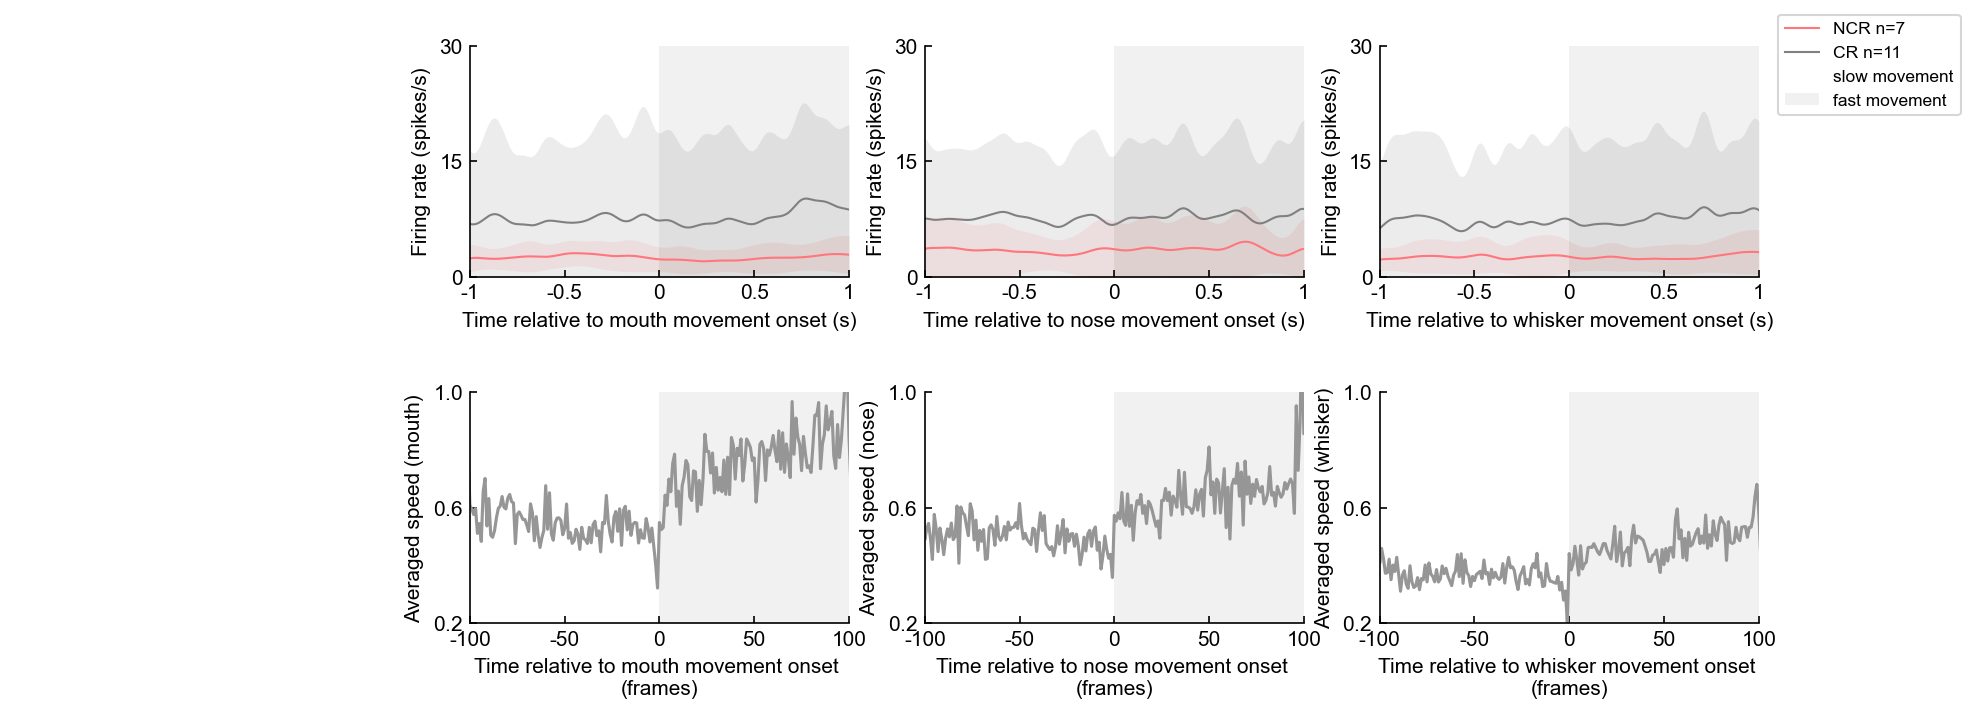

In [88]:
fig

In [89]:
# (timefile3[7479] - timefile3[7380])*30000